**Importing Libraries**

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.9 MB/s eta 0:00:0000:01


In [2]:
!pip install "pystan<3.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 21.3 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9434277 sha256=3fc5f94fbebc235df409fbba347fb06152dc543d099529ed002d1083b4932d69
  Stored in directory: /root/.cache/pip/wheels/fc/66/ad/951ba2b4576f7364afe7aeea8b0036e38d2179d6773f16d69f
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdstanpy-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
import datetime
import matplotlib.dates as mdates
from cycler import cycler


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse
from scipy import signal
from scipy.stats import jarque_bera as jb
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

**Importing Data**

In [5]:
retail_data=pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calender=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
sell_prices=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")

In [6]:
retail_data.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [7]:
retail_data.describe(include='all')

id        item_id  dept_id cat_id store_id  \
count                           30490          30490    30490  30490    30490   
unique                          30490           3049        7      3       10   
top     HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  FOODS_3  FOODS     CA_1   
freq                                1             10     8230  14370     3049   
mean                              NaN            NaN      NaN    NaN      NaN   
std                               NaN            NaN      NaN    NaN      NaN   
min                               NaN            NaN      NaN    NaN      NaN   
25%                               NaN            NaN      NaN    NaN      NaN   
50%                               NaN            NaN      NaN    NaN      NaN   
75%                               NaN            NaN      NaN    NaN      NaN   
max                               NaN            NaN      NaN    NaN      NaN   

       state_id           d_1           d_2           d_3           d_4  ...  \
count     30490  30490.000000  30490.000000  30490.000000  30490.000000  ...   
unique        3           NaN           NaN           NaN           NaN  ...   
top          CA           NaN           NaN           NaN           NaN  ...   
freq      12196           NaN           NaN           NaN           NaN  ...   
mean        NaN      1.070220      1.041292      0.780026      0.833454  ...   
std         NaN      5.126689      5.365468      3.667454      4.415141  ...   
min         NaN      0.000000      0.000000      0.000000      0.000000  ...   
25%         NaN      0.000000      0.000000      0.000000      0.000000  ...   
50%         NaN      0.000000      0.000000      0.000000      0.000000  ...   
75%         NaN      0.000000      0.000000      0.000000      0.000000  ...   
max         NaN    360.000000    436.000000    207.000000    323.000000  ...   

              d_1932        d_1933        d_1934        d_1935        d_1936  \
count   30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        1.445490      1.781174      1.965267      1.389374      1.271794   
std         3.656824      4.426550      4.706284      3.313292      3.126178   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.000000      0.000000      0.000000   
50%         0.000000      1.000000      1.000000      0.000000      0.000000   
75%         2.000000      2.000000      2.000000      2.000000      1.000000   
max       143.000000    156.000000    187.000000     98.000000     90.000000   

              d_1937        d_1938        d_1939        d_1940        d_1941  
count   30490.000000  30490.000000  30490.000000  30490.000000  30490.000000  
unique           NaN           NaN           NaN           NaN           NaN  
top              NaN           NaN           NaN           NaN           NaN  
freq             NaN           NaN           NaN           NaN           NaN  
mean        1.216661      1.212299      1.395605      1.689669      1.782158  
std         3.000348      2.955910      3.514318      4.089208      4.284356  
min         0.000000      0.000000      0.000000      0.000000      0.000000  
25%         0.000000      0.000000      0.000000      0.000000      0.000000  
50%         0.000000      0.000000      0.000000      1.000000      1.000000  
75%         1.000000      1.000000      1.000000      2.000000      2.000000  
max        77.000000     84.000000    110.000000    156.000000    117.000000  

[11 rows x 1947 columns]

In [8]:
calender.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [10]:
calender['event_name_1'].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [11]:
calender['event_type_1'].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [12]:
calender['event_name_2'].unique()

array([nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
      dtype=object)

In [13]:
calender['event_type_2'].unique()

array([nan, 'Cultural', 'Religious'], dtype=object)

In [14]:
calender.describe(include='all')

date      wm_yr_wk   weekday         wday        month  \
count         1969   1969.000000      1969  1969.000000  1969.000000   
unique        1969           NaN         7          NaN          NaN   
top     2011-01-29           NaN  Saturday          NaN          NaN   
freq             1           NaN       282          NaN          NaN   
mean           NaN  11347.086338       NaN     3.997461     6.325546   
std            NaN    155.277043       NaN     2.001141     3.416864   
min            NaN  11101.000000       NaN     1.000000     1.000000   
25%            NaN  11219.000000       NaN     2.000000     3.000000   
50%            NaN  11337.000000       NaN     4.000000     6.000000   
75%            NaN  11502.000000       NaN     6.000000     9.000000   
max            NaN  11621.000000       NaN     7.000000    12.000000   

               year     d event_name_1 event_type_1  event_name_2  \
count   1969.000000  1969          162          162             5   
unique          NaN  1969           30            4             4   
top             NaN   d_1    SuperBowl    Religious  Father's day   
freq            NaN     1            6           55             2   
mean    2013.288471   NaN          NaN          NaN           NaN   
std        1.580198   NaN          NaN          NaN           NaN   
min     2011.000000   NaN          NaN          NaN           NaN   
25%     2012.000000   NaN          NaN          NaN           NaN   
50%     2013.000000   NaN          NaN          NaN           NaN   
75%     2015.000000   NaN          NaN          NaN           NaN   
max     2016.000000   NaN          NaN          NaN           NaN   

       event_type_2      snap_CA      snap_TX      snap_WI  
count             5  1969.000000  1969.000000  1969.000000  
unique            2          NaN          NaN          NaN  
top        Cultural          NaN          NaN          NaN  
freq              4          NaN          NaN          NaN  
mean            NaN     0.330117     0.330117     0.330117  
std             NaN     0.470374     0.470374     0.470374  
min             NaN     0.000000     0.000000     0.000000  
25%             NaN     0.000000     0.000000     0.000000  
50%             NaN     0.000000     0.000000     0.000000  
75%             NaN     1.000000     1.000000     1.000000  
max             NaN     1.000000     1.000000     1.000000

In [15]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [16]:
sell_prices.describe(include='all')

store_id      item_id      wm_yr_wk    sell_price
count   6841121      6841121  6.841121e+06  6.841121e+06
unique       10         3049           NaN           NaN
top        TX_2  FOODS_3_587           NaN           NaN
freq     701214         2820           NaN           NaN
mean        NaN          NaN  1.138294e+04  4.410952e+00
std         NaN          NaN  1.486100e+02  3.408814e+00
min         NaN          NaN  1.110100e+04  1.000000e-02
25%         NaN          NaN  1.124700e+04  2.180000e+00
50%         NaN          NaN  1.141100e+04  3.470000e+00
75%         NaN          NaN  1.151700e+04  5.840000e+00
max         NaN          NaN  1.162100e+04  1.073200e+02

After importing all the data we will slice out the data of Califronia State and store in rd_ca variable. 

In [17]:
rd_ca=retail_data[retail_data["state_id"]=="CA"].copy()
print("Missing Values:" +str(rd_ca.isna().sum().sum())) #To check whether we have any null data.
rd_ca.head(5)

Missing Values:0


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In the dataset we first have the columns to identify the item,department, category, store and state. We have individual column for each day(d_1 to d_1941), which gives us the information regarding the quantity sold of the product on that given day. 

In [18]:
sell_prices=sell_prices[sell_prices["store_id"].isin(["CA_1","CA_2","CA_3","CA_4"])]
print("Missing Values: "+ str(sell_prices.isna().sum().sum()))
sell_prices.head(5)

Missing Values: 0


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

This dataframe provides us information regarding the sell prices of various products at different stores.The price of the items change weekly. We have sliced out the data for stores in California.

After this we will also convert wide format dataframe 'rd_ca' to a long format dataframe, so that we can join the data from calender and sell_prices and have all the data in one dataframe.

In [19]:
rd_ca_melted=rd_ca.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
rd_ca_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
rd_ca_melted.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  Day  Quantity  
0       CA  d_1         0  
1       CA  d_1         0  
2       CA  d_1         0  
3       CA  d_1         0  
4       CA  d_1         0

Melting the dataset to use it in analysis.

**Joining Various Datasets**

In [20]:
ca_joined=pd.merge(calender,rd_ca_melted,how="right",left_on=("d"),right_on="Day")
ca_joined=pd.merge(ca_joined,sell_prices,how="left",on=["store_id","item_id","wm_yr_wk"])
ca_joined.head(10)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
1  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
2  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
3  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
4  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
5  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
6  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
7  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
8  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
9  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   

  event_type_1 event_name_2  ... snap_WI                             id  \
0          NaN          NaN  ...       0  HOBBIES_1_001_CA_1_evaluation   
1          NaN          NaN  ...       0  HOBBIES_1_002_CA_1_evaluation   
2          NaN          NaN  ...       0  HOBBIES_1_003_CA_1_evaluation   
3          NaN          NaN  ...       0  HOBBIES_1_004_CA_1_evaluation   
4          NaN          NaN  ...       0  HOBBIES_1_005_CA_1_evaluation   
5          NaN          NaN  ...       0  HOBBIES_1_006_CA_1_evaluation   
6          NaN          NaN  ...       0  HOBBIES_1_007_CA_1_evaluation   
7          NaN          NaN  ...       0  HOBBIES_1_008_CA_1_evaluation   
8          NaN          NaN  ...       0  HOBBIES_1_009_CA_1_evaluation   
9          NaN          NaN  ...       0  HOBBIES_1_010_CA_1_evaluation   

         item_id    dept_id   cat_id store_id state_id  Day Quantity  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
5  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
6  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   
7  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1       CA  d_1       12   
8  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1       CA  d_1        2   
9  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1       CA  d_1        0   

  sell_price  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN  
7       0.46  
8       1.56  
9       3.17  

[10 rows x 23 columns]

Joined the sales dataset with Calender Dataset and also sell_prices dataset.

In [21]:
ca_joined.drop(["snap_TX","snap_WI"],axis=1,inplace=True) #dropping columns not related to california state
ca_joined["total_sales"]=ca_joined["Quantity"]*ca_joined["sell_price"]

Calculating daily total sale value for each product at each store.

In [22]:
CA_store_daily=ca_joined.groupby(["store_id","date"],as_index=False).agg(Total_sales=("total_sales","sum"))
CA_store_daily["date"]=pd.to_datetime(CA_store_daily["date"])
CA_combined=CA_store_daily.pivot(index="date",columns="store_id",values="Total_sales")
CA1,CA2,CA3,CA4=[CA_store_daily[CA_store_daily["store_id"]==i].copy() for i in ["CA_1","CA_2","CA_3","CA_4"]]
CA1.info()
CA_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 1940
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   store_id     1941 non-null   object        
 1   date         1941 non-null   datetime64[ns]
 2   Total_sales  1941 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.7+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CA_1    1941 non-null   float64
 1   CA_2    1941 non-null   float64
 2   CA_3    1941 non-null   float64
 3   CA_4    1941 non-null   float64
dtypes: float64(4)
memory usage: 75.8 KB


In [23]:
CA1.head()

store_id       date  Total_sales
0     CA_1 2011-01-29     10933.16
1     CA_1 2011-01-30      9787.06
2     CA_1 2011-01-31      7201.38
3     CA_1 2011-02-01      7407.74
4     CA_1 2011-02-02      6566.12

In [24]:
CA1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 1940
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   store_id     1941 non-null   object        
 1   date         1941 non-null   datetime64[ns]
 2   Total_sales  1941 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.7+ KB


In [25]:
CA2.head()

store_id       date  Total_sales
1941     CA_2 2011-01-29      9101.52
1942     CA_2 2011-01-30      8417.53
1943     CA_2 2011-01-31      5320.51
1944     CA_2 2011-02-01      5550.56
1945     CA_2 2011-02-02      5229.72

Calculating daily total sales for each store. Creating a new combined wideformat dataframe, where store_id are the columns, and cell contain daily total sale value for that store.

In [26]:
for i in [CA1,CA2,CA3,CA4]:
    i.set_index("date",inplace=True)
    i.index.freq="D"

**Calculating Monthly sales for all stores.**

In [27]:
CA_monthly=CA_combined.resample("MS").sum()
CA_monthly_ind=[]
for i in [CA1,CA2,CA3,CA4]:
    CA_monthly_ind.append(i["Total_sales"].resample("MS").sum())
CA_monthly_long=CA_store_daily.set_index("date").groupby(["store_id"])["Total_sales"].resample("MS").sum().reset_index()

In [28]:
CA_monthly_long.head()

store_id       date  Total_sales
0     CA_1 2011-01-01     27921.60
1     CA_1 2011-02-01    233687.91
2     CA_1 2011-03-01    249606.68
3     CA_1 2011-04-01    258612.43
4     CA_1 2011-05-01    251748.36

Text(0.5, 1.0, 'Monthly sales from Feb-2011 to April-2016')

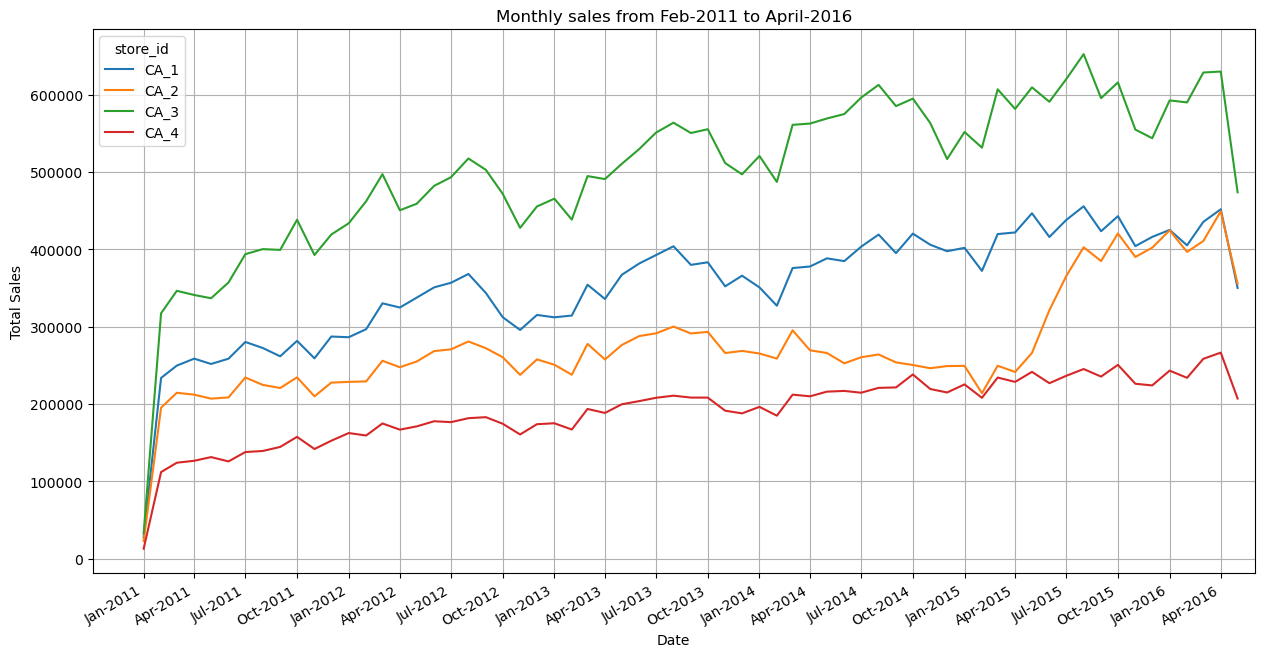

In [29]:
CA_monthly.plot(legend=True,
                figsize=(15,8),
                xlim=[datetime.datetime(2010,10,2),datetime.datetime(2016,6,1)],
                grid=True,
                ylabel="Total Sales",
                xlabel="Date",
                x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_title("Monthly sales from Feb-2011 to April-2016")

From the graph we can infer few things

- For all the stores except CA2, total monthly sales is generally increasing year over year. The trend is upwards. 
- The data is showing seasonality.
- For CA2, the trend is sideways till July-2015, after that is sudenly increases. 


In [30]:
for i in range(4):
    CA_monthly_ind[i]=CA_monthly_ind[i].loc["02-2011":"04-2016"].copy()
CA_monthly=CA_monthly.loc["02-2011":"04-2016"].copy()
CA_monthly_long=CA_monthly_long.set_index("date").loc["02-2011":"04-2016"]

In [31]:
CA_monthly.to_excel("CA__monthly.xlsx")
for j,i in enumerate(CA_monthly_ind):
    i.to_excel("CA_"+str(j+1)+".xlsx")
CA_monthly_long.to_excel("CA__monthly_long.xlsx")

Exporting files to excel, so the above computing intensive data preparation steps can be skipped after data preparation is done for the first time.

In [32]:
print("Length of the full dataset:"+str(len(CA_monthly.index.unique())))

Length of the full dataset:63


### Train Test Split

Before continuing further analysis it is necessary to split the dataset in train and test data. EDA, model fitting and selections would only be done using training data. Testing data will only be used after this to avoid any bias.

Typically we want atleast 3-4 full seasonal cycle for training. The testing data should be atleast equal to the forecast horizon. We have 63 months of data in our dataset. We want to forecast 6 months ahead after April 2016. 

Also in a year there are 12 months, therefore, the length of one complete cycle is 12.

Keeping these things in mind we will have our trainig data as first 54 months which will contain more than 4 seasonal cycles of data.Subsequently our testing data would be last 9 months of data.

In [33]:
CA_monthly_ind=[]
CA_monthly=pd.read_excel("CA__monthly.xlsx",parse_dates=True).set_index("date")
CA_monthly.index.freq="MS"
CA1=pd.read_excel("CA_1.xlsx",parse_dates=True).set_index("date")
CA2=pd.read_excel("CA_2.xlsx",parse_dates=True).set_index("date")
CA3=pd.read_excel("CA_3.xlsx",parse_dates=True).set_index("date")
CA4=pd.read_excel("CA_4.xlsx",parse_dates=True).set_index("date")
CA_monthly_long=pd.read_excel("CA__monthly_long.xlsx",parse_dates=True).set_index("date")
for i in [CA1,CA2,CA3,CA4]:
    CA_monthly_ind.append(i["Total_sales"])

In [34]:
Train=CA_monthly[:-9]
Test=CA_monthly[-9:]
Train_ind=[i[:-9] for i in CA_monthly_ind]
Test_ind=[i[-9:] for i in CA_monthly_ind]
Train_long=CA_monthly_long.loc["02-2011":"07-2015"]
Test_long=CA_monthly_long.loc["08-2015":]

### Exploratory Data Analysis

#### Rolling Mean and Sales 

Text(0.5, 0.98, 'Monthly Sale And Rolling Mean')

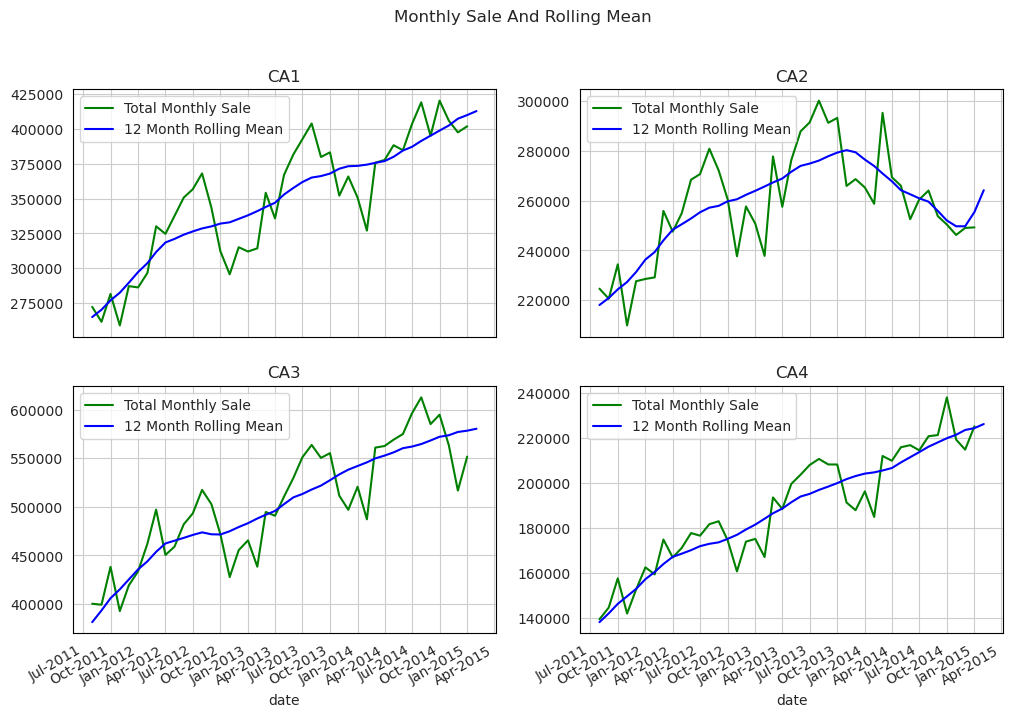

In [35]:
sns.set_style("whitegrid",{"axes.edgecolor": "black"})
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharex=True)
k=0;
for i in range(2):
    for y in range(2):
        Train_ind[k][6:-6].plot(legend=True,label="Total Monthly Sale",color="green",ax=axes[i][y],grid=True,x_compat=True,title="CA"+str(k+1))
        Train_ind[k].rolling(12,center=True).mean().plot(legend=True,color="blue",label="12 Month Rolling Mean",ax=axes[i][y],grid=True,x_compat=True)
        axes[i][y].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        axes[i][y].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        k=k+1
fig.suptitle("Monthly Sale And Rolling Mean")

We can see some seasonal pattern, sale is peaking for CA1, CA3 and CA4 between July and October months for all years. For CA2, sales is more random and sales is peaking between july and october for 2 years, while peaking between jan and april for one year.

The trend is upwards for CA1, CA3 and CA4. For CA2, the trend is increasing till Dec-2013, and then we observe decreasing trend. 

We are observing trend using Rolling Mean.

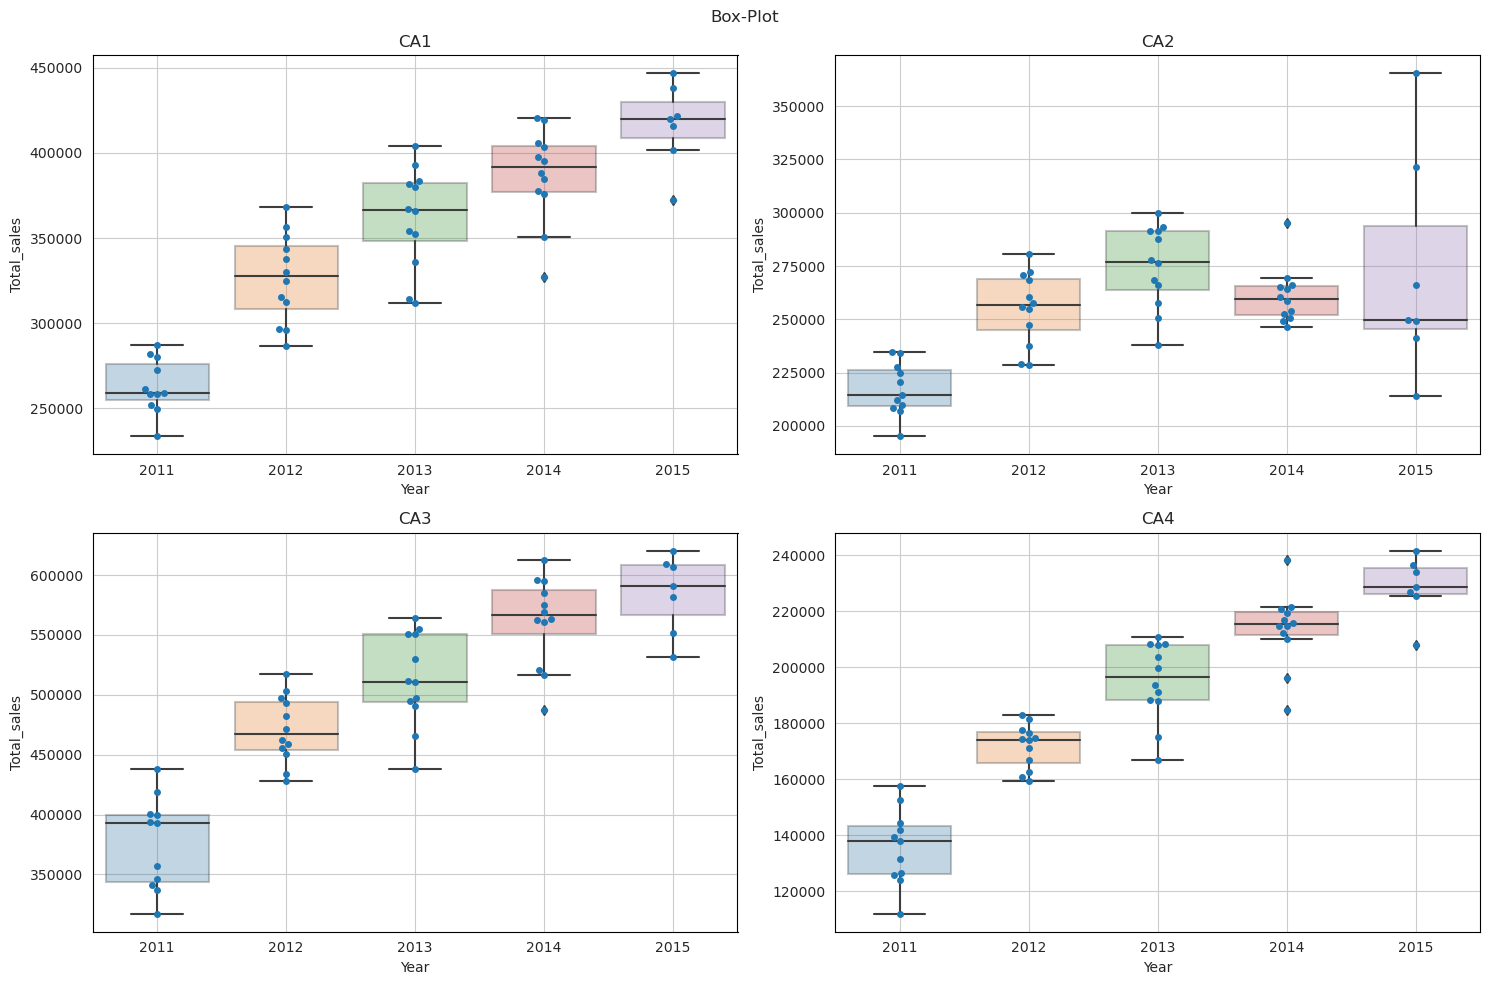

In [36]:
fig, ax = plt.subplots(figsize = (15,10),nrows=2,ncols=2)
for i in range(4):
    sns.boxplot(x=Train_ind[i].index.year.tolist(),y=Train_ind[i] ,ax=ax[int(i/2)][i%2], boxprops=dict(alpha=.3));
    sns.swarmplot(y=Train_ind[i],ax=ax[int(i/2)][i%2] ,x=Train_ind[i].index.year.tolist())
    ax[int(i/2)][i%2].set_title("CA"+str(i+1))
    ax[int(i/2)][i%2].grid(True)
    ax[int(i/2)][i%2].set_xlabel("Year")
fig.suptitle("Box-Plot")
fig.tight_layout()

Mean increases over the years for all stores except CA2. In the year 2014 there are outliers for all the stores. Other than that we dont find any outliers.

For CA1 and CA3 the distribution varies less over the years as the length of the box plot does not changes much between 2011 and 2015. 

For CA2 the total monthly sale value varies significantly in 2015 and is more concentrated in in 2014.  This agrees with the side ways line for CA_2 store we see in graph titled "Monthly Sale From Jan-2011 to May-2016".

For CA4, the total monthly sale becomes more concentrated in the years 2014 and 2015.

In [37]:
# Outlier finding formula
# iqr=(np.percentile(CA_monthly_ind[0]["2014"],75)-np.percentile(CA_monthly_ind[0]["2014"],25))
# iqr1=iqr*1.5
# np.percentile(CA_monthly_ind[0]["2014"],25)-iqr1

#### Monthly trends & distrbution

**Monthly Subseries Plot**

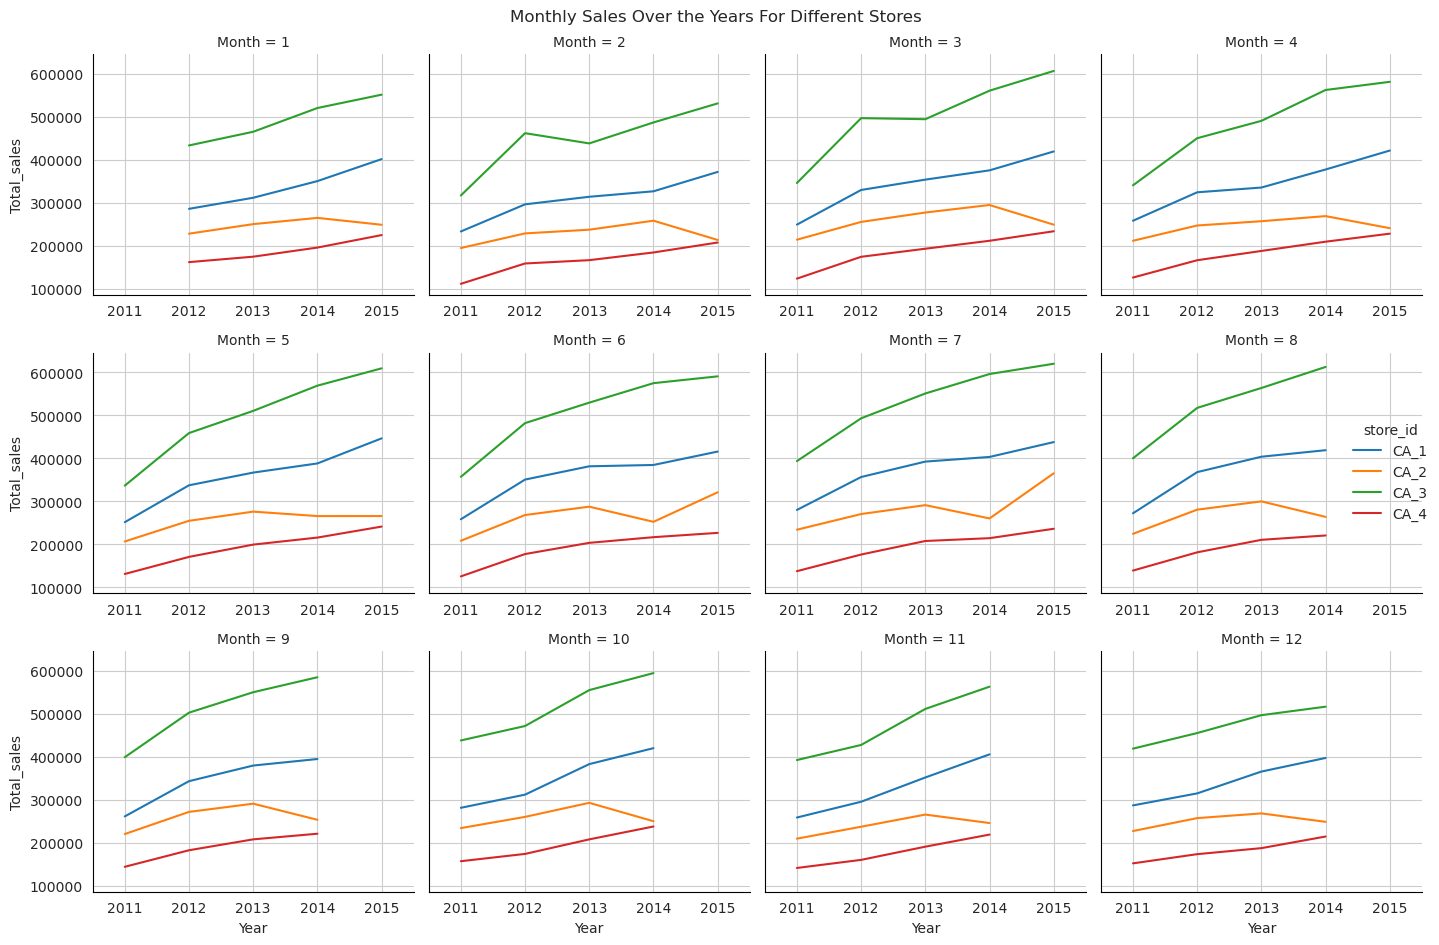

In [38]:
Train_ss=Train_long.copy()
Train_ss["Year"]=Train_ss.index.year.tolist()
Train_ss["Month"]=Train_ss.index.month.tolist()
fg_grid=sns.relplot(data=Train_ss.reset_index(),
                x="Year",
                hue="store_id",
                y="Total_sales",
                col="Month",
                kind="line",
                col_wrap=4,
                height=3.2,
                aspect=1.06,
                facet_kws={"sharex":False,"xlim":(2010.5,2015.5),"sharey":True}
).figure.suptitle("Monthly Sales Over the Years For Different Stores")
fg_grid.figure.tight_layout()

Sale is increasing for different months year on year for all stores except CA2. 

**Distribution Plot**

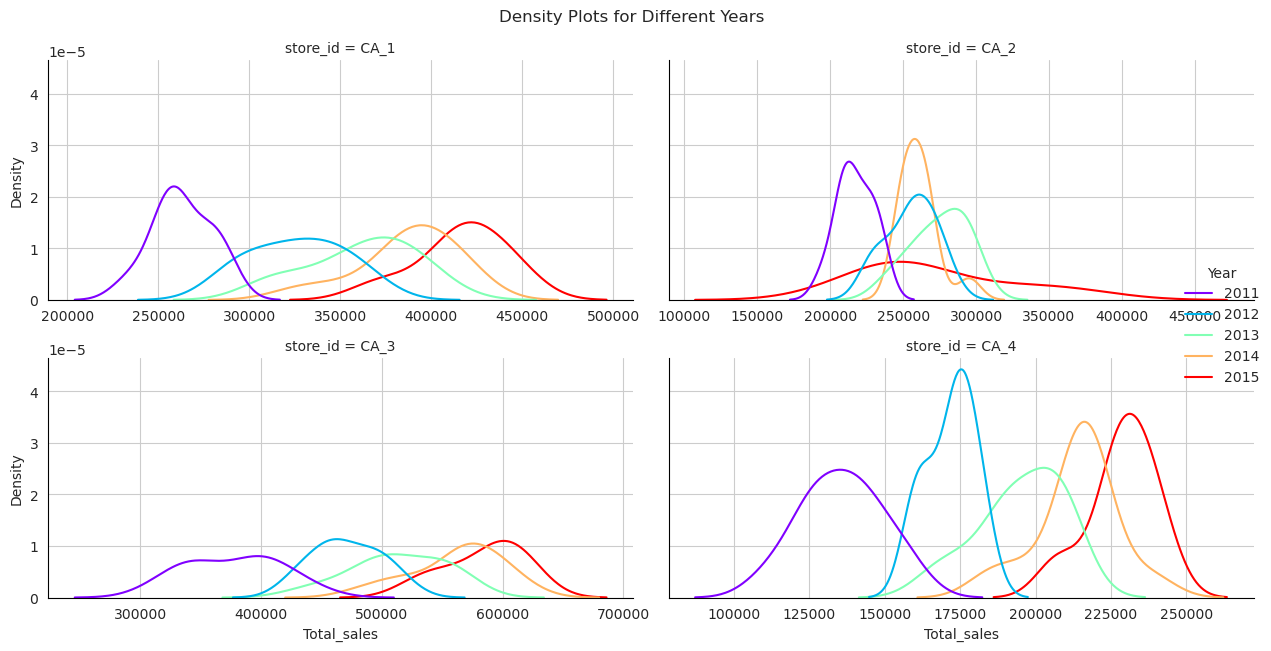

In [39]:
fg_grid=sns.displot(data=Train_ss.reset_index(),
            x="Total_sales",
            kind="kde",
            col="store_id",
            col_wrap=2,
            palette="rainbow",
            hue="Year",
            legend=True,
            facet_kws={"sharex":False},
            height=3.3,
            aspect=1.8,
            common_norm=False).figure.suptitle("Density Plots for Different Years") 
fg_grid.figure.tight_layout()

Kenel Density plot shows data looks normally distributed except for CA2 and CA3, bi-modal distribution could be there because of small sample size. Peaks shift right from 2011 to 2015 indicating increase in average. 

**Heat-Map**

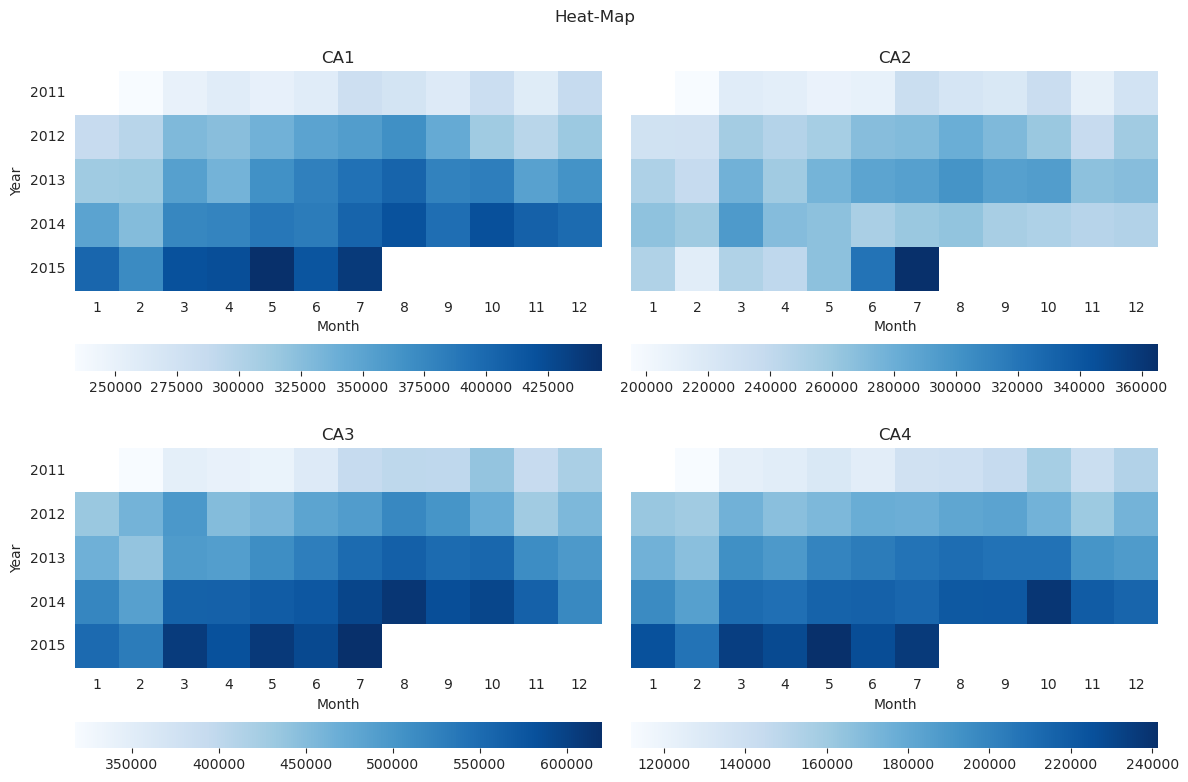

In [40]:
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharey=True)
p=pd.pivot_table(data=Train_ss[["store_id","Total_sales","Month","Year"]], 
                 index=["store_id","Year"],
                 columns="Month",
                 values="Total_sales")
k=0;
for i in range(2):
    for y in range(2):
        k=k+1
        t=sns.heatmap(p.loc["CA_"+str(k)],
                    square=True,
                    cmap='Blues',
                    ax=axes[i][y],
                    cbar=True,
                    cbar_kws={"orientation":"horizontal"});
        axes[i][y].set_title("CA"+str(k))
        axes[i][y].tick_params('y', labelrotation=0) 
        if y==1: axes[i][y].set_ylabel(None) 
# mappable = t.get_children()[0]
# plt.colorbar(mappable, ax =[axes[2][0],axes[2][1]],use_gridspec=True,orientation = 'horizontal')
fig.suptitle("Heat-Map")
fig.tight_layout()

You can generally see that shade gets darker between 7th Month (July) and 10th Month (October) for all the years. This confirms that sales peaks between July and October, and then decreases slightly. There is also smaller peak in sales which comes in 3rd month(March).



**Stacked Bar Graph-Each Month Share in Total Sales**

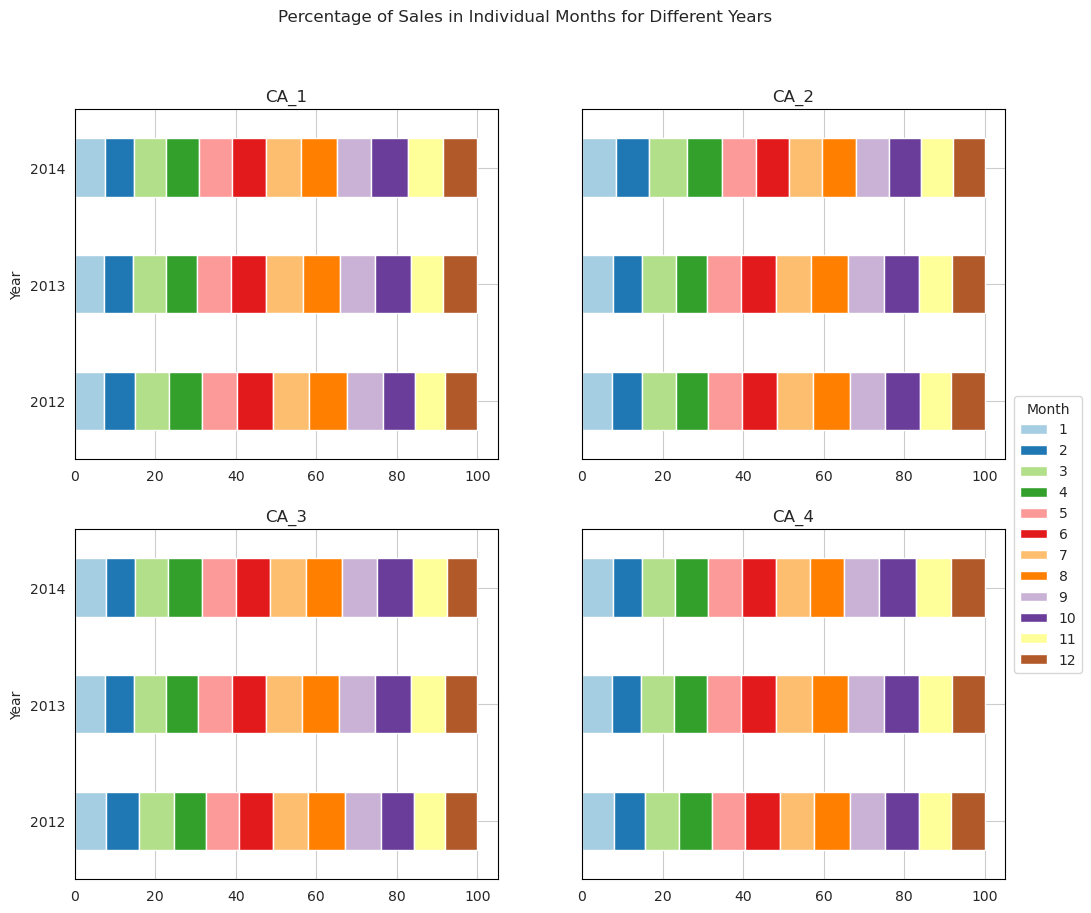

In [41]:
fig,ax=plt.subplots(figsize=(12,10),nrows=2,ncols=2,sharey=True)
for j in range(4): 
        sum_of_years=p.loc["CA_"+str(j+1)].loc[2012:2014].sum(axis=1)
        p_percentage=p.loc["CA_"+str(j+1)].loc[2012:2014].divide(sum_of_years,axis=0)*100
        p_percentage.plot(kind='barh', stacked=True, title="CA_"+str(j+1),ax=ax[int(j/2)][j%2],legend=False,colormap="Paired")
handles, labels = ax[0][0].get_legend_handles_labels()
fig.suptitle("Percentage of Sales in Individual Months for Different Years")
fig.legend(handles, labels,bbox_to_anchor=(0.97,0.6),title="Month")
plt.show()

The months between July to October contribute more to the total sales. Additionally, for CA2, the month of March also contributes more to the total annual sales. 

### Decomposition

1. **CA1**

[None, None]

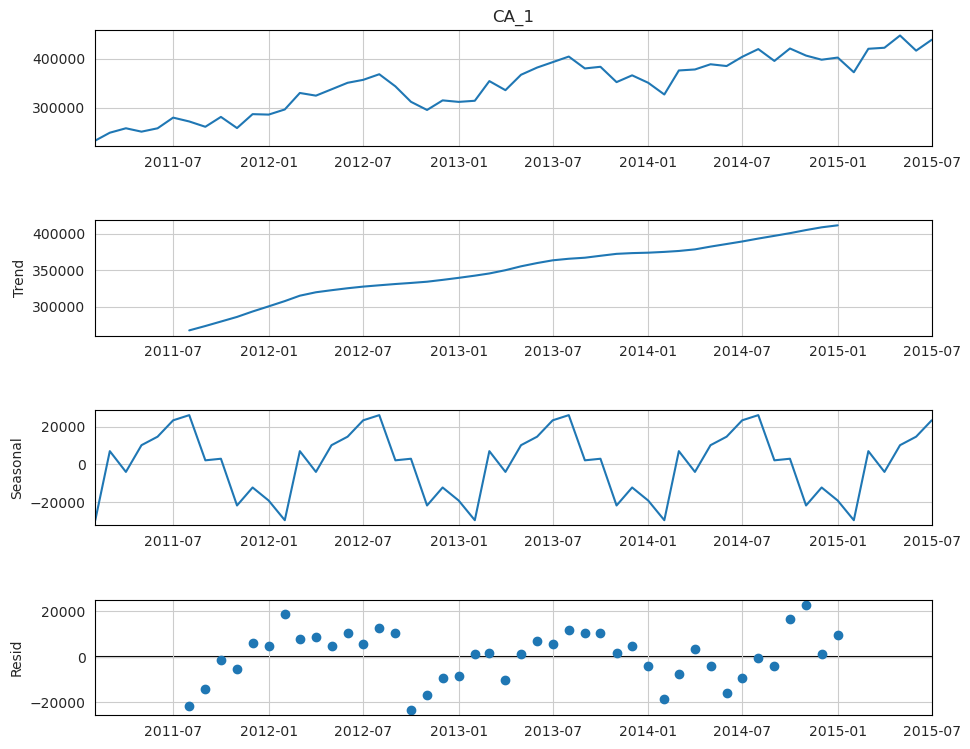

In [42]:
decompose_CA1 = seasonal_decompose(Train["CA_1"])
decompose_CA1.plot().set(figheight=8.1,figwidth=10.8)

In [43]:
ljung_p=np.mean(ljung(decompose_CA1.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.0014119461946460854 
Since p < 0.05 = True, The residuals are uncorelated


The trend is non-stationary and upwards. Seasonal pattern is consistent.

Residuals are un-corelated. Residuals are the differences between the observed data points and the values that are calculated by fitting the trend and seasonality. We want them to be uncorelated or i.i.d(Independent and Identically Distributed). If they show patterns, it means that there is some structural information that is left to be captured.

We have performed Ljung Box test to check whether they are i.i.d. Since the p-value < 0.05, We can say that residuals are uncorelated.

If the residuals are corelated, we may have to use external variable to explain that co relation.

2. **CA2**

[None, None]

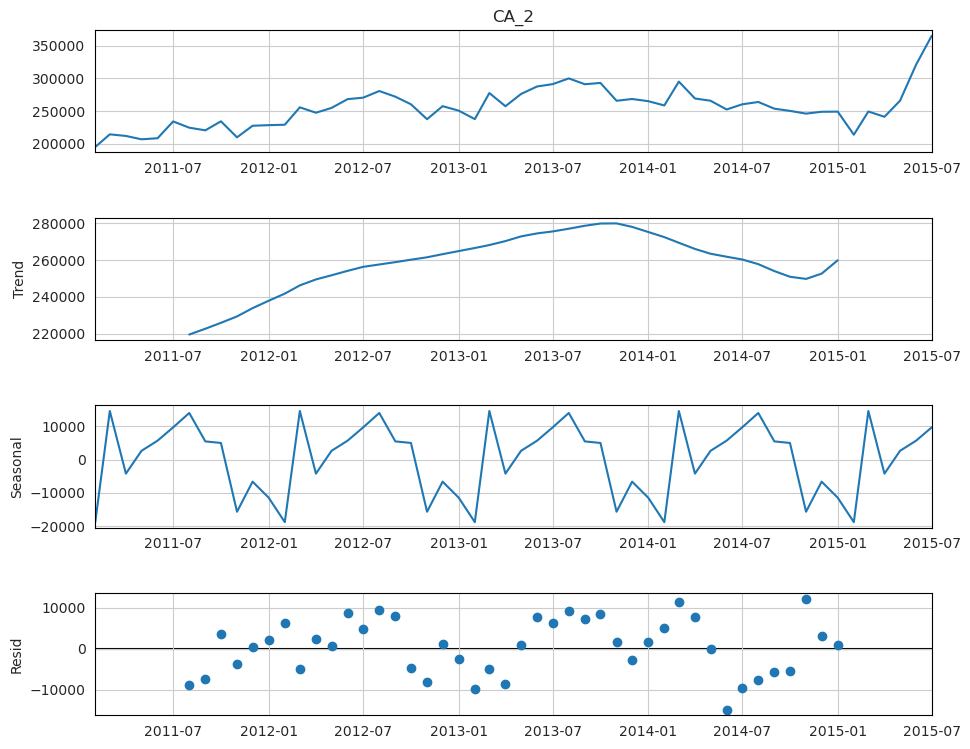

In [44]:
decompose_CA2 = seasonal_decompose(Train["CA_2"])
decompose_CA2.plot().set(figheight=8.1,figwidth=10.8)

In [45]:
ljung_p=np.mean(ljung(decompose_CA2.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.0029624633711648756 
Since p < 0.05 = True, The residuals are uncorelated


The trend is non-stationary. The trend increases first few years and then decreases after 2014 and then again increases slightly. This may indicate cyclic behaviour. Seasonal pattern is consistent.

Residuals are un-corelated.

3. **CA3**

[None, None]

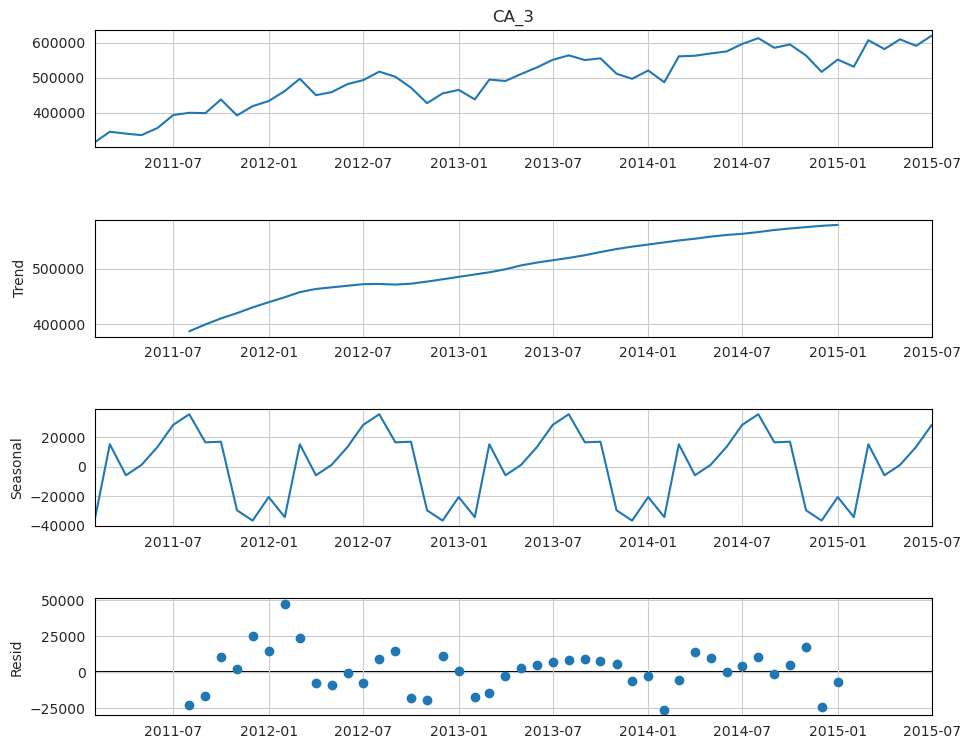

In [46]:
decompose_CA3 = seasonal_decompose(Train["CA_3"])
decompose_CA3.plot().set(figheight=8.1,figwidth=10.8)

In [47]:
ljung_p=np.mean(ljung(decompose_CA3.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.358477856604493 
Since p < 0.05 = False, The resisuals are co-related


The trend is non-stationary and upwards. Seasonal pattern is consistent.

Residuals are corelated. This is suggesting that we will have to use higher order models, or use external variable to explain the pattern in residuals

4. **CA4**

[None, None]

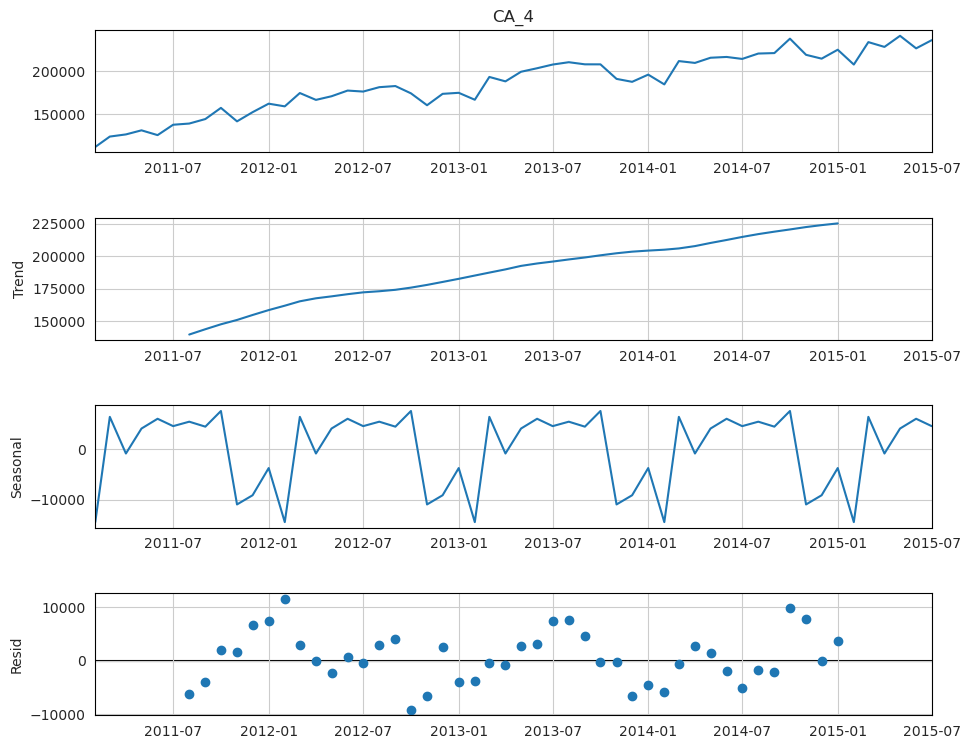

In [48]:
decompose_CA4 = seasonal_decompose(Train["CA_4"])
decompose_CA4.plot().set(figheight=8.1,figwidth=10.8)

In [49]:
ljung_p=np.mean(ljung(decompose_CA4.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.0038996983291655434 
Since p < 0.05 = True, The residuals are uncorelated


The trend is non-sttationary and upwards. Seasonal pattern is consistent.

Residuals are un-corelated

### Stationarity

1. **CA1**

Standard Deviation: 56545.0596070229


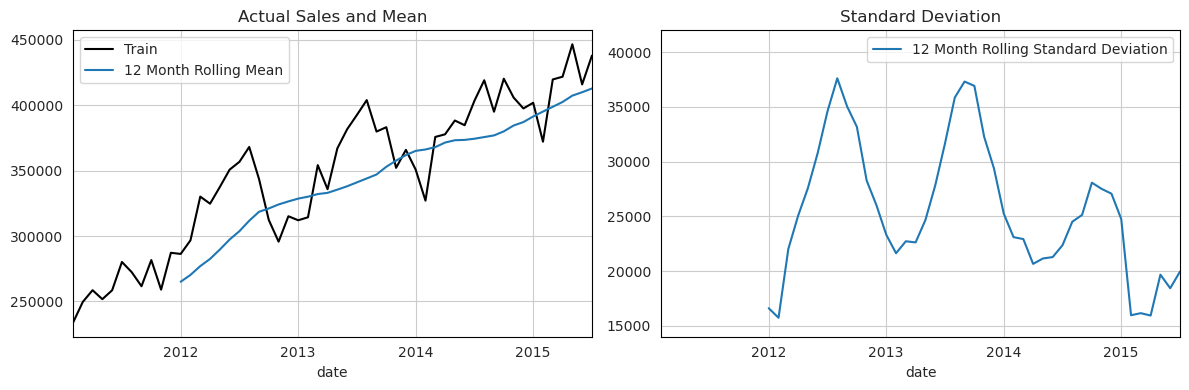

In [50]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["CA_1"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["CA_1"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["CA_1"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",ylim=(14000,42000),label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["CA_1"].std())

Mean is increasing , but standard deviation is decreasing year over year. 

Increasing mean indicates that series is not stationary, also as we move foward in time, variation in the total monthly sale is decreasing which is indicated by reducing standard deviation year over year.

In [51]:
print("Coefficient of Variation:",Train["CA_1"].std()/Train["CA_1"].mean())

Coefficient of Variation: 0.1631393146301216


**Coefficient of Variation**:
Coefficient of variation gives us an idea about the variability in the process, especially when looking at sales and demand. Note that this should be used for relative comparison and does not have a strict statistical defition. It's very common measure in demand planning and inventory analytics.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

This is over all a low variablility process.

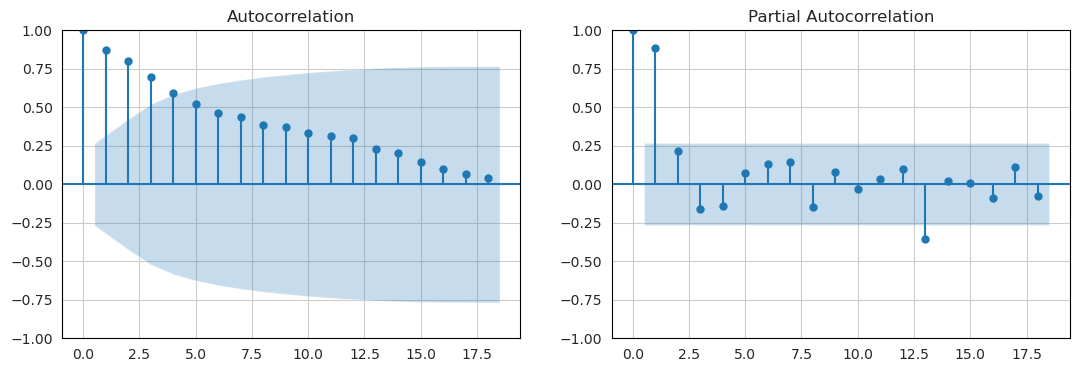

In [52]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["CA_1"],ax=ax1[0]);
plot_pacf(Train["CA_1"],ax=ax1[1]);

**ACF(Auto Corelation Function)** - It determines the correlation that is present between the current value and value at lag k.
If the corelation values are outside the blue band, means they are significant. 
We can see that sales in last 4 periods have significance in determining the sales in current period. 

**PACF(Partial Auto Corelation Function)**- PACF gives us corelation between current value and value at lag k after removing the effects of lags<k. The pacf here cuts off after one lag. This means that after lag 1, the pacf values fall inside the blue band. The values that fall inside the blue band are considered not significant. There is only one value that is little above significant band at lag 13. We can ignore it.


The ACF model is also tapering down which in combination with PACF plot cutting off after a number of lags indicates an Auto Regressive Process. 

These graph have significance in determining the order of ARIMA models. It requires much thorough study and experience to calculate ARIMA model parameters. 

Luckily for us , there are built in functions available which calculates parameters for one of the best arima models based on the data. Ww will be building ARIMA models we will be using those functions.


In [53]:
adf = adfuller(Train["CA_1"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.2654 , Series is Non-Stationary


We have used adfuller test to test whether series is stationary or not. Based on upward trend we have already stated that series is non stationary, however, this will confirm this.

In [54]:
adf2 = adfuller(Train["CA_1"].diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
adf2 = adfuller(Train["CA_1"].diff(1).diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")

p value:0.1305 , Series is Non-Stationary
p value:0.0 , Series is Stationary


We can make series stationary by differencing the series i.e subracting each value with one before or after. We may have to do this one or more time to make it stationary.

Funfact- This would be the 'd' parameter of the 3 parameters of ARIMA model i.e p,d,q. More about it later

2. **CA2**

Standard Deviation: 30762.858830483874


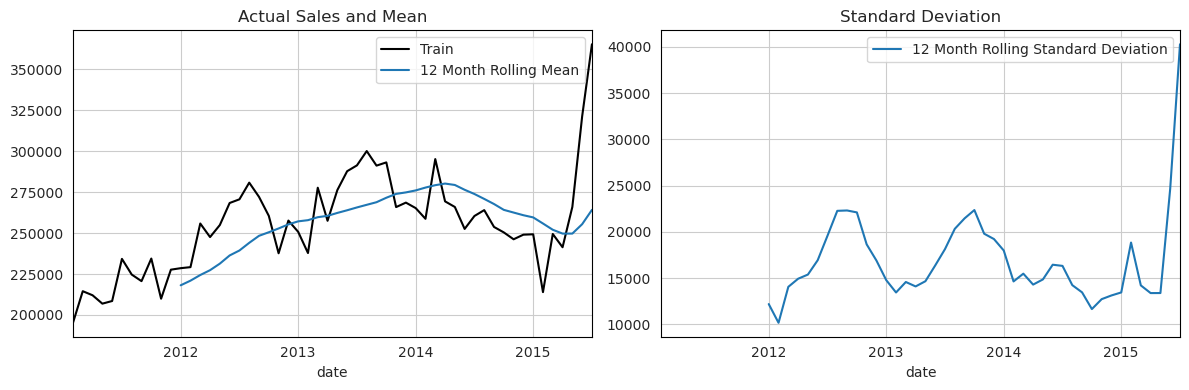

In [55]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["CA_2"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["CA_2"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["CA_2"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["CA_2"].std())

Mean is increasing initially but then starts to decrease.

Standard deviation is decreasing year over year, but at the very end there is spike in standard deviation. 

Non constant mean indicates that series is not stationary, also till 2015, variation in total monthly sale decreases, this changes after 2015 when there is sudden spike in Standard Deviation and total monthly sale varies much more. This can also be seen in the box plot of CA2.

In [56]:
print("Coefficient of Variation:",Train["CA_2"].std()/Train["CA_1"].mean())

Coefficient of Variation: 0.08875455681799314


This is a low variability process

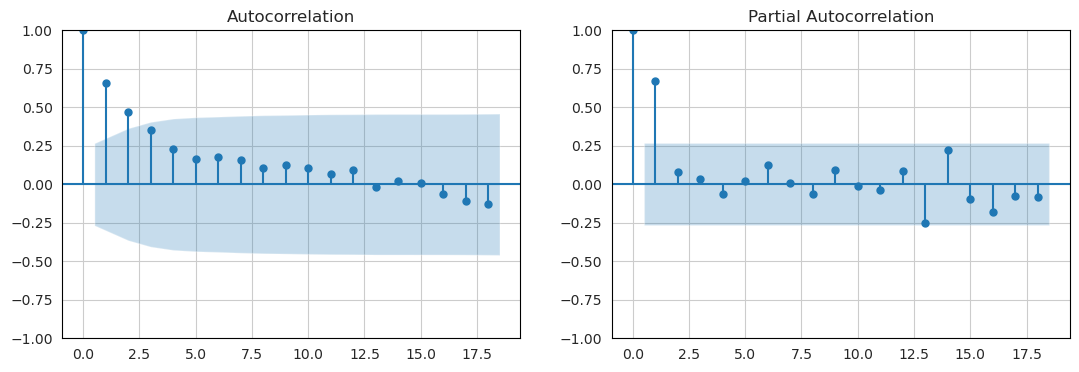

In [57]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["CA_2"],ax=ax1[0]);
plot_pacf(Train["CA_2"],ax=ax1[1]);

We can see that sales in last 2 periods have significance in determining the sales in current period.

The pacf here cuts off after one lag.

The ACF model is tapering down which in combination with PACF plot cutting off after a number of lags indicates an Auto Regressive Process

In [58]:
adf = adfuller(Train["CA_2"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.5276 , Series is Non-Stationary


2. **CA3**

Standard Deviation: 79672.3647539057


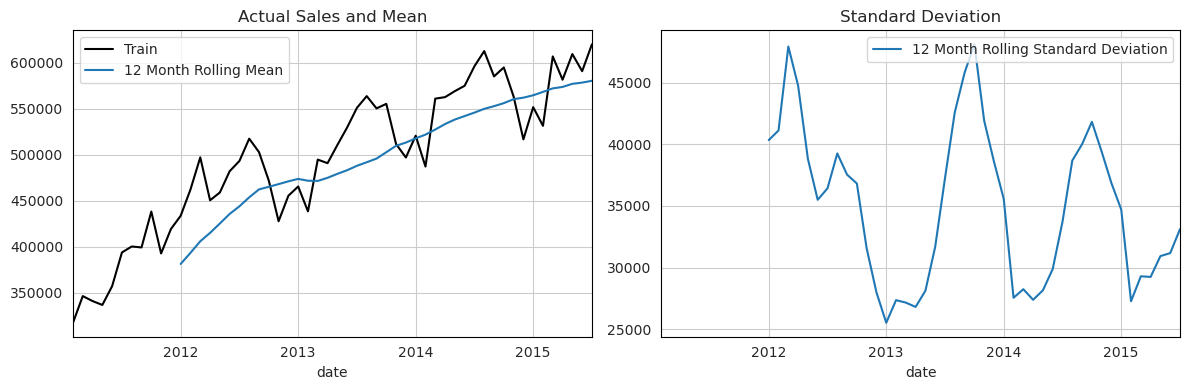

In [59]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["CA_3"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["CA_3"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["CA_3"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["CA_3"].std())

Mean is increasing , but standard deviation is decreasing year over year. 

Increasing mean indicates that series is not stationary, also as we move foward in time, variation in the total monthly sale is decreasing which is indicated by reducing standard deviation year over year.

In [60]:
print("Coefficient of Variation:",Train["CA_3"].std()/Train["CA_3"].mean())

Coefficient of Variation: 0.1605983240992905


This is a low variability process

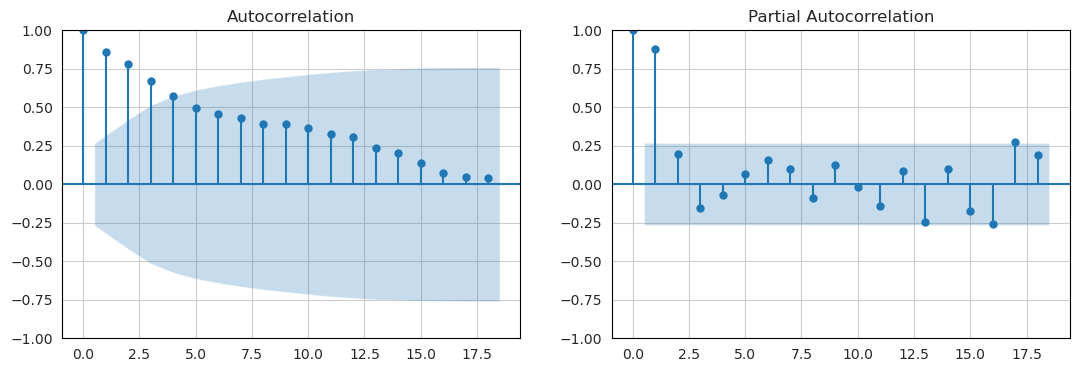

In [61]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["CA_3"],ax=ax1[0]);
plot_pacf(Train["CA_3"],ax=ax1[1]);

We can see that sales in the last 4 periods have significance in determining the sales in current period.

The pacf here cuts off after one lag.

The ACF model is tapering down which in combination with PACF plot cutting off after a number of lags indicates an Auto Regressive Process

In [62]:
adf = adfuller(Train["CA_3"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")


p value:0.1219 , Series is Non-Stationary


2. **CA4**

Standard Deviation: 33781.02481189229


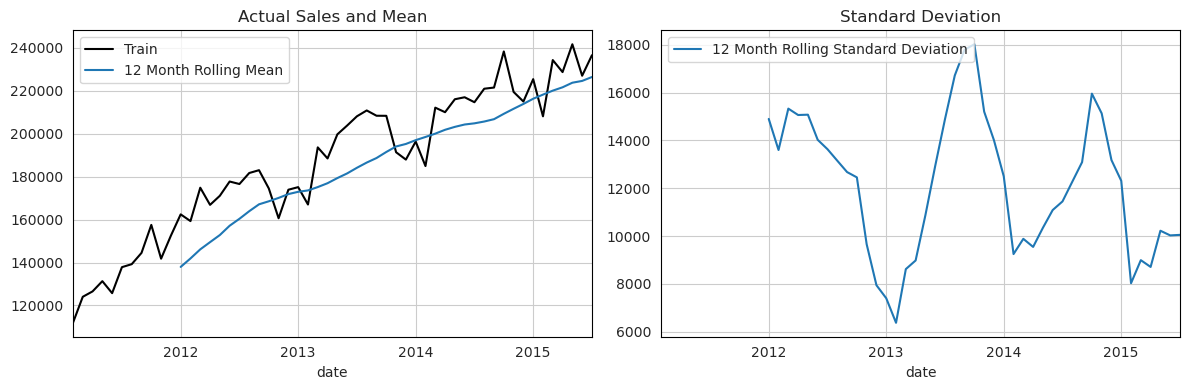

In [63]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["CA_4"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["CA_4"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["CA_4"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["CA_4"].std())

Mean is increasing , but standard deviation is decreasing year over year. 

Increasing mean indicates that series is not stationary, also as we move foward in time, variation in the total monthly sale is decreasing which is indicated by reducing standard deviation year over year.

In [64]:
print("Coefficient of Variation:",Train["CA_3"].std()/Train["CA_3"].mean())

Coefficient of Variation: 0.1605983240992905


This is a low variability process.

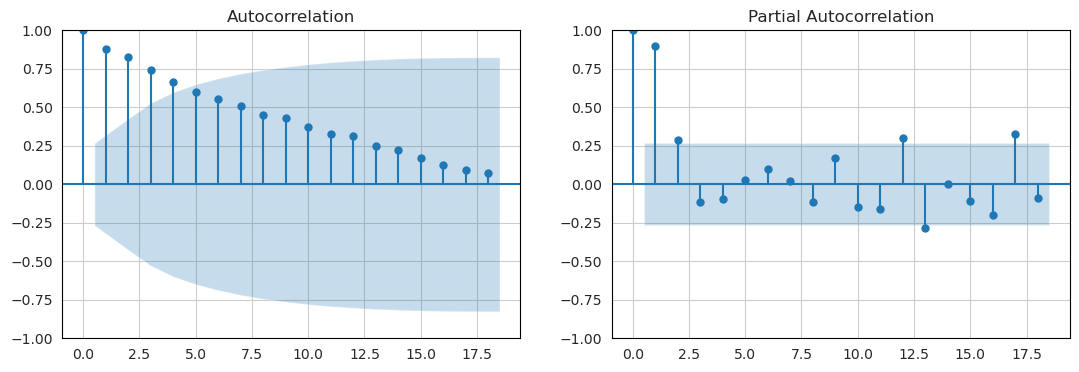

In [65]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["CA_4"],ax=ax1[0]);
plot_pacf(Train["CA_4"],ax=ax1[1]);

We can see that last 4 periods have significance in determining the sales in current period.

The pacf here cuts off after one lag.

The ACF model is tapering down which in combination with PACF plot cutting off after a number of lags indicates an Auto Regressive Process

In [66]:
adf = adfuller(Train["CA_4"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.2249 , Series is Non-Stationary


**Lag Plot**

Here we plot values in CA4 train dataset vs values at different lags. One thing you will observe is how the relationship gets weaker as number of lags increases. 

This is also the finding of ACF plot that corelation between values decreases as lags increases for our time series data

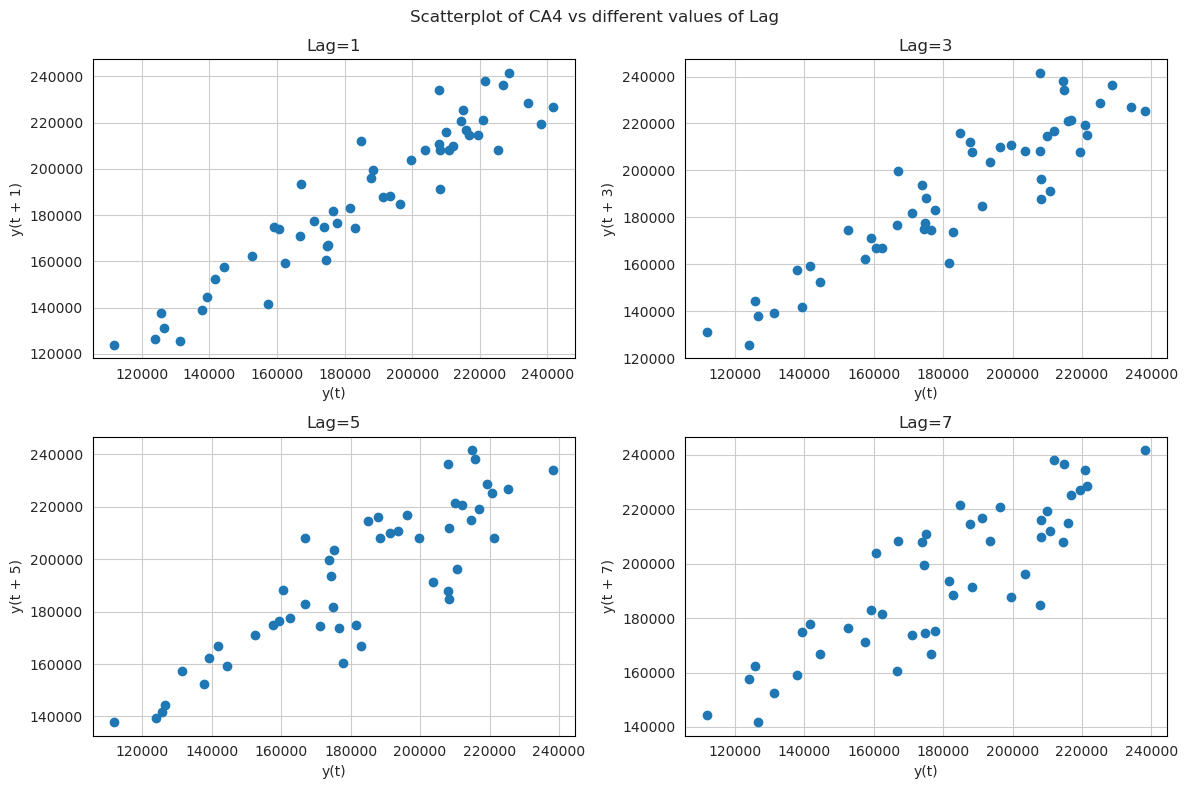

In [67]:
fig,ax=plt.subplots(figsize=(12,8),nrows=2,ncols=2)
fig.suptitle("Scatterplot of CA4 vs different values of Lag")
pd.plotting.lag_plot(Train["CA_4"],lag=1,ax=ax[0,0]).set_title("Lag=1")
pd.plotting.lag_plot(Train["CA_4"],lag=3,ax=ax[0,1]).set_title("Lag=3")
pd.plotting.lag_plot(Train["CA_4"],lag=5,ax=ax[1,0]).set_title("Lag=5")
pd.plotting.lag_plot(Train["CA_4"],lag=7,ax=ax[1,1]).set_title("Lag=7")
fig.tight_layout()

**Distribution Plot - Is Our Series Normal ?**

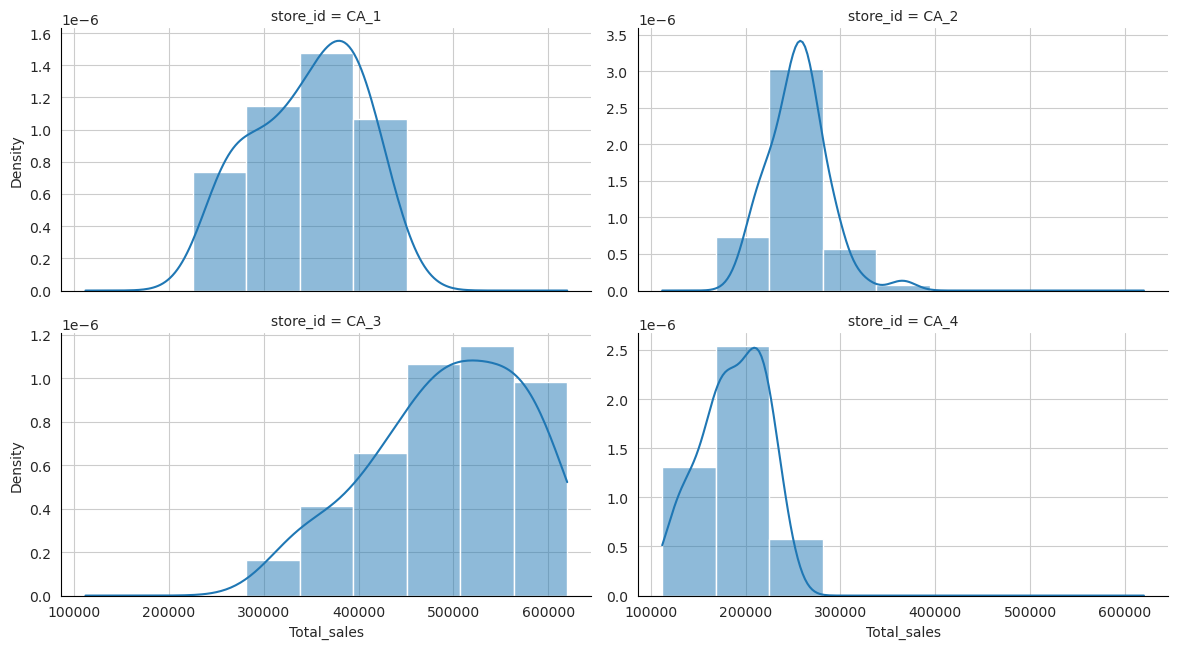

In [68]:
fg_obj=sns.displot(data=Train_ss[["store_id","Total_sales"]].reset_index(),
            x="Total_sales",
            kind="hist",
            col="store_id",
            col_wrap=2,
            facet_kws={"sharex":True,"sharey":False},
            kde=True,
            stat="density",
            legend=True,
            height=3.3,
            aspect=1.8).tight_layout()

In [69]:
is_norm=pd.DataFrame(columns=["store_id","jb_p_value","Distribution"])
for i in ["CA_1","CA_2","CA_3","CA_4"]:
    p_value=jb(Train[i])[1]
    is_norm=pd.concat([is_norm,
               pd.DataFrame([{"store_id":i,
                              "jb_p_value":p_value,
                              "Distribution":"Normal" if p_value>0.05 else "Not Normal"}]
                           )],
               ignore_index=True)
is_norm

store_id  jb_p_value Distribution
0     CA_1    0.228322       Normal
1     CA_2    0.003159   Not Normal
2     CA_3    0.255755       Normal
3     CA_4    0.266695       Normal

Series does not have to be Gaussian for accurate forecasting but if the data is highly skewed it can affect the model selection and forecast uncertainty.

We can use Box-Cox transformation to normalize our data.

Jarque Bera test shows the data if data is from normal distribution or not. 

p value of Jarque Bera test for CA1, CA3 and CA4 time series data show that they are normally distributed. 

Time Series data for store CA2 does not come from normal distribution according to Jarque Beta Test.

## Model Fitting and Selection

**Model Evaluation Functions**

Different metrics to calculate accuracy

MAPE(Mean Absolute Percent Error): This helps us to evaluates the accuracy of our model. The formula for this metric as follows:-
    $$ MAPE = \frac{\sum_{i=1}^N\frac{|ytrue_{i}-ypredicted_{i}|}{ytrue_{i}}}{N} * 100 $$

RMSE(Root Mean Square Error): This is another metric we will be using to caculate accuracy. Formula for this metric is as follows:

   $$ RMSE = \sqrt{\sum_{i=1}^n {(predicted_{i}-actual_{i})}^2} $$

**Residual Evaluation**

We will be checking whether residuals are normal, statinary, corelated using Jarque Bera Test, AdFuller Test, Ljung Box Test respectively.

We will also plot residuals, ACF and kde plot of residuals.

In [70]:
def MAPE(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    accuracy_df=pd.DataFrame()
    MAPE1=np.round(np.mean(np.abs(ytrue-ypred)/ytrue)*100,1)
    return MAPE1

def accuracy(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    MAPE1=MAPE(y_true,y_pred)
    rmse_r=np.round(rmse(ytrue,ypred),1)
    return pd.DataFrame({"RMSE":[rmse_r],"MAPE":[MAPE1]})

def residualcheck(residuals, lags):
    
    resid_mean=np.mean(residuals)
    ljp_valve=np.mean(ljung(x=residuals,lags=lags,return_df=False)[1])
    adfuller1=adfuller(residuals)[1]
    isnorm=jb(residuals)[1]
    
    fig = plt.figure(figsize=(8,6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals,ax=kde_ax);
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", ljp_valve, "(>0.05, Uncorrelated)" if (ljp_valve > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(isnorm,3), "(>0.05, Normal)" if (isnorm>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", adfuller1, "(>0.05, Non-stationary)" if (adfuller1 > 0.05) else "(<0.05, Stationary)")
    

    return ts_ax, acf_ax, kde_ax

### Seasonal Naive Forecast

This is the simplest method available for forecasting. 

In this forecasting technique, Forecast for a period in the current whole season would be equal to the value for same period in the last whole season. For e.g, The number of Ice Cream Baskin Robbins will be selling in May 2023 would be equal to the number of Ice Creams Baskin Robbins sold in May 2022. 

This is an different version of naive forecast in which we directly use sale value in last period as forecast for next period. 


In [71]:
Model_Performance=pd.DataFrame(columns=["store_id","Forecast Method","MAPE","RMSE"]) ### Creating an Intial Dataframe
store_list=["CA_1","CA_2","CA_3","CA_4"]

In [72]:
def snaive(train,seasons,forecast_horizon):
    if len(train)>forecast_horizon:
        last_season=train[-seasons:]
        reps=int(np.ceil(forecast_horizon/seasons))
        fc= np.tile(last_season,reps)
        forecast=fc[:forecast_horizon]
        fitted=train.shift(seasons)
        return forecast,fitted
    else:
        return "error"

In [73]:
predicted_naive=pd.DataFrame(columns=store_list)
fit_naive=pd.DataFrame(columns=store_list)
for i in store_list:
    forecast,fit=snaive(Train[i],12,9)
    predicted_naive[i]=forecast
    fit_naive[i]=fit
predicted_naive.set_index(Test.index,inplace=True)
fit_naive.set_index(Train.index,inplace=True)

In [74]:
predicted_naive

CA_1       CA_2       CA_3       CA_4
date                                                  
2015-08-01  419098.10  264035.22  612673.82  220844.17
2015-09-01  395068.14  253762.23  585175.08  221386.12
2015-10-01  420297.31  250413.34  594838.53  238182.06
2015-11-01  405900.76  246222.55  563257.29  219350.82
2015-12-01  397548.43  249040.70  516739.58  214884.48
2016-01-01  401896.85  249262.38  551716.76  225297.12
2016-02-01  372124.43  213945.75  531428.27  208000.89
2016-03-01  419717.12  249461.77  606867.62  234171.52
2016-04-01  421798.93  241357.14  581569.73  228579.43

In [75]:
fit_naive

CA_1       CA_2       CA_3       CA_4
date                                                  
2011-02-01        NaN        NaN        NaN        NaN
2011-03-01        NaN        NaN        NaN        NaN
2011-04-01        NaN        NaN        NaN        NaN
2011-05-01        NaN        NaN        NaN        NaN
2011-06-01        NaN        NaN        NaN        NaN
2011-07-01        NaN        NaN        NaN        NaN
2011-08-01        NaN        NaN        NaN        NaN
2011-09-01        NaN        NaN        NaN        NaN
2011-10-01        NaN        NaN        NaN        NaN
2011-11-01        NaN        NaN        NaN        NaN
2011-12-01        NaN        NaN        NaN        NaN
2012-01-01        NaN        NaN        NaN        NaN
2012-02-01  233687.91  195198.60  317303.99  111950.99
2012-03-01  249606.68  214501.18  346333.56  124044.35
2012-04-01  258612.43  212021.00  340933.48  126554.20
2012-05-01  251748.36  206895.86  336697.87  131316.99
2012-06-01  258554.34  208507.40  357152.12  125735.36
2012-07-01  280188.47  234248.92  393757.48  137835.21
2012-08-01  272393.61  224669.95  400253.94  139225.95
2012-09-01  261630.33  220642.30  399237.83  144473.33
2012-10-01  281640.68  234442.27  438208.97  157491.16
2012-11-01  259038.11  209913.73  392671.16  141778.64
2012-12-01  287223.34  227654.36  419171.32  152488.99
2013-01-01  286321.47  228563.63  433668.46  162395.75
2013-02-01  296746.21  229196.43  462189.75  159262.81
2013-03-01  330146.56  255864.24  497135.40  174798.35
2013-04-01  324738.96  247563.09  450480.23  166813.33
2013-05-01  337522.50  254932.66  458923.20  171040.13
2013-06-01  350788.50  268388.91  482053.18  177674.12
2013-07-01  356742.64  270639.60  493218.68  176511.96
2013-08-01  368107.42  280819.44  517452.65  181629.04
2013-09-01  343586.14  272123.70  502799.98  182947.58
2013-10-01  312261.11  260522.40  471800.86  174445.65
2013-11-01  295714.38  237668.19  427734.31  160580.52
2013-12-01  315136.77  257648.67  455418.30  173855.95
2014-01-01  312071.78  250757.83  465475.02  175063.70
2014-02-01  314348.81  237818.67  438403.27  166973.62
2014-03-01  354218.82  277728.91  494695.83  193558.34
2014-04-01  335808.18  257521.53  490820.93  188406.42
2014-05-01  367038.32  276288.12  510531.87  199616.76
2014-06-01  381662.86  287811.29  529642.93  203715.68
2014-07-01  392592.58  291367.85  550960.10  208019.60
2014-08-01  403923.89  300115.99  563727.69  210735.37
2014-09-01  379880.14  291223.50  550378.50  208274.99
2014-10-01  383221.07  293196.06  555296.18  208241.77
2014-11-01  352145.62  265892.47  511512.66  191292.95
2014-12-01  365881.21  268621.70  496978.64  187869.59
2015-01-01  350776.28  265271.42  520680.29  196262.73
2015-02-01  327072.85  258729.79  487137.12  184870.88
2015-03-01  375769.03  295227.49  560978.88  212045.29
2015-04-01  377772.75  269385.70  562607.03  209921.33
2015-05-01  388327.79  265958.72  569139.52  215946.77
2015-06-01  384728.98  252546.15  574935.50  216873.48
2015-07-01  403406.77  260446.77  596181.60  214564.10

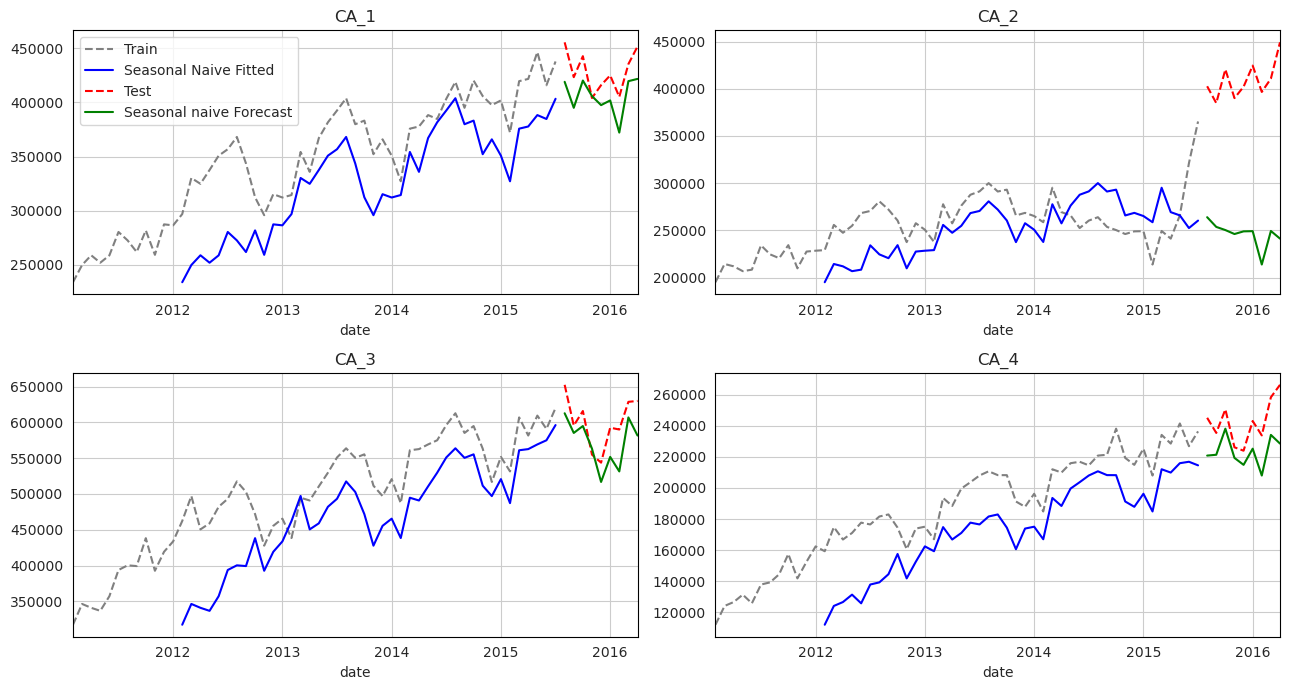

In [76]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_naive["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Seasonal Naive Fitted",ax=axs).set_title(store_list[i])
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs).set_title(store_list[i])
    predicted_naive["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Seasonal naive Forecast",ax=axs).set_title(store_list[i]);
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()


In [77]:
for i in store_list:
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":"Seasonal Naive",
                  "MAPE":accuracy(Test[i],predicted_naive[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_naive[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [78]:
Model_Performance

store_id Forecast Method  MAPE      RMSE
0     CA_1  Seasonal Naive   5.4   25314.8
1     CA_2  Seasonal Naive  39.6  164229.7
2     CA_3  Seasonal Naive   5.1   34676.5
3     CA_4  Seasonal Naive   7.8   21282.6

The forecast for CA1, CA3 and CA4 are able to catch the trend and seasonality to some extend.  But for CA2 the error in forecast is quite large.

MAPE in the range of 5.4% to 7.1% is quite low when we consider the simplicity of this model. 

For CA2 as there is sudden spike in sales, the model is not able to predict it

RMSE for CA1, CA3 and CA4 is less than the standard deviation of 56545.06, 79672.36 and 33781.02 for those stores respectively.

There is underfitting in prediction (Forecast being less than the actual value). However, that can be solved by adding the mean of error back to forecast. 

In [79]:
residual_naive=[(Train[i]-fit_naive[i]).dropna() for i in store_list]


 Store Name CA_1
** Mean of the residuals:  42221.23

** Ljung Box Test, p-value: 2.5329639694110936e-08 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.222 (>0.05, Normal)

** AD Fuller, p_value: 0.13333060433648092 (>0.05, Non-stationary)


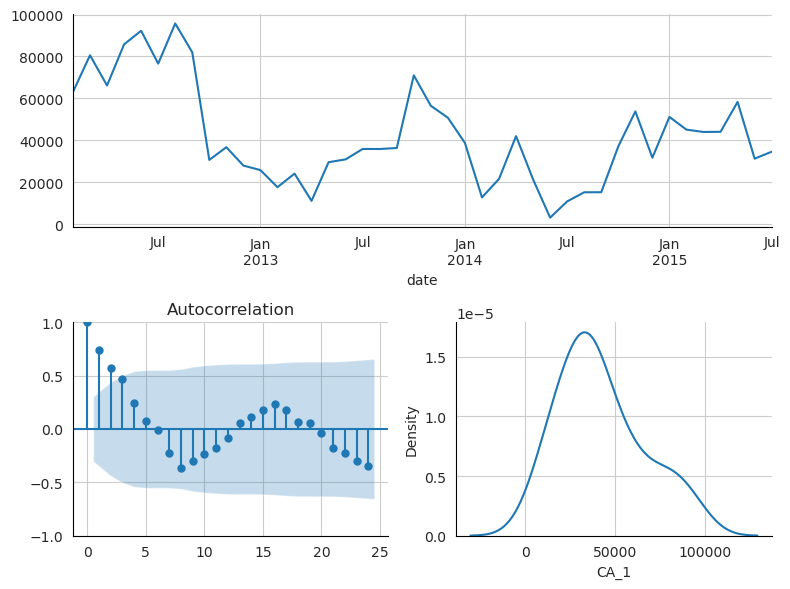


 Store Name CA_2
** Mean of the residuals:  13164.13

** Ljung Box Test, p-value: 1.0534490959908164e-06 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.984 (>0.05, Normal)

** AD Fuller, p_value: 0.47535131949749926 (>0.05, Non-stationary)


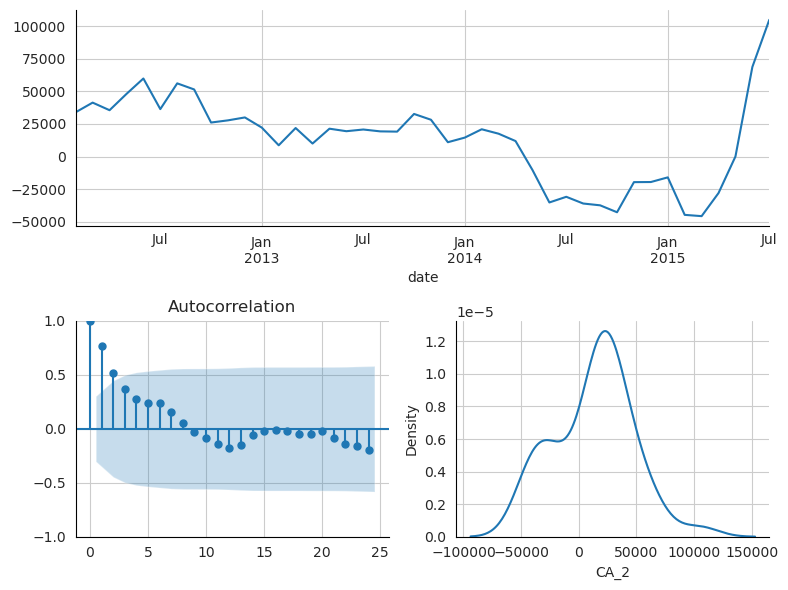


 Store Name CA_3
** Mean of the residuals:  56885.09

** Ljung Box Test, p-value: 2.7839058618955486e-08 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.126 (>0.05, Normal)

** AD Fuller, p_value: 0.0696585866092228 (>0.05, Non-stationary)


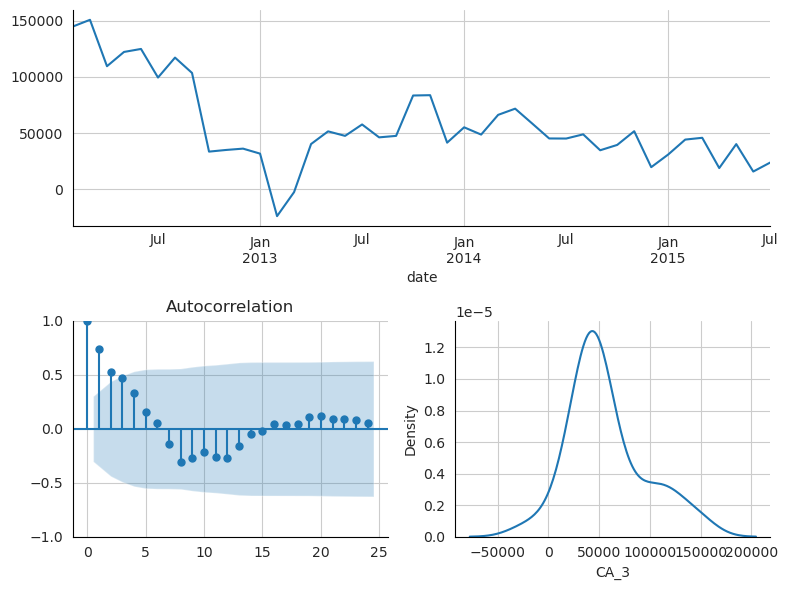


 Store Name CA_4
** Mean of the residuals:  25244.22

** Ljung Box Test, p-value: 3.0002687254886094e-07 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.287 (>0.05, Normal)

** AD Fuller, p_value: 0.052072188764350026 (>0.05, Non-stationary)


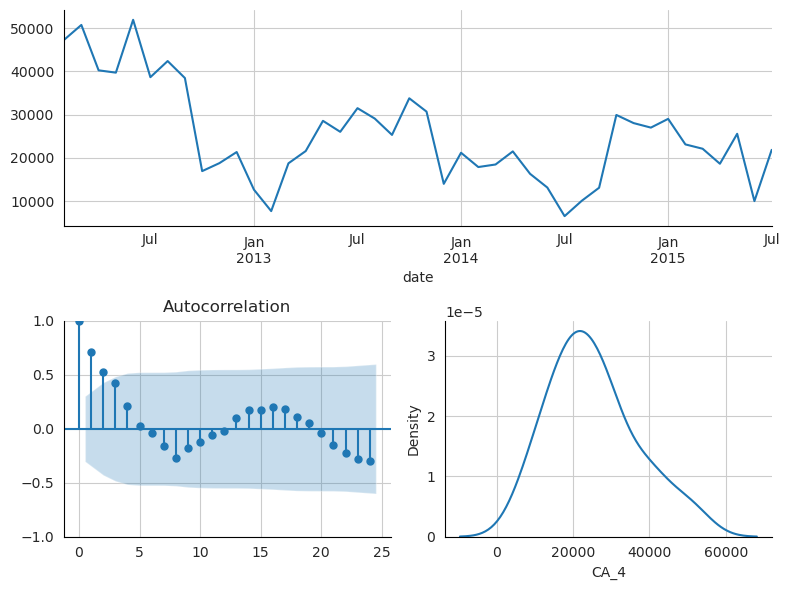

In [80]:
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(residual_naive[i],24);
    plt.show()

The residuals are Corelated, Non Stationary and Normal for all the stores. 

This means that there is some structured information in the residuals which was not extracted. The trend and seasonality has not been captured completely. 

This is not a useful model on its own but we can use Seasonal Naive model in combination with other models to improve our accuracy.

### HoltsWinter Exponential Smoothing Model

This is forecasting method that is in use for decades. It still extensively used today. It is also called Triple Exponetial Smoothing method because it tries to estimate three smoothing parameters alpha,beta and gamma for three components of time series i.e Level,Trend and Seasonality. 

- Level: Level is the average value around which time series varies in a full season. Alpha is the smoothing factor for level and tells the model how much of the past we have to give importance. It has value between 0 and 1. If the value of alpha is 1 then only last data point is used in caculating the forecast and if it is near 0 then all the past data points would have some effect on the forecast.

- Trend: Trend is the change in base level or average level over time. Trend can be additive or multiplicative. Additive trend means that base level increases linearly where as in multiplicative trend the base level increases exponentially. Beta is the smoothing factor for Trend, and it tells us how much of past trend in time series data model will be consider while making the forecast. If trend value is closer to 1 then only recent trend will be consider in making the forecast. We can also have damping parameter(phi) for trend which tells model to forget particular amount of recent trend.

- Seasonality: Seasonality is the number of periods in full season. For example, Monthly seasonality in Annual Data is 12, Weekly sesonality of annual data would be 52, Hourly seasonality for daily data is 24, Daily seasonality for weekly data would be 7. Gamma is the smoothing factor for seasonality. Seasonality can also be multiplicative or additive. 
        - In additive seasonality, we will add the seasonal factor while making forecast, for e.g for a particular store in may month we usually get 300K worth extra sales as compared to average. So we will add 300K worth of extra sales to the average level.
        - In multiplicative seasonality we will multiply with seasonal factor, for e.g, for a particular store in july month we usually we get 15% less sale as compared to average. So we will multiply average sale with (1-0.15) while making forecast. 


We will be using ExponentialSmoothing() from statsmodels.tsa.holtwinters package for calculating the best values for these three smoothing parameters for our time series data and then building a model using those parameters.

A more thorough explanation for Holts Winter method can be found in this medium [article](https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6).


In [81]:
def HoltsWinterGrid(train,test,seasonal_periods):
    trend=["add","mul"]
    seasonal=["add","mul"]
    damped=[False,True]
    use_boxcox=[True,False,"log"]
    
    params=itertools.product(trend,seasonal,damped,use_boxcox)
    result_df=pd.DataFrame(columns=["Trend","Seasonal","Damped","Box_Cox","AICc_Train","MAPE_Train",
                                   "RMSE_Train","MAPE_Test","RMSE_Test","lj_residual","jb_norm_residual",
                                   "resid_mean"])
    
    for trend,seasonal,damped,boxcox in params:
        if boxcox!="log":
            model=ExponentialSmoothing(train,
                                       trend=trend,
                                       seasonal=seasonal,
                                       damped_trend=damped,
                                       seasonal_periods=seasonal_periods,
                                       use_boxcox=boxcox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            MAPE_Train=MAPE(train,model.fittedvalues)
            rmse_train=rmse(train,model.fittedvalues)

            MAPE_Test=MAPE(test,model.forecast(len(test)))
            rmse_test=rmse(test,model.forecast(len(test)))
            resid=model.resid
            
        else:
            trainlog=np.log(train)
            model=ExponentialSmoothing(trainlog,
                                   trend=trend,
                                   seasonal=seasonal,
                                   damped_trend=damped,
                                   seasonal_periods=seasonal_periods,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
        
            MAPE_Train=MAPE(train,np.exp(model.fittedvalues))
            rmse_train=rmse(train,np.exp(model.fittedvalues))
        
            MAPE_Test=MAPE(test,np.exp(model.forecast(len(test))))
            rmse_test=rmse(test,np.exp(model.forecast(len(test))))
            resid=train-np.exp(model.fittedvalues)
        
        
        ljp_p_val=np.mean(ljung(resid,lags=20,return_df=False)[1])
        norm_p=jb(resid)[1]
        lj_residual="Uncorrelated" if ljp_p_val>0.05 else "Corelated"
        norm_p="Normal" if norm_p>0.05 else "Not Normal"
       
        Aicc=model.aicc.round(1)
        
        result_df = pd.concat([result_df,
                              pd.DataFrame({
                                  'Trend':[trend],
                                  'Seasonal': [seasonal],
                                  'Damped':[damped],
                                  'Box_Cox':[boxcox],
                                  'MAPE_Train':[np.round(MAPE_Train,2)],
                                  'RMSE_Train':[np.round(rmse_train,1)],
                                  'AICc_Train':[Aicc],
                                  'MAPE_Test':[np.round(MAPE_Test,2)],
                                  'RMSE_Test':[np.round(rmse_test,1)],
                                  'lj_residual' :[lj_residual],
                                  'jb_norm_residual':[norm_p],
                                  'resid_mean':[np.round(resid.mean(),1)]})] ,
                              ignore_index=True, 
                              sort=False)
            
    return result_df.sort_values(by=["RMSE_Test","MAPE_Test","RMSE_Train","MAPE_Train"])#.style.format({"MAPE_Train":"{:24,.2f}%","MAPE_Test":"{:24,.2f}%"}).highlight_min(subset=["AICc_Train","MAPE_Train","RMSE_Train","MAPE_Test","RMSE_Test"],color='lightgreen')

**HWGrid**:

We will loop through different combination of values that different arguements of ExponentialSmoothing function can take. For e.g Trend can be additive or multiplicative, we can use boxcox transformation for normalizing our data or we can also use log of our values to reduce the complexity of model(This results in less AICc and more efficient model as you will observe when you read further),seasonal can also be additive or multiplicative.

We have prepared HWgrid function to loop through each combination and give the accuracy as well as AICc.  

The AICc tries to give us the best model based on two parameters,i.e, fit of the model and the number of parameters. Lower the AICc for different models trained using the same dataset, more efficient the model is. **We are going to select the model with the lowest RMSE, but if two models have almost the same RMSE, then model with lower AIcc would be preferred.**

As model fits better AICc decreases but also as the number of parameters increases AICc also increases. 

In [82]:
HW_model_all=pd.DataFrame()
HW_model_best=pd.DataFrame()
for i,j in enumerate(store_list):
    temp2=HoltsWinterGrid(Train[j], Test[j], seasonal_periods=12)
    temp2["store_id"]=j
    HW_model_all=pd.concat([HW_model_all,temp2],ignore_index=True)
    HW_model_best=pd.concat([HW_model_best,temp2.head(1)],ignore_index=True)

In [83]:
HW_model_all[HW_model_all["store_id"]=="CA_2"]

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
24   mul      add  False    True      1069.9         3.2     12451.8   
25   add      mul  False    True      1063.7         3.3     11756.2   
26   mul      add  False     log      -289.4         3.2     11272.1   
27   add      mul   True    True      1068.9         3.4     11792.7   
28   add      add  False     log      -289.4         3.2     11271.6   
29   mul      mul  False    True      1067.5         3.2     12176.3   
30   add      add  False    True      1067.5         3.2     12174.2   
31   add      add   True     log      -284.4         3.2     11297.4   
32   add      add   True    True      1070.1         3.2     11928.1   
33   add      mul   True   False      1073.4         3.6     12301.6   
34   add      mul  False   False      1068.8         3.6     12319.5   
35   add      add   True   False      1076.0         3.7     12591.2   
36   add      add  False   False      1071.3         3.7     12611.2   
37   mul      mul   True   False      1071.7         3.5     12108.7   
38   mul      mul  False   False      1067.1         3.5     12125.2   
39   mul      add  False   False      1069.7         3.7     12418.5   
40   mul      add   True   False      1074.4         3.7     12408.2   
41   mul      add   True     log        22.7       107.8    275319.7   
42   mul      mul   True    True      1070.2         3.2     11938.8   
43   add      mul  False     log         NaN         NaN         NaN   
44   add      mul   True     log         NaN         NaN         NaN   
45   mul      add   True    True         NaN         NaN         NaN   
46   mul      mul  False     log         NaN         NaN         NaN   
47   mul      mul   True     log         NaN         NaN         NaN   

       MAPE_Test     RMSE_Test   lj_residual jb_norm_residual  resid_mean  \
24  1.190000e+01  5.422720e+04  Uncorrelated       Not Normal       969.4   
25  1.370000e+01  6.021800e+04  Uncorrelated       Not Normal       687.0   
26  1.400000e+01  6.170640e+04  Uncorrelated       Not Normal       165.8   
27  1.410000e+01  6.185730e+04  Uncorrelated       Not Normal       209.3   
28  1.410000e+01  6.211320e+04  Uncorrelated       Not Normal       160.2   
29  1.420000e+01  6.342000e+04  Uncorrelated       Not Normal      1752.0   
30  1.420000e+01  6.348170e+04  Uncorrelated       Not Normal      1762.9   
31  1.480000e+01  6.496730e+04  Uncorrelated       Not Normal       255.5   
32  1.580000e+01  6.942670e+04  Uncorrelated       Not Normal      1845.0   
33  3.200000e+01  1.576506e+05  Uncorrelated       Not Normal      1335.9   
34  3.400000e+01  1.677964e+05  Uncorrelated       Not Normal      1315.0   
35  3.850000e+01  1.855036e+05  Uncorrelated           Normal      1320.3   
36  3.850000e+01  1.868083e+05  Uncorrelated           Normal      1290.9   
37  6.020000e+01  3.107127e+05  Uncorrelated       Not Normal       988.0   
38  6.530000e+01  3.396182e+05  Uncorrelated       Not Normal       958.5   
39  7.980000e+01  4.109070e+05  Uncorrelated       Not Normal       942.7   
40  8.370000e+01  4.280254e+05  Uncorrelated           Normal       896.3   
41  1.143506e+09  4.732804e+12     Corelated           Normal   -273420.6   
42           NaN           NaN  Uncorrelated       Not Normal      2006.3   
43           NaN           NaN     Corelated       Not Normal         NaN   
44           NaN           NaN     Corelated       Not Normal         NaN   
45           NaN           NaN     Corelated       Not Normal         NaN   
46           NaN           NaN     Corelated       Not Normal         NaN   
47           NaN           NaN     Corelated       Not Normal         NaN   

   store_id  
24     CA_2  
25     CA_2  
26     CA_2  
27     CA_2  
28     CA_2  
29     CA_2  
30     CA_2  
31     CA_2  
32     CA_2  
33     CA_2  
34     CA_2  
35     CA_2  
36     CA_2  
37     CA_2  
38     CA_2  
39     CA_2  
40     CA_2  
41     CA_2  
42     CA_

Above are the results for models with different parameters for store CA2. 

The RMSE of 54227 and MAPE Test of 11.9% is very less when compared to seasonal naive forecast which had an RMSE of 164229.7 and MAPE test of 39%. This shows that model was able to capture Trend and seasonality more precintly than seasonal naive model.

One more thing to observe here is the low AICC we get when we use log transformation. The RMSE Test only slightly increases for CA2 from 54227 to 57115. MAPE test is actually smaller. So we can give preference to this model because we get massive decrease in AICc score after trading sligthly for accuracy.

In [84]:
HW_model_best=HW_model_best.set_index("store_id")
HW_model_best

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
store_id                                                                     
CA_1       mul      add  False     log      -312.1         2.6     11757.9   
CA_2       mul      add  False    True      1069.9         3.2     12451.8   
CA_3       mul      mul  False   False      1115.4         2.8     18960.7   
CA_4       add      add  False     log      -332.0         2.2      5217.0   

          MAPE_Test  RMSE_Test   lj_residual jb_norm_residual  resid_mean  
store_id                                                                   
CA_1            1.6     9057.5  Uncorrelated       Not Normal      -160.9  
CA_2           11.9    54227.2  Uncorrelated       Not Normal       969.4  
CA_3            2.3    16106.3  Uncorrelated           Normal     -3600.4  
CA_4            1.9     5833.4  Uncorrelated           Normal      -229.7

These are the best Holts Winter Exponential smoothing model selected for each store based on RMSE Test values. We will predict the values using these Holts Winter model for each store. Then we will plot them to see how well they fit.

In [85]:
predicted_HW=pd.DataFrame(columns=store_list)
fit_HW=pd.DataFrame(columns=store_list)
for i in store_list:
    if HW_model_best.loc[i].Box_Cox!="log":
            model=ExponentialSmoothing(Train[i],
                                       trend=HW_model_best.loc[i].Trend,
                                       seasonal=HW_model_best.loc[i].Seasonal,
                                       damped_trend=HW_model_best.loc[i].Damped,
                                       seasonal_periods=12,
                                       use_boxcox=HW_model_best.loc[i].Box_Cox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            fit_HW[i]=model.fittedvalues
            predicted_HW[i]=model.forecast(len(Test))
            
    else:
            model=ExponentialSmoothing(np.log(Train[i]),
                                   trend=HW_model_best.loc[i].Trend,
                                   seasonal=HW_model_best.loc[i].Seasonal,
                                   damped_trend=HW_model_best.loc[i].Damped,
                                   seasonal_periods=12,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
            fit_HW[i]=np.exp(model.fittedvalues)
            predicted_HW[i]=np.exp(model.forecast(len(Test)))

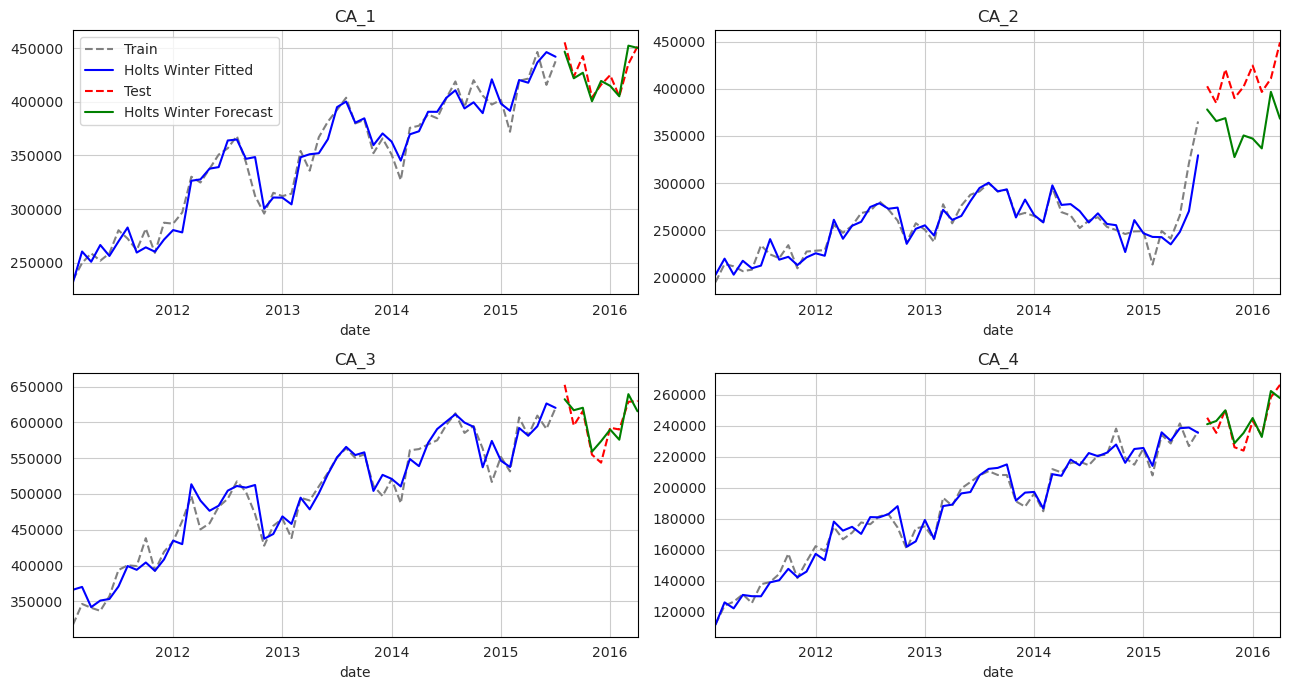

In [86]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_HW["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Holts Winter Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_HW["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Holts Winter Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

The seasonality and trend has been captured quite accurately for CA1, CA3 and CA4. For CA2, predicted values and test values are nearer to each other but there is underfitting in data.


 Store Name CA_1
** Mean of the residuals:  -160.87

** Ljung Box Test, p-value: 0.33911646687983404 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.029 (<0.05, Not-normal)

** AD Fuller, p_value: 0.001174603737384009 (<0.05, Stationary)


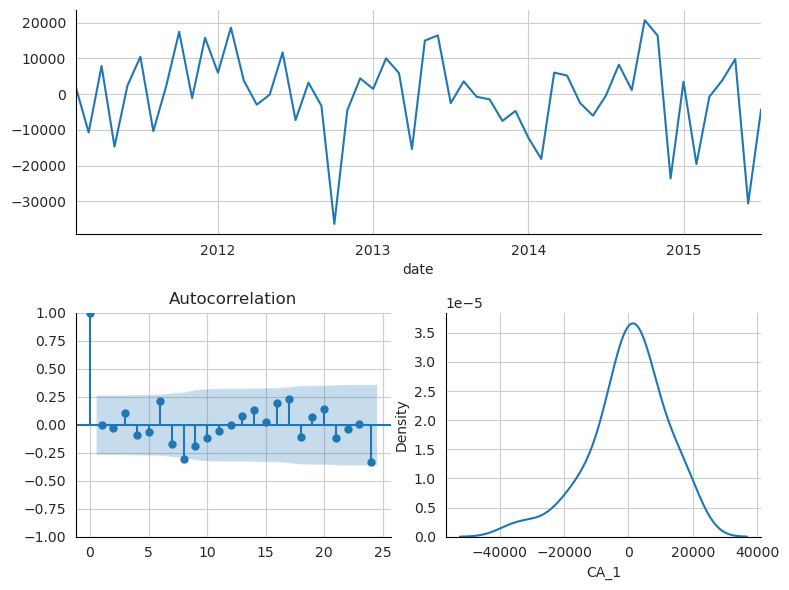


 Store Name CA_2
** Mean of the residuals:  969.38

** Ljung Box Test, p-value: 0.5612631619324108 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.2605410198813497 (>0.05, Non-stationary)


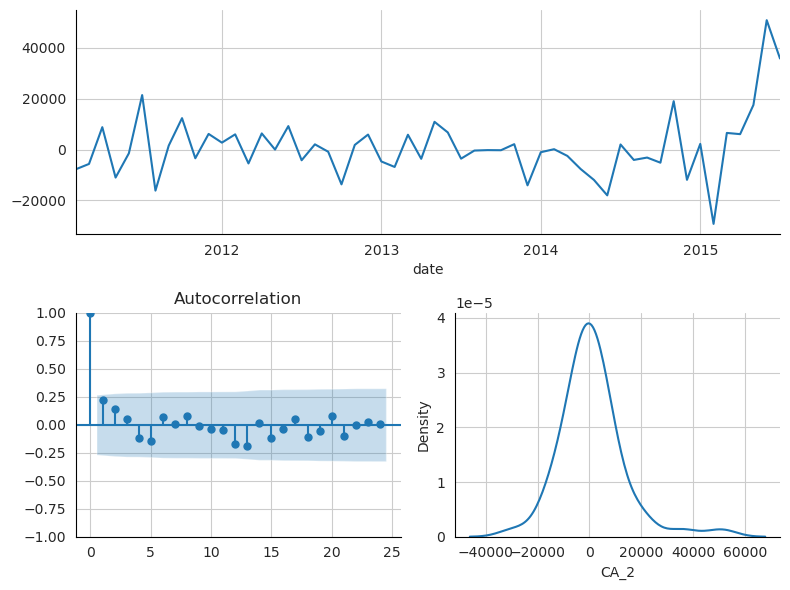


 Store Name CA_3
** Mean of the residuals:  -3600.42

** Ljung Box Test, p-value: 0.6474385003166879 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.078 (>0.05, Normal)

** AD Fuller, p_value: 1.5026041884388845e-11 (<0.05, Stationary)


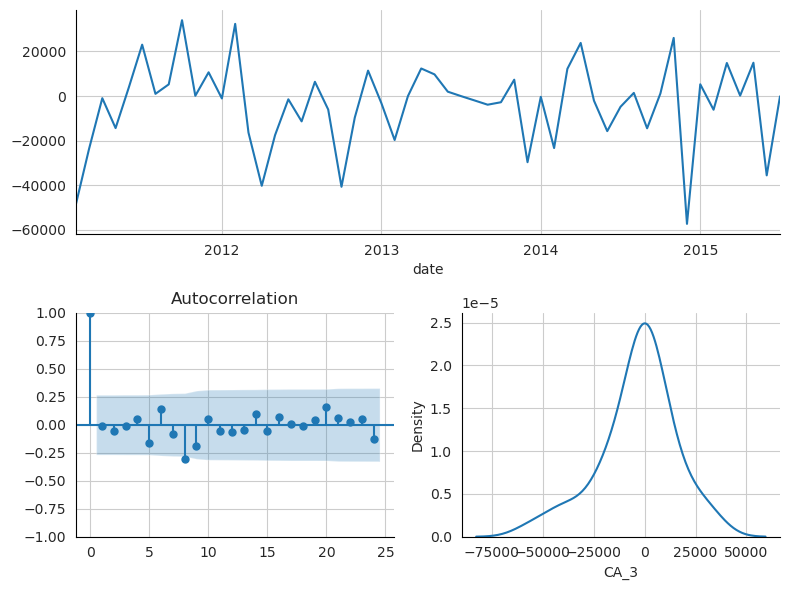


 Store Name CA_4
** Mean of the residuals:  -229.72

** Ljung Box Test, p-value: 0.6836278055352949 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.739 (>0.05, Normal)

** AD Fuller, p_value: 1.3881980199758246e-10 (<0.05, Stationary)


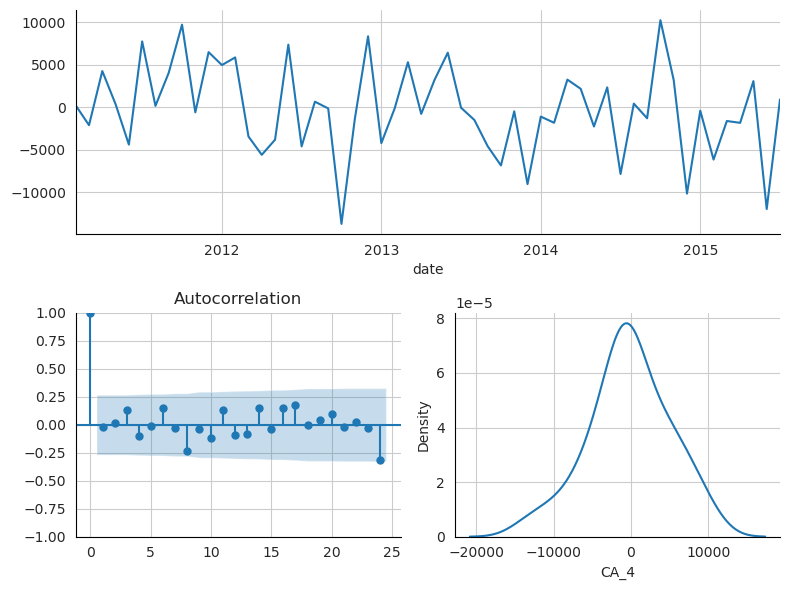

In [87]:
residual_HW=[(Train[i]-fit_HW[i]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(residual_HW[i],24);
    plt.show()

For CA1, residuals are Uncorelated, Not Normal and Stationary.

For CA2 residuals are uncorelated,not normal and non stationary. This may be due to the sudden increase in sale at the end.

For CA3 and CA4, residuals are uncorelated, normal and stationary.

In [88]:
for i in store_list:
    if HW_model_best.loc[i].Box_Cox=="log":
        model_name="Holts-Winter Log"
    elif HW_model_best.loc[i].Box_Cox==True:
        model_name="Holts-Winter Box-Cox"
    else:
        model_name="Holts-Winter"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_HW[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_HW[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [89]:
Model_Performance

store_id       Forecast Method  MAPE      RMSE
0     CA_1        Seasonal Naive   5.4   25314.8
1     CA_2        Seasonal Naive  39.6  164229.7
2     CA_3        Seasonal Naive   5.1   34676.5
3     CA_4        Seasonal Naive   7.8   21282.6
4     CA_1      Holts-Winter Log   1.6    9057.5
5     CA_2  Holts-Winter Box-Cox  11.9   54227.2
6     CA_3          Holts-Winter   2.3   16106.3
7     CA_4      Holts-Winter Log   1.9    5833.4

### ETS Model Statespace Aproach Log

We will used ETS model which are similar to Holts Winter model but the difference lies in the framework they use to identify the best parameters for the model.

ETS models decompose the time series into three components in 3 parts Error, Trend and Seasonality. It uses state space statistical framework to identify the statistical process and then make forecast. 

Statsmodel statespace package has ExponentialSmoothing method we can use to make model for our time series data. We will first make model on log values.

In ETS algorithms, different components can take following values

Error(E): Additive(A) or Multiplicative(M)

Trend(T): Additive(A), No Trend(N), Multiplicative(M), Damped(Ad)

Seasonality: Null(N), Additive(A) or Multiplicative(M)

However, in statsmodel.tsa.statespace.ExponentialSmoothing only has Additive Error, Additive or Damped Trend Models.

In [90]:
predicted_ETSL=pd.DataFrame(columns=store_list)
fit_ETSL=pd.DataFrame(columns=store_list)
resid_ETSL=pd.DataFrame(columns=store_list)
ETSL_models=[]
for i in store_list:
    ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(np.log(Train[i]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETSL[i] = np.exp(ets_LAdA.forecast(len(Test[i])))
    fit_ETSL[i]=np.exp(ets_LAdA.fittedvalues)
    resid_ETSL[i]=Train[i]-fit_ETSL[i]
    ETSL_models.append(ets_LAdA)

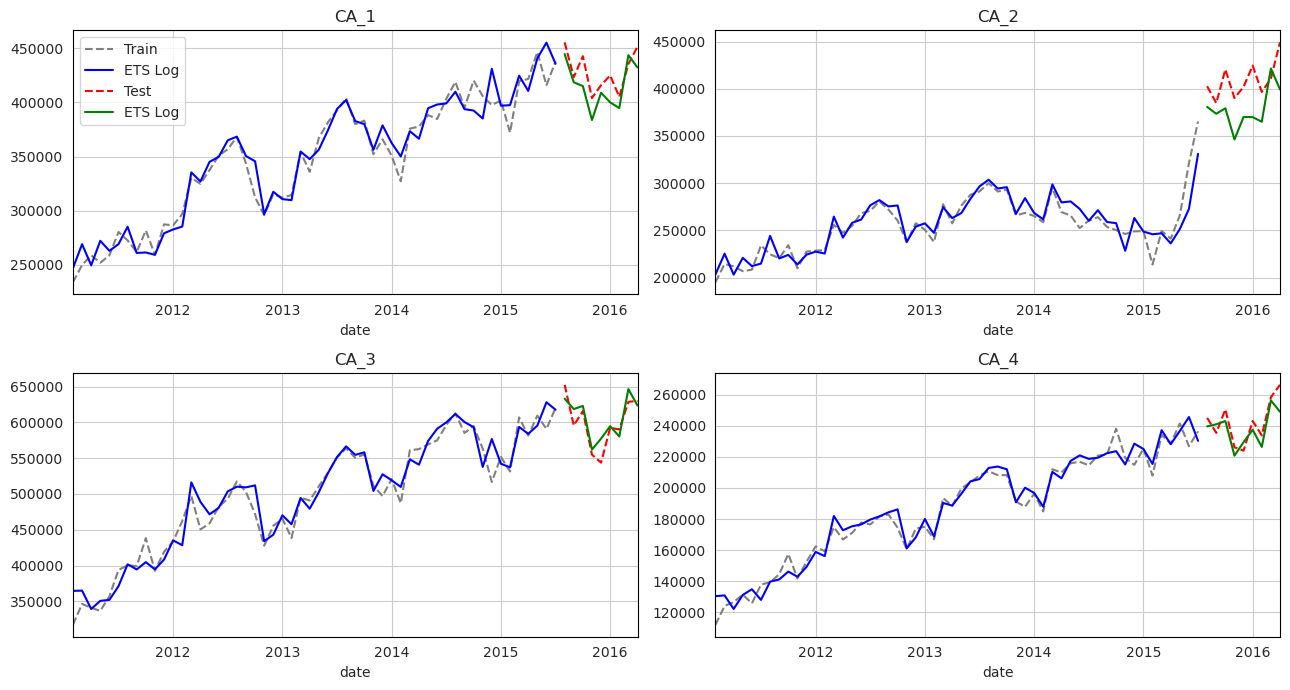

In [91]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETSL["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Log",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETSL["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Log",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [92]:
for i in store_list:
    model_name="ETS Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETSL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETSL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [93]:
Model_Performance

store_id       Forecast Method  MAPE      RMSE
0      CA_1        Seasonal Naive   5.4   25314.8
1      CA_2        Seasonal Naive  39.6  164229.7
2      CA_3        Seasonal Naive   5.1   34676.5
3      CA_4        Seasonal Naive   7.8   21282.6
4      CA_1      Holts-Winter Log   1.6    9057.5
5      CA_2  Holts-Winter Box-Cox  11.9   54227.2
6      CA_3          Holts-Winter   2.3   16106.3
7      CA_4      Holts-Winter Log   1.9    5833.4
8      CA_1               ETS Log   3.5   16821.5
9      CA_2               ETS Log   8.0   36222.3
10     CA_3               ETS Log   2.4   16981.6
11     CA_4               ETS Log   2.8    7953.6

For CA1, CA3, and CA4 model captures trend and seasonality quite well, however they perform worse than their Holts Winter Counterpart. 

However for CA3, the difference in RMSE test is not that large and since ETS model will have lower AICc, we can consider that model over Holts Winter model.

For CA2, model is performing better than Holts winter, which we can observe in the plot by looking at the improved fit and also by seeing lower RMSE test and MAPE test for the model.


 Store Name CA_1
** Mean of the residuals:  -2225.42

** Ljung Box Test, p-value: 0.32329255920177896 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.075 (>0.05, Normal)

** AD Fuller, p_value: 0.0002997316237972313 (<0.05, Stationary)


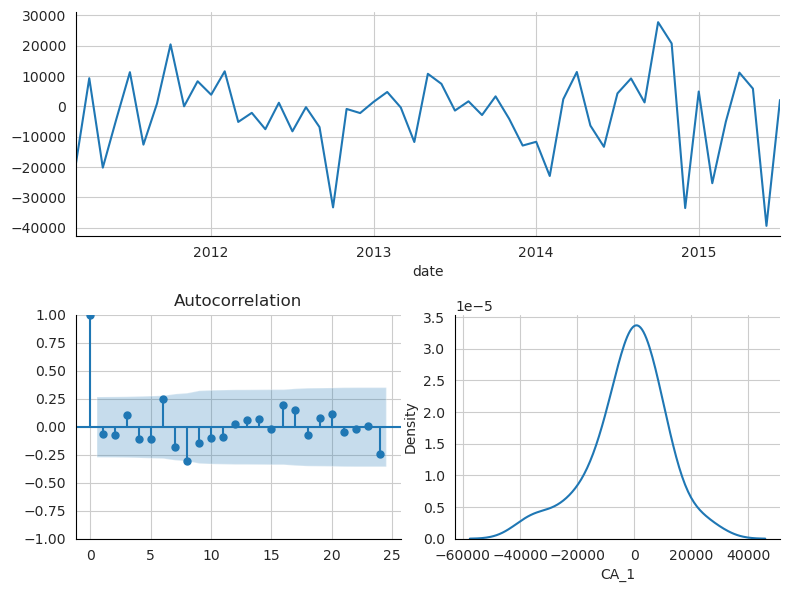


 Store Name CA_2
** Mean of the residuals:  -1240.94

** Ljung Box Test, p-value: 0.6254679281857598 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.3287385939422095 (>0.05, Non-stationary)


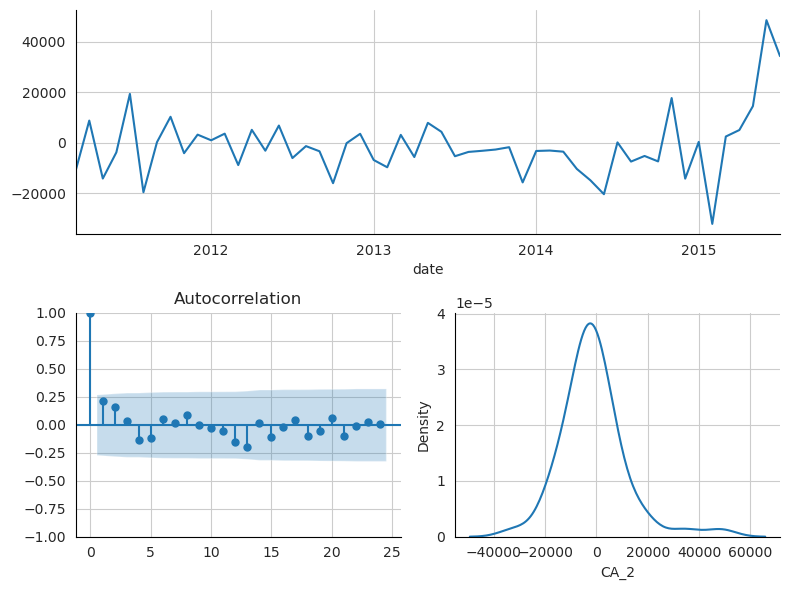


 Store Name CA_3
** Mean of the residuals:  -2607.21

** Ljung Box Test, p-value: 0.5696066279120393 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.02 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0036214748249351267 (<0.05, Stationary)


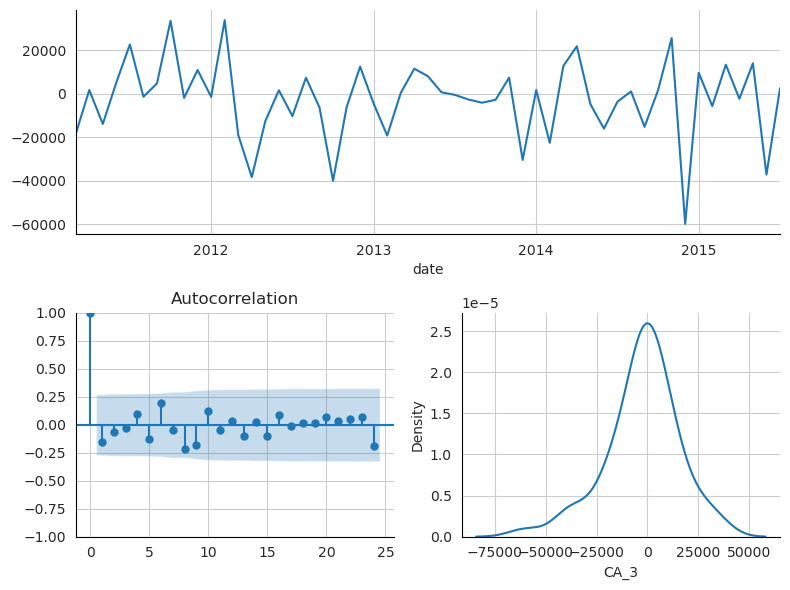


 Store Name CA_4
** Mean of the residuals:  -901.91

** Ljung Box Test, p-value: 0.5357758571787401 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.166 (>0.05, Normal)

** AD Fuller, p_value: 1.3764057532752695e-12 (<0.05, Stationary)


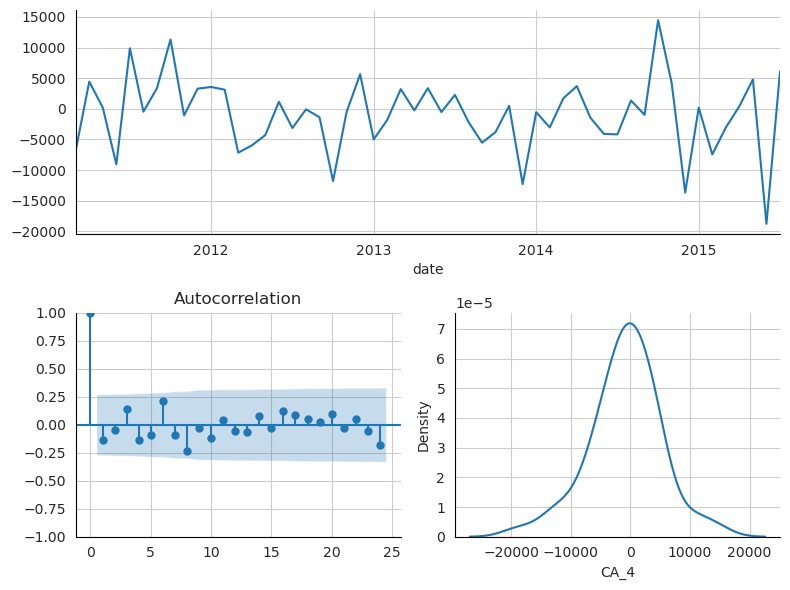

In [94]:
residual_ETSL=[(Train[i][1:]-fit_ETSL[i][1:]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(residual_ETSL[i],24);
    plt.show()

For CA1 and CA4, residuals are Uncorelated, Normal and Stationary.

For CA2 residuals are uncorelated,not normal and non stationary. Non Stationarity may be due to the sudden increase in sale at the end.

For CA3, residuals are uncorelated, not normal and stationary.

### ETS Model

In [95]:
predicted_ETS=pd.DataFrame(columns=store_list)
fit_ETS=pd.DataFrame(columns=store_list)
resid_ETS=pd.DataFrame(columns=store_list)
ETS_models=[]
for i in store_list:
    ets_AdA=sm.tsa.statespace.ExponentialSmoothing(Train[i],
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETS[i] = ets_AdA.forecast(len(Test[i]))
    fit_ETS[i]=ets_AdA.fittedvalues
    resid_ETS[i]=Train[i]-fit_ETS[i]
    ETS_models.append(ets_AdA)

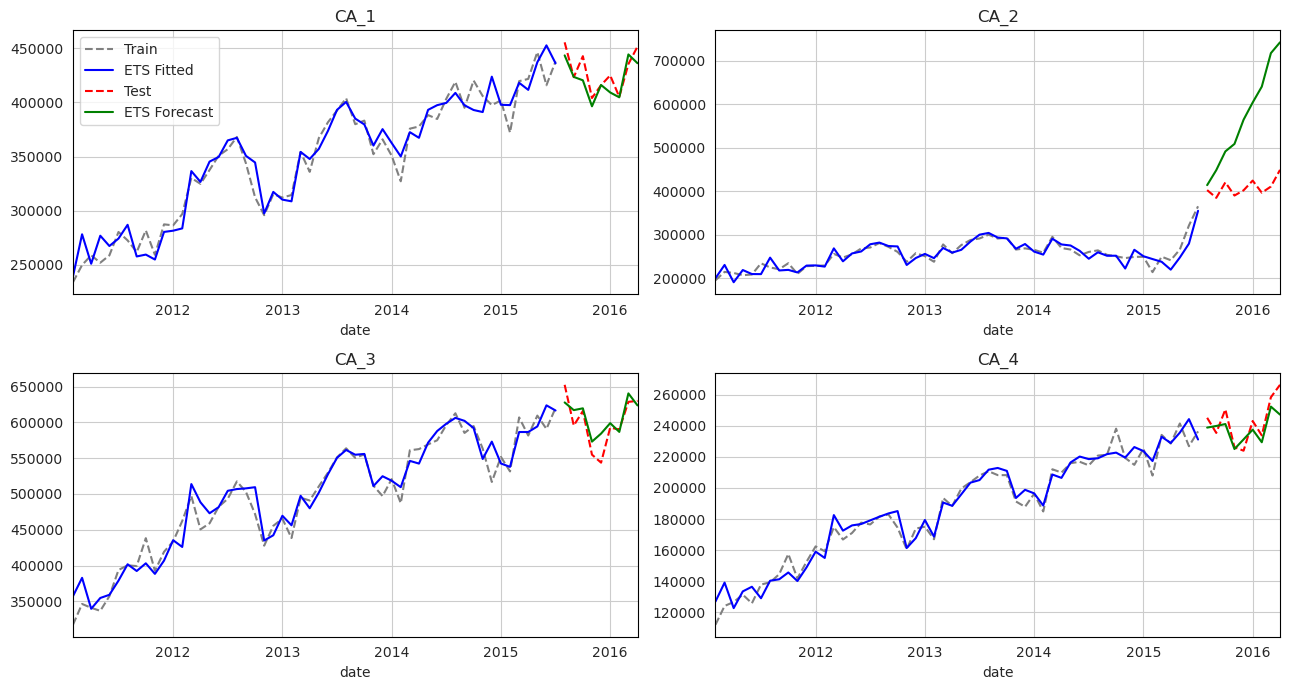

In [96]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETS["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETS["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [97]:
for i in store_list:
    model_name="ETS"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETS[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETS[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [98]:
Model_Performance

store_id       Forecast Method  MAPE      RMSE
0      CA_1        Seasonal Naive   5.4   25314.8
1      CA_2        Seasonal Naive  39.6  164229.7
2      CA_3        Seasonal Naive   5.1   34676.5
3      CA_4        Seasonal Naive   7.8   21282.6
4      CA_1      Holts-Winter Log   1.6    9057.5
5      CA_2  Holts-Winter Box-Cox  11.9   54227.2
6      CA_3          Holts-Winter   2.3   16106.3
7      CA_4      Holts-Winter Log   1.9    5833.4
8      CA_1               ETS Log   3.5   16821.5
9      CA_2               ETS Log   8.0   36222.3
10     CA_3               ETS Log   2.4   16981.6
11     CA_4               ETS Log   2.8    7953.6
12     CA_1                   ETS   2.1   11887.0
13     CA_2                   ETS  39.0  189053.0
14     CA_3                   ETS   2.6   19131.5
15     CA_4                   ETS   2.9    8546.3

For CA1, ETS model perform better than the ETS log and Seasonal naive model, however, it perform worse than the Holts Winter model.

For CA2, ETS model is quite terrible and almost equal to seasonal naive model.

For CA3 and CA4, models catches trend and seasonality quite well but is not better than Holts Winter or ETS log models.


 Store Name CA_1
** Mean of the residuals:  -2336.81

** Ljung Box Test, p-value: 0.42762740113672365 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.152 (>0.05, Normal)

** AD Fuller, p_value: 0.00033648414755604763 (<0.05, Stationary)


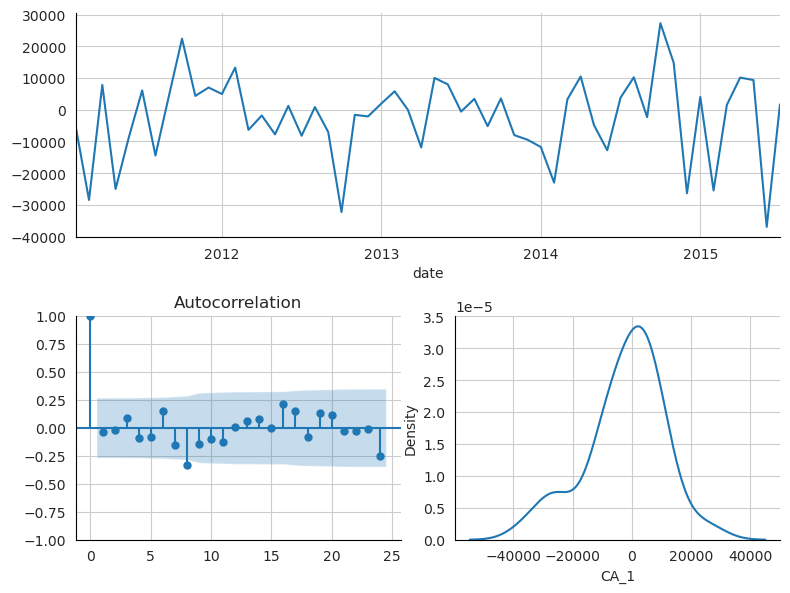


 Store Name CA_2
** Mean of the residuals:  1301.44

** Ljung Box Test, p-value: 0.9056462403057007 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.093 (>0.05, Normal)

** AD Fuller, p_value: 8.380814013214805e-11 (<0.05, Stationary)


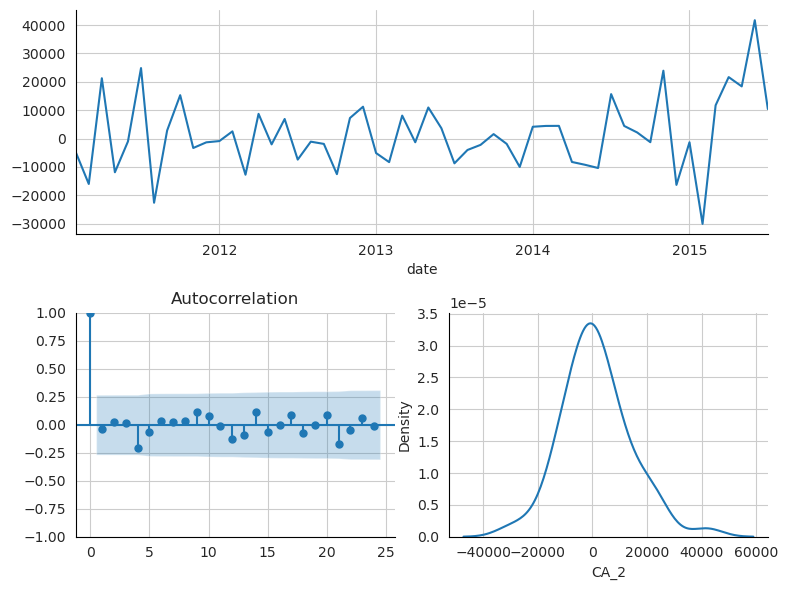


 Store Name CA_3
** Mean of the residuals:  -3204.9

** Ljung Box Test, p-value: 0.668556942901993 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.128 (>0.05, Normal)

** AD Fuller, p_value: 2.2944035877368933e-11 (<0.05, Stationary)


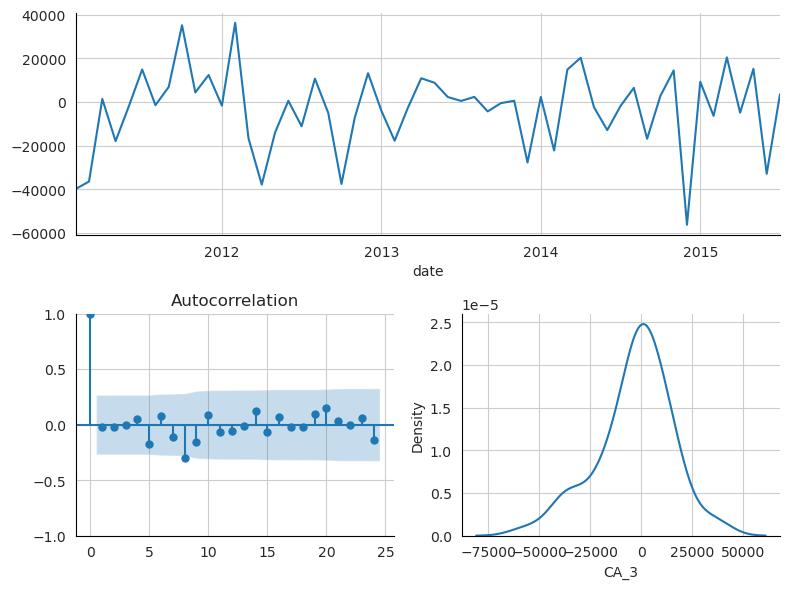


 Store Name CA_4
** Mean of the residuals:  -1107.95

** Ljung Box Test, p-value: 0.6209352204085623 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.378 (>0.05, Normal)

** AD Fuller, p_value: 0.0008996044183721046 (<0.05, Stationary)


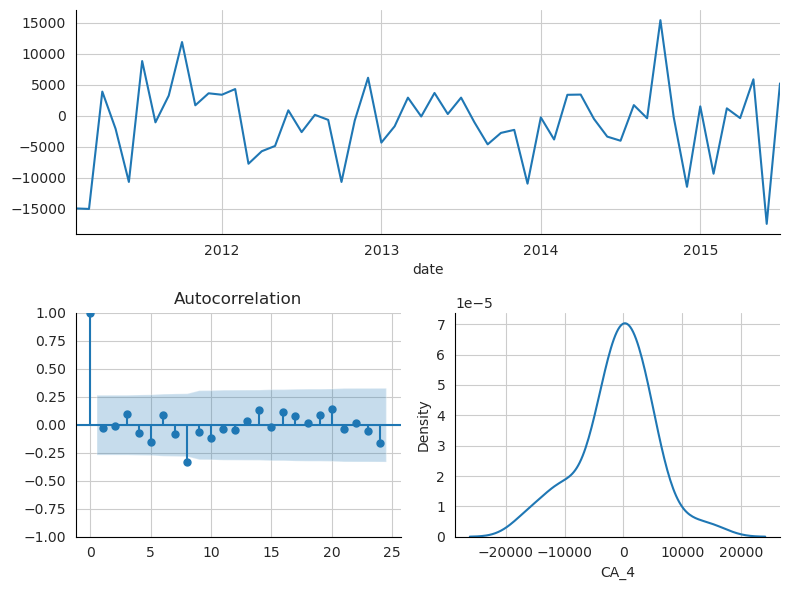

In [99]:
#residual_ETSL=[(Train[i][1:]-fit_ETSL[i][1:]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(resid_ETS["CA_"+str(i+1)],24);
    plt.show()

For all the stores, the residuals are Uncorelated, Normal and Stationary.

### SARIMA Models

Sarima models are Seasonal ARIMA models. SARIMA is acronym for Seasonal Auto Regressive Integrated Moving Average. 

Auto Regressive(AR) Moving Average(MA) Process states that current value of some series y depends linearly on its previous values plus a combination of current & previous values of error terms.

SARIMA models applies Regression on lag values and/or moving average on error terms. 

The order of AR process is p. It tells us that how many past values we should consider while calculating the current value, 

The order of MA process is q. It tells us the number of past error terms we should take in our weighted average. This weighted average is used by the model while calculating current value.

Since for ARIMA and SARIMA models, stationarity is a neccessary condition, we can tell model to difference our data with previous values in the data to make it stationary. 

The number of time the data values needs be differenced is the Integration component of ARIMA model. This is 'd' parameter of ARIMA model.

In the Seasonal Arima models we have 4 more parameters i.e. P,D,Q and number of periods in seasons. P,D and Q are counter parts of p,d and q for a seasonal process.

Finding these parameters require much study and knowledge, but in general p+d+q+P+D+Q <= 6. We will use auto_arima from pmdarima package to calculate the best parameters of SARIMA models for sales data of each store and then we will pass those parameters to statsmodel SARIMAX function.

X in SARIMAX stands for exogenous variable which we can give to this model if we want to supply model with external data. This gives us the functionality to not only use past data in building the model but also use external variable such as holidays, important events and days such as superbowl matches, worldcup matches or weather forecasts to explain any change in particular value on those days.

In [100]:
best_arima=[]
for i in store_list:    
    best_arima.append(auto_arima(Train[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [101]:
predicted_SARIMA=pd.DataFrame(columns=store_list)
fit_SARIMA=pd.DataFrame(columns=store_list)
resid_SARIMA=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Train[i],
                          **best_arima[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMA[i] = sarima_fit.fittedvalues
    resid_SARIMA[i] = sarima_fit.resid[1:]
    predicted_SARIMA[i] = sarima_fit.predict(start, end, dynamic=False)
    

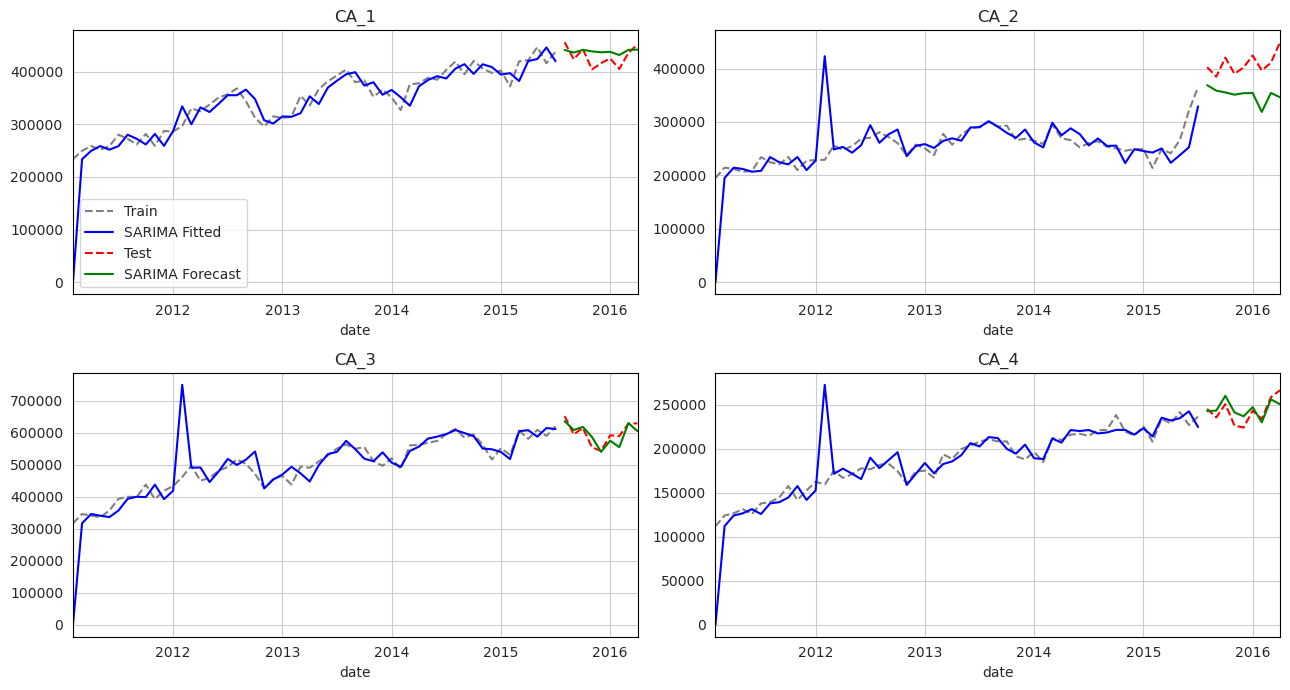

In [102]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMA["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMA["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [103]:
for i in store_list:
    model_name="SARIMA"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMA[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMA[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [104]:
Model_Performance

store_id       Forecast Method  MAPE      RMSE
0      CA_1        Seasonal Naive   5.4   25314.8
1      CA_2        Seasonal Naive  39.6  164229.7
2      CA_3        Seasonal Naive   5.1   34676.5
3      CA_4        Seasonal Naive   7.8   21282.6
4      CA_1      Holts-Winter Log   1.6    9057.5
5      CA_2  Holts-Winter Box-Cox  11.9   54227.2
6      CA_3          Holts-Winter   2.3   16106.3
7      CA_4      Holts-Winter Log   1.9    5833.4
8      CA_1               ETS Log   3.5   16821.5
9      CA_2               ETS Log   8.0   36222.3
10     CA_3               ETS Log   2.4   16981.6
11     CA_4               ETS Log   2.8    7953.6
12     CA_1                   ETS   2.1   11887.0
13     CA_2                   ETS  39.0  189053.0
14     CA_3                   ETS   2.6   19131.5
15     CA_4                   ETS   2.9    8546.3
16     CA_1                SARIMA   3.7   18163.2
17     CA_2                SARIMA  13.9   62055.6
18     CA_3                SARIMA   2.7   19955.4
19     CA_4                SARIMA   3.4    9649.6

SARIMA model have performed well and they do catch the trend and season quite well. SARIMA models dont fit well in start of the time frame as we can observe from the plot. There are also some spikes we can observe. 

From the Point of View of accuracy metrics, they are not the best models for any of the stores, but come in middle and perform substantially well than Seasonal Naive model.

In [105]:
best_arima[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -597.926
Date:                            Sun, 02 Apr 2023   AIC                           1201.853
Time:                                    05:58:07   BIC                           1207.763
Sample:                                02-01-2011   HQIC                          1204.126
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3853.6875   3058.982      1.260      0.208   -2141.807    9849.182
ar.S.L12       0.1774      0.050      3.526      0.000       0.079       0.276
sigma2      4.094e+08      0.013   3.16e+10      0.000    4.09e+08    4.09e+08
===================================================================================
Ljung-Box (L1) (Q):                   7.26   Jarque-Bera (JB):                 1.36
Prob(Q):                              0.01   Prob(JB):                         0.51
Heteroskedasticity (H):               1.64   Skew:                            -0.06
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.86e+30. Standard errors may be unstable.
"""

You can view the summary of arima model selected by auto_arima function on calling .summary() method. 

This will give us information such as order (p,d,q),(P,D,Q) for the model, Ljung box, Jarque Bera test results on residuals, as well as various metrics for checking model quality such as AICC,BIC and HQIC.


 Store Name CA_1
** Mean of the residuals:  2297.92

** Ljung Box Test, p-value: 0.010185466390723786 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.514 (>0.05, Normal)

** AD Fuller, p_value: 2.67578952470869e-18 (<0.05, Stationary)


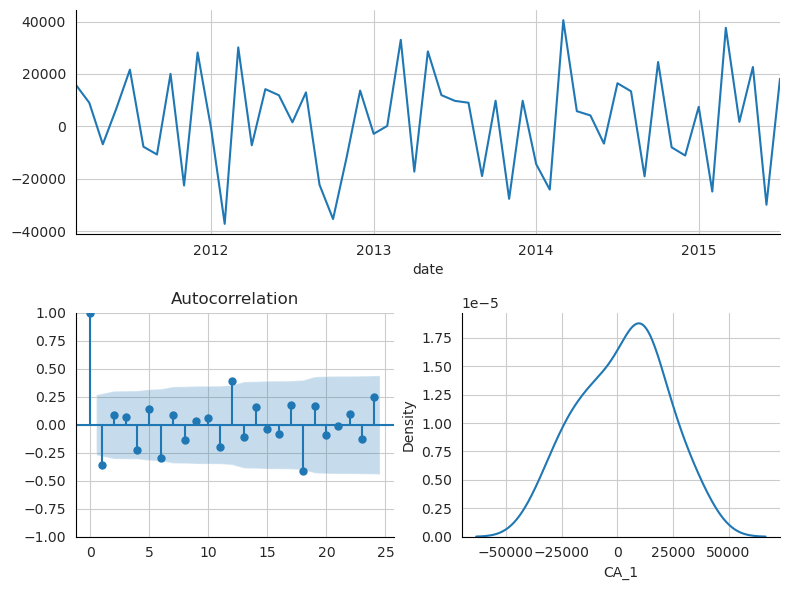


 Store Name CA_2
** Mean of the residuals:  -1691.06

** Ljung Box Test, p-value: 0.965162625450717 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 1.8123963465853605e-09 (<0.05, Stationary)


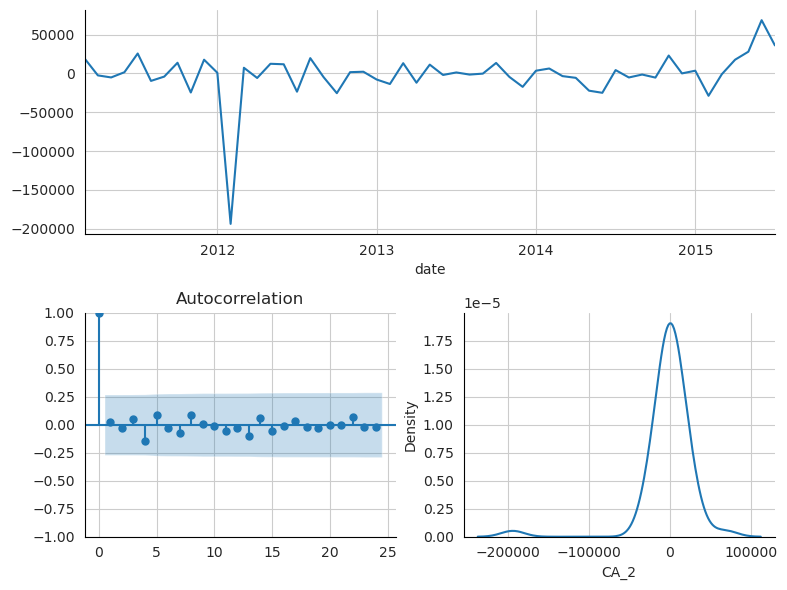


 Store Name CA_3
** Mean of the residuals:  -5523.66

** Ljung Box Test, p-value: 0.9011233260220282 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 2.810040076127105e-12 (<0.05, Stationary)


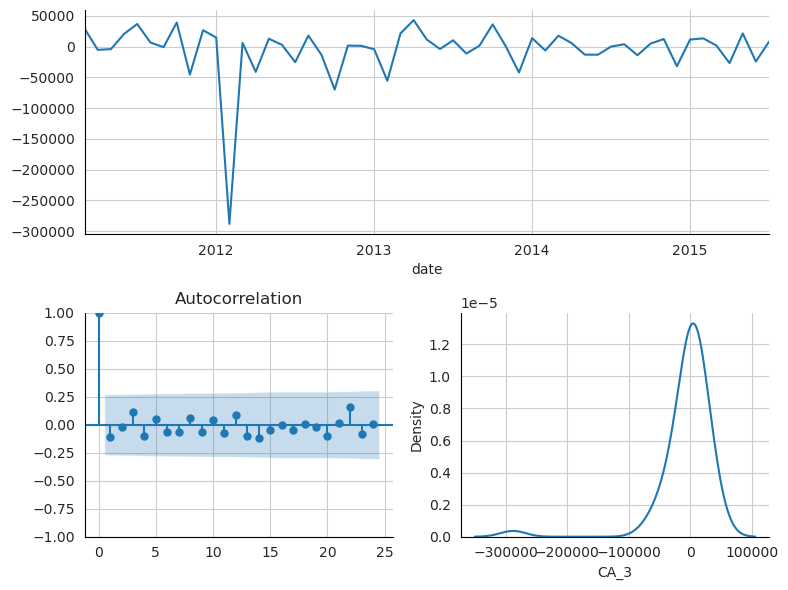


 Store Name CA_4
** Mean of the residuals:  -1665.17

** Ljung Box Test, p-value: 0.683158483423274 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 3.449030259100931e-13 (<0.05, Stationary)


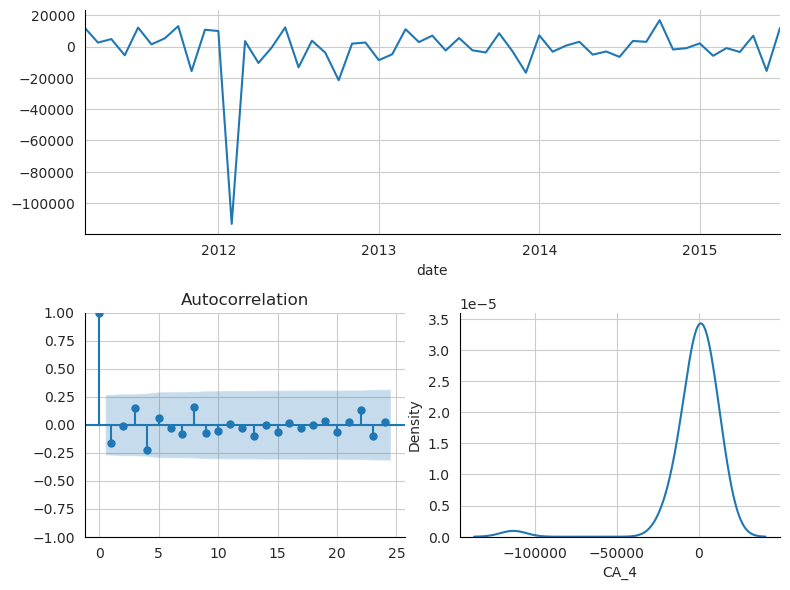

In [106]:
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(resid_SARIMA["CA_"+str(i+1)],24);
    plt.show()

For CA1, residuals are Corelated, Normal and Stationary. Presence of corelation means that there is still some structured information remaining in the residuals.

For CA2,CA3 and CA4 residuals are uncorelated, not normal and stationary.

### SARIMA Log Models

In [107]:
best_arimaL=[]
Trainlog=np.log(Train)
for i in store_list:    
    best_arimaL.append(auto_arima(Trainlog[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [108]:
predicted_SARIMAL=pd.DataFrame(columns=store_list)
fit_SARIMAL=pd.DataFrame(columns=store_list)
resid_SARIMAL=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Trainlog[i],
                          **best_arimaL[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMAL[i] = np.exp(sarima_fit.fittedvalues)
    resid_SARIMAL[i] = Train[i][1:]-fit_SARIMAL[i][1:]
    predicted_SARIMAL[i] = np.exp(sarima_fit.predict(start, end, dynamic=False))

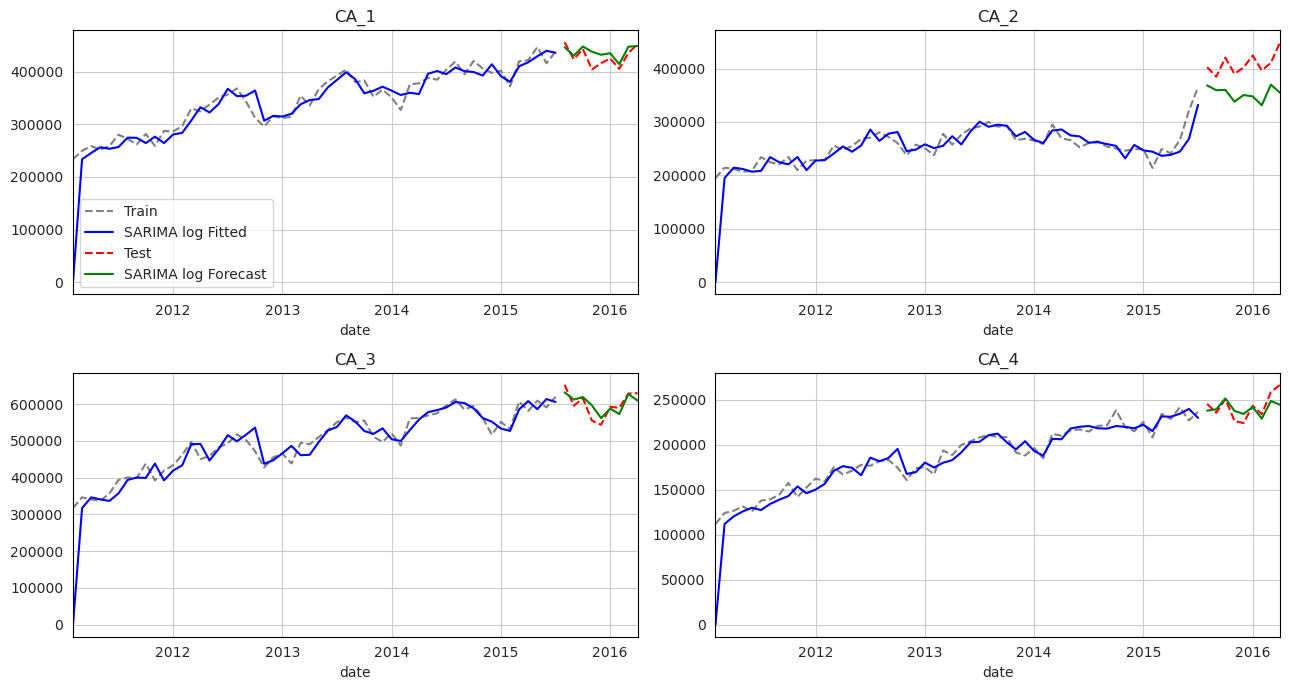

In [109]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMAL["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA log Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMAL["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA log Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [110]:
for i in store_list:
    model_name="SARIMA Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMAL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMAL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [111]:
Model_Performance

store_id       Forecast Method  MAPE      RMSE
0      CA_1        Seasonal Naive   5.4   25314.8
1      CA_2        Seasonal Naive  39.6  164229.7
2      CA_3        Seasonal Naive   5.1   34676.5
3      CA_4        Seasonal Naive   7.8   21282.6
4      CA_1      Holts-Winter Log   1.6    9057.5
5      CA_2  Holts-Winter Box-Cox  11.9   54227.2
6      CA_3          Holts-Winter   2.3   16106.3
7      CA_4      Holts-Winter Log   1.9    5833.4
8      CA_1               ETS Log   3.5   16821.5
9      CA_2               ETS Log   8.0   36222.3
10     CA_3               ETS Log   2.4   16981.6
11     CA_4               ETS Log   2.8    7953.6
12     CA_1                   ETS   2.1   11887.0
13     CA_2                   ETS  39.0  189053.0
14     CA_3                   ETS   2.6   19131.5
15     CA_4                   ETS   2.9    8546.3
16     CA_1                SARIMA   3.7   18163.2
17     CA_2                SARIMA  13.9   62055.6
18     CA_3                SARIMA   2.7   19955.4
19     CA_4                SARIMA   3.4    9649.6
20     CA_1            SARIMA Log   2.8   14430.4
21     CA_2            SARIMA Log  13.5   59230.4
22     CA_3            SARIMA Log   2.7   19692.5
23     CA_4            SARIMA Log   3.2   10071.4

For CA1, there is considerable improvement in accuracy when we used log values in SARIMA model. 

For CA2 and CA4, there is a slight improvement.

For CA3, there is not any improvement in accuracy.


 Store Name CA_1
** Mean of the residuals:  2048.85

** Ljung Box Test, p-value: 0.5369037019458277 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.015 (<0.05, Not-normal)

** AD Fuller, p_value: 2.0606096432460373e-11 (<0.05, Stationary)


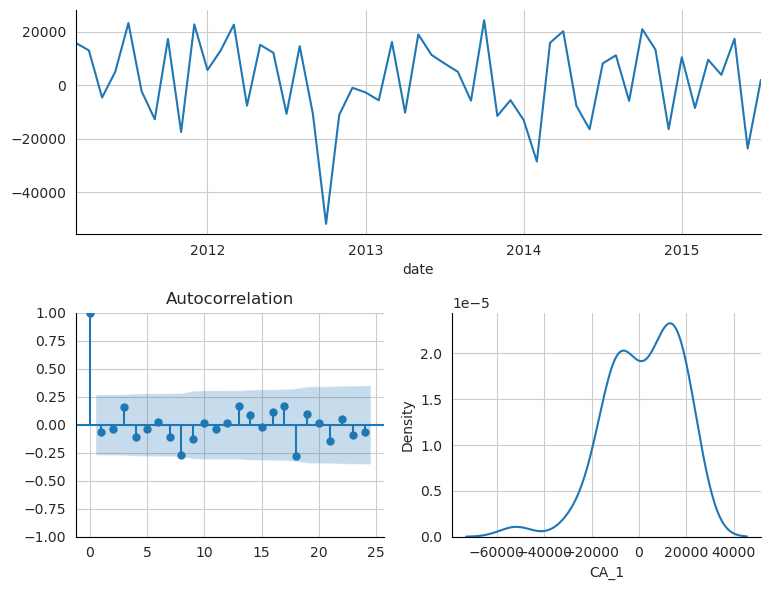


 Store Name CA_2
** Mean of the residuals:  1555.13

** Ljung Box Test, p-value: 0.7635292287003429 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.037 (<0.05, Not-normal)

** AD Fuller, p_value: 0.45678416495211654 (>0.05, Non-stationary)


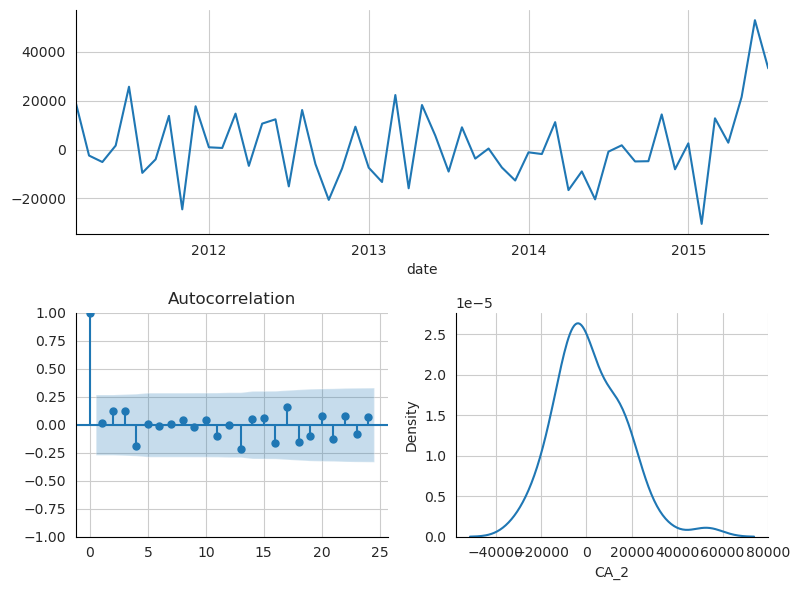


 Store Name CA_3
** Mean of the residuals:  1526.58

** Ljung Box Test, p-value: 0.4357815696819897 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.095 (>0.05, Normal)

** AD Fuller, p_value: 3.4424070454736236e-14 (<0.05, Stationary)


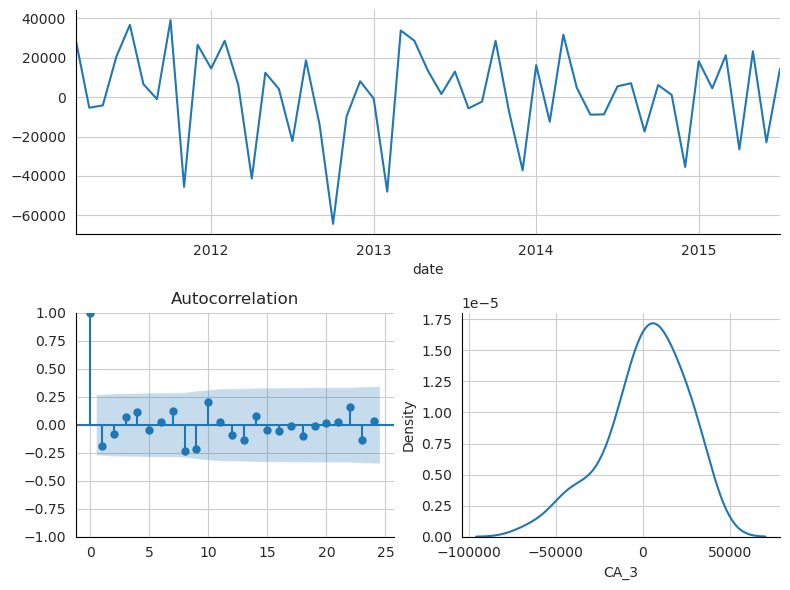


 Store Name CA_4
** Mean of the residuals:  1029.19

** Ljung Box Test, p-value: 0.8659683508925777 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.527 (>0.05, Normal)

** AD Fuller, p_value: 5.2318424323781305e-11 (<0.05, Stationary)


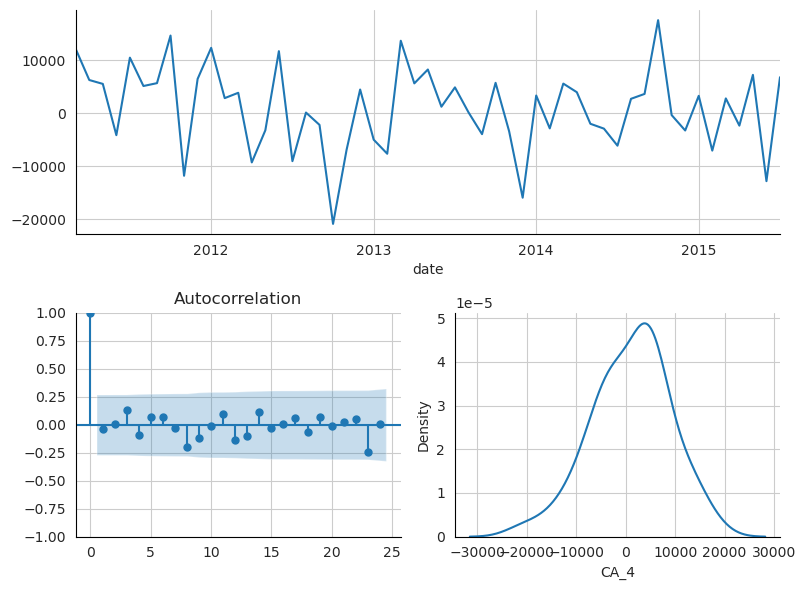

In [112]:
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(resid_SARIMAL["CA_"+str(i+1)],24);
    plt.show()

For CA1, Residuals are uncorelated, not normal and stationary.

For CA2, residuals are uncorelated, not normal and non stationary.

For CA3 and CA4, residuals are uncorelated, normal, stationary.

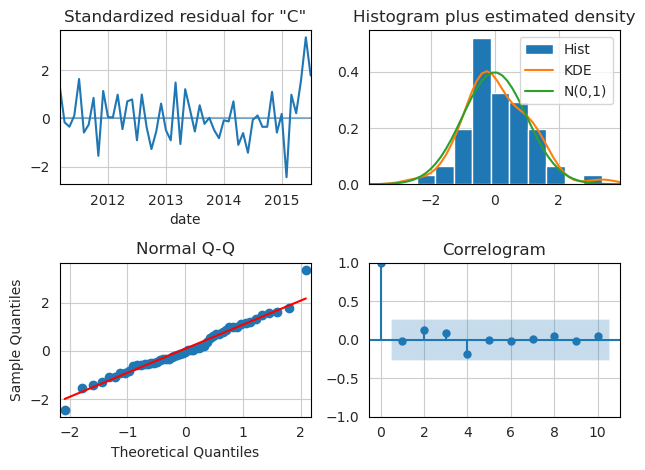

In [113]:
SARIMAX(endog=Trainlog["CA_2"],**best_arimaL[1].get_params()).fit(disp=0).plot_diagnostics()
plt.tight_layout()
plt.show()

You can also use .plot_diagnostic() function on object that we get after fitting the SARIMAX model to analyze the residuals.

### FB Prophet Model

FB Prophet Model is developed by Facebook. It is build in STAN. 

Foundation of this model is Generalized Linear Model. This means that it has functions instead of coefficients for each variable of linear model. They are solved using backfill, method similar to back propogation.

This model is best for high frequency data such as hourly, or daily. FB prophet model can make a model even when there are multiple seasonalities in data, for e.g, Weekly seasonality, and monthly seasinality in annual daily sales data. This flexibility as well as easeness in making model makes FB prophet one of popular algorithm in Time Series Analysis.  

A list of Holidays can be provided to this model.We can also add lower window and upper window to a holiday. This means that if holiday is on 26th then sales would be affected on 25th and 27th, if the lower window and upper window is 1.

We can tell Facebook Prophet model if we want to use logistic growth curve where we can add a changing cap over time.

We will build model with both seasonality mode, Additive and Multiplicative

In [114]:
import os
import sys

# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


In [115]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

predicted_prophet_add=pd.DataFrame(columns=store_list)
fit_prophet_add=pd.DataFrame(columns=store_list)
resid_prophet_add=pd.DataFrame(columns=store_list)

predicted_prophet_mul=pd.DataFrame(columns=store_list)
fit_prophet_mul=pd.DataFrame(columns=store_list)
resid_prophet_mul=pd.DataFrame(columns=store_list)

prophetmodels=[]

for i in store_list:
    train_fb_prophet=Train[i].reset_index()
    train_fb_prophet.columns=["ds","y"]  ## Compulsary for prophet that dataframe is in this format.
    test_fb_prophet=Test[i].reset_index()
    test_fb_prophet.columns=["ds","y"]
    seasonality_mode=["multiplicative","additive"]
    for j in seasonality_mode:
        with suppress_stdout_stderr(): ## to suppress fbprophet long running output. more on it on https://github.com/facebook/prophet/issues/223#issuecomment-310497971
            prophet_model=Prophet(weekly_seasonality=False,
                                  daily_seasonality=False,
                                  yearly_seasonality=True,
                                  seasonality_mode=j).fit(train_fb_prophet)
        fb_dataframe=prophet_model.make_future_dataframe(len(Test),freq='MS',include_history=True)
        predicted_prophet=prophet_model.predict(fb_dataframe).set_index("ds")
        if j=="multiplicative":
            predicted_prophet_mul[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_mul[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_mul[i]=Train[i]-fit_prophet_mul[i]
        else:
            predicted_prophet_add[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_add[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_add[i]=Train[i]-fit_prophet_add[i]
            prophetmodels.append(prophet_model)


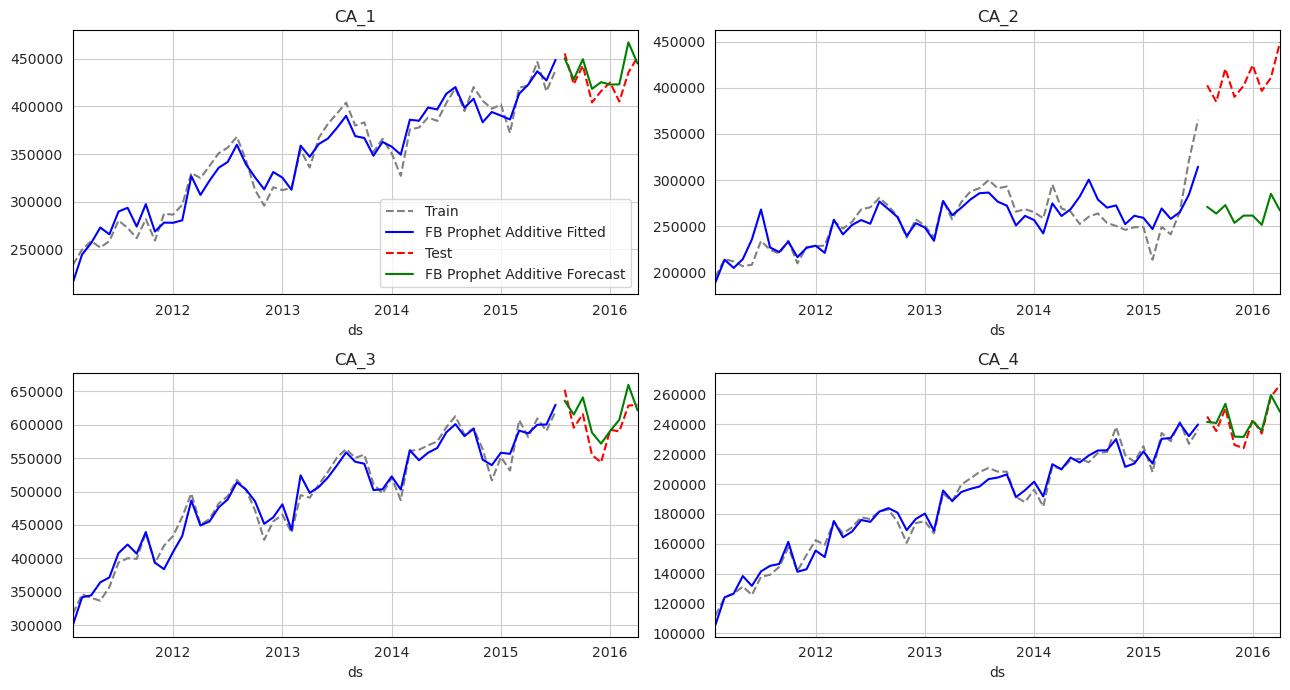

In [116]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_add["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Additive Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_add["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Additive Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [117]:
for i in store_list:
    model_name="Prophet Additive"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_add[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_add[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

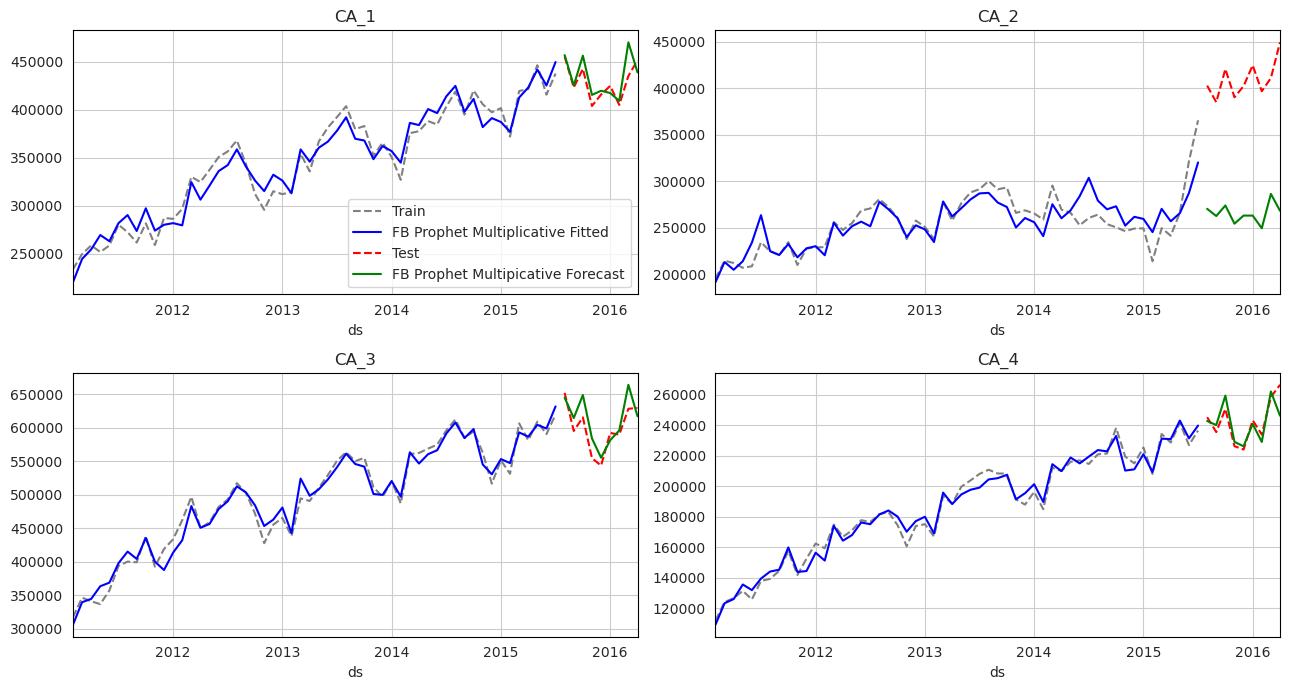

In [118]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["CA_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_mul["CA_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Multiplicative Fitted",ax=axs)
    Test["CA_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_mul["CA_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Multipicative Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()

In [119]:
for i in store_list:
    model_name="Prophet Multiplicative"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_mul[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_mul[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [120]:
Model_Performance

store_id         Forecast Method  MAPE      RMSE
0      CA_1          Seasonal Naive   5.4   25314.8
1      CA_2          Seasonal Naive  39.6  164229.7
2      CA_3          Seasonal Naive   5.1   34676.5
3      CA_4          Seasonal Naive   7.8   21282.6
4      CA_1        Holts-Winter Log   1.6    9057.5
5      CA_2    Holts-Winter Box-Cox  11.9   54227.2
6      CA_3            Holts-Winter   2.3   16106.3
7      CA_4        Holts-Winter Log   1.9    5833.4
8      CA_1                 ETS Log   3.5   16821.5
9      CA_2                 ETS Log   8.0   36222.3
10     CA_3                 ETS Log   2.4   16981.6
11     CA_4                 ETS Log   2.8    7953.6
12     CA_1                     ETS   2.1   11887.0
13     CA_2                     ETS  39.0  189053.0
14     CA_3                     ETS   2.6   19131.5
15     CA_4                     ETS   2.9    8546.3
16     CA_1                  SARIMA   3.7   18163.2
17     CA_2                  SARIMA  13.9   62055.6
18     CA_3                  SARIMA   2.7   19955.4
19     CA_4                  SARIMA   3.4    9649.6
20     CA_1              SARIMA Log   2.8   14430.4
21     CA_2              SARIMA Log  13.5   59230.4
22     CA_3              SARIMA Log   2.7   19692.5
23     CA_4              SARIMA Log   3.2   10071.4
24     CA_1        Prophet Additive   2.6   14021.4
25     CA_2        Prophet Additive  35.0  144694.5
26     CA_3        Prophet Additive   3.4   22460.5
27     CA_4        Prophet Additive   2.1    7227.0
28     CA_1  Prophet Multiplicative   2.4   14154.9
29     CA_2  Prophet Multiplicative  35.0  144465.9
30     CA_3  Prophet Multiplicative   3.1   21454.0
31     CA_4  Prophet Multiplicative   2.3    7947.3

FB Prophet model captures trend and seasonality quite well. 

For CA4 it is the second best model. 

For CA2, the model was not able to capture sudden increase and the accuracy is quite low. 

For CA1 and CA3, the model is in the middle when we rank according to RMSE. 

There is not much difference in accuracy for different seasonality modes for our time series data.


 Store Name CA_1
** Mean of the residuals:  0.85

** Ljung Box Test, p-value: 1.1144491340078577e-06 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.179 (>0.05, Normal)

** AD Fuller, p_value: 0.0005385403219108966 (<0.05, Stationary)


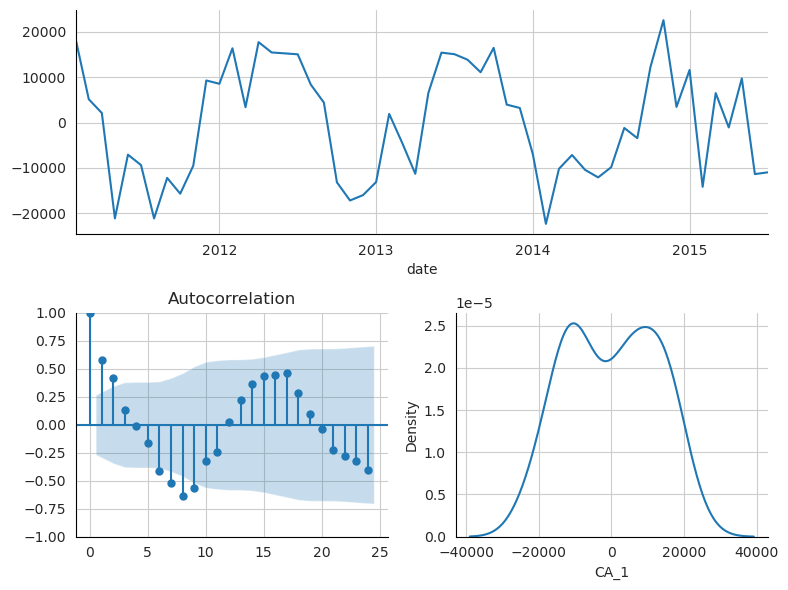


 Store Name CA_2
** Mean of the residuals:  0.05

** Ljung Box Test, p-value: 3.3202214539583356e-05 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.147 (>0.05, Normal)

** AD Fuller, p_value: 0.0012664714413867188 (<0.05, Stationary)


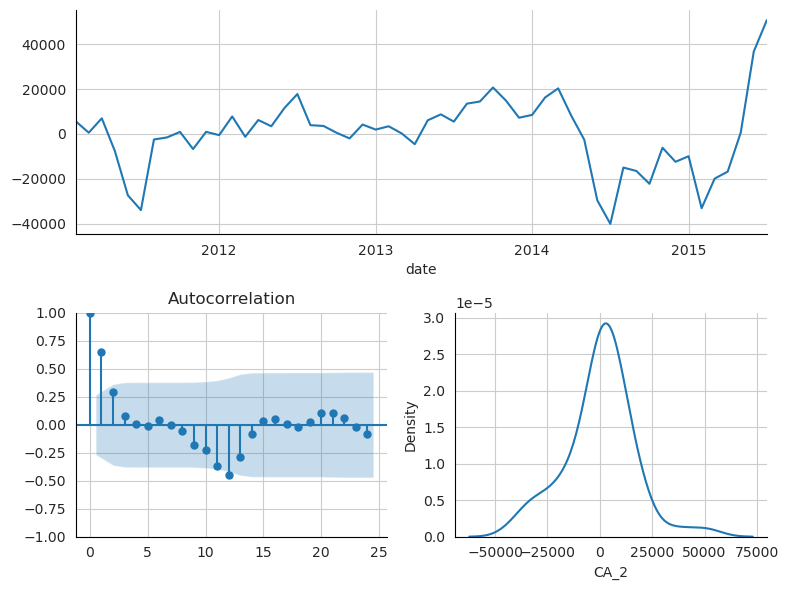


 Store Name CA_3
** Mean of the residuals:  0.46

** Ljung Box Test, p-value: 0.00037287881131174385 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.984 (>0.05, Normal)

** AD Fuller, p_value: 0.00500428489332698 (<0.05, Stationary)


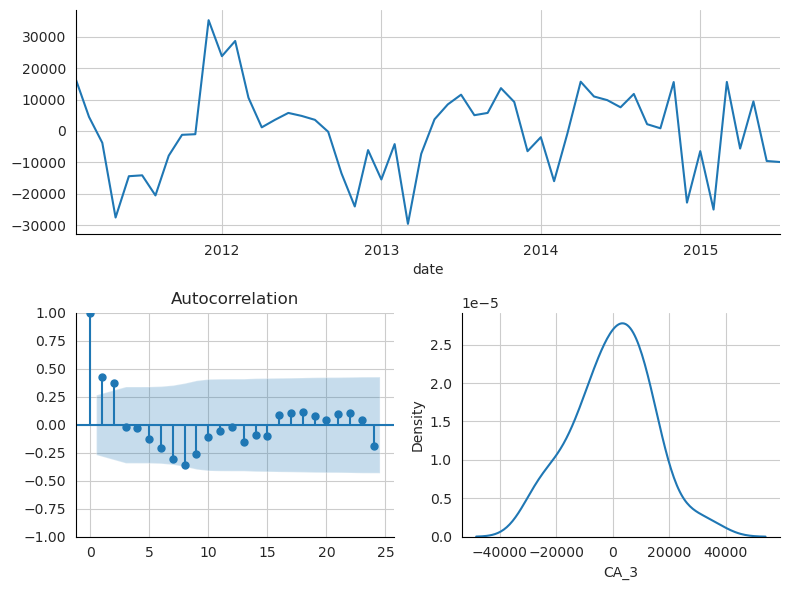


 Store Name CA_4
** Mean of the residuals:  -1.5

** Ljung Box Test, p-value: 2.9562063261807132e-06 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.387 (>0.05, Normal)

** AD Fuller, p_value: 0.0003456110743680143 (<0.05, Stationary)


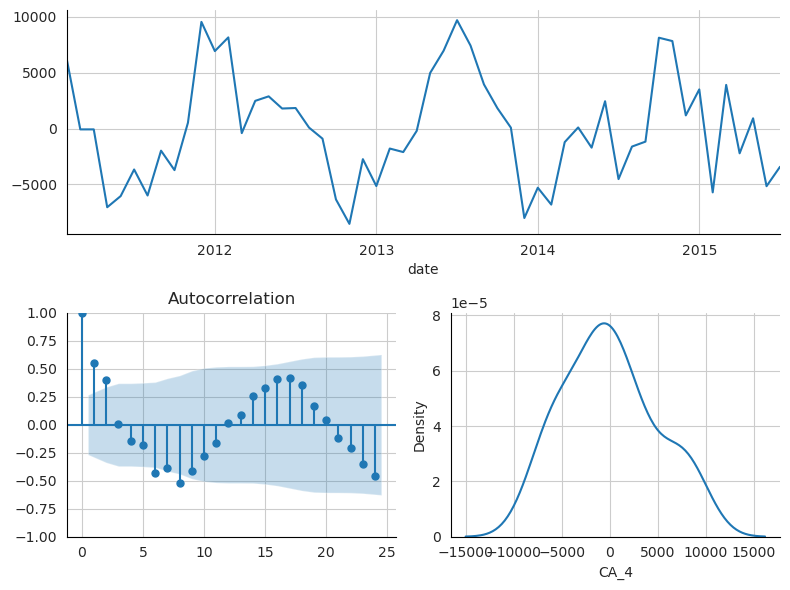

In [121]:
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(resid_prophet_add["CA_"+str(i+1)],24);
    plt.show()


 Store Name CA_1
** Mean of the residuals:  13.75

** Ljung Box Test, p-value: 1.2161032756643135e-07 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.205 (>0.05, Normal)

** AD Fuller, p_value: 0.0006227366184636746 (<0.05, Stationary)


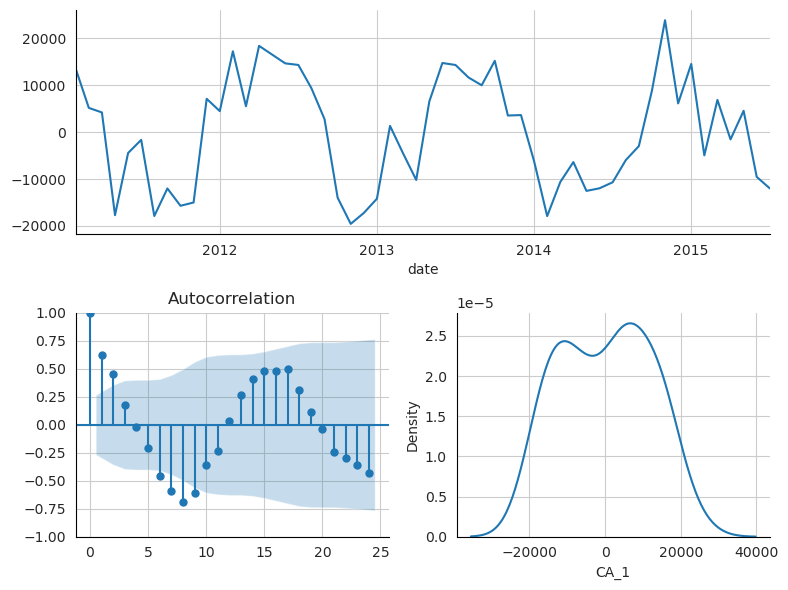


 Store Name CA_2
** Mean of the residuals:  21.76

** Ljung Box Test, p-value: 1.82202031715449e-05 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.279 (>0.05, Normal)

** AD Fuller, p_value: 0.06133532523757809 (>0.05, Non-stationary)


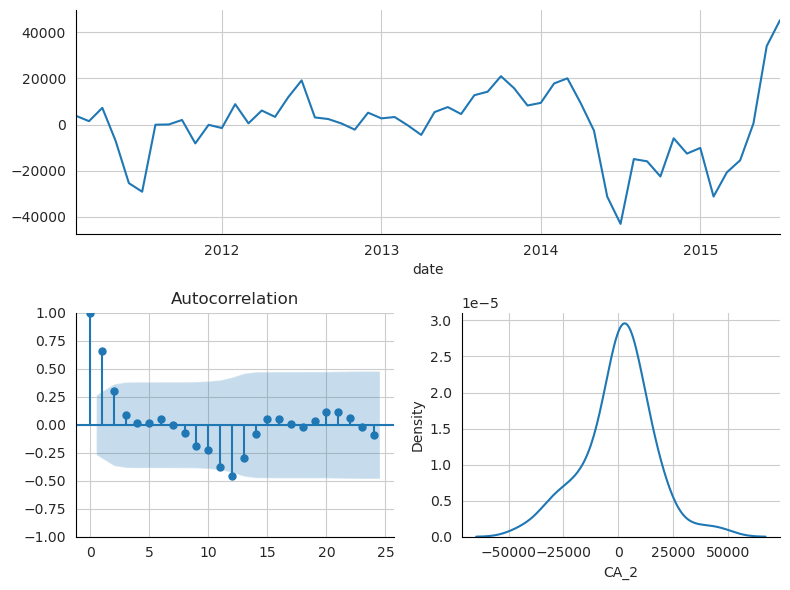


 Store Name CA_3
** Mean of the residuals:  18.92

** Ljung Box Test, p-value: 0.0021642536262609104 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.789 (>0.05, Normal)

** AD Fuller, p_value: 0.014562154616626738 (<0.05, Stationary)


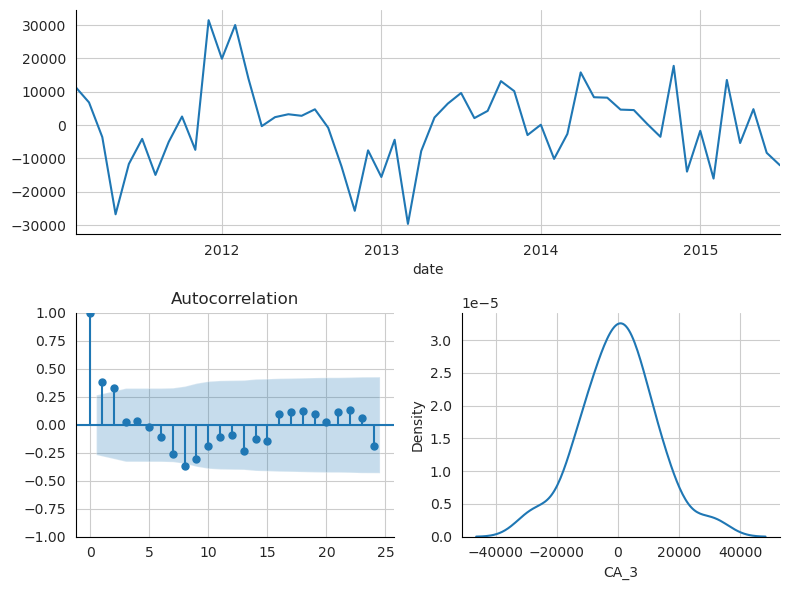


 Store Name CA_4
** Mean of the residuals:  5.92

** Ljung Box Test, p-value: 1.6713389476670982e-07 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.557 (>0.05, Normal)

** AD Fuller, p_value: 0.0001912699476735002 (<0.05, Stationary)


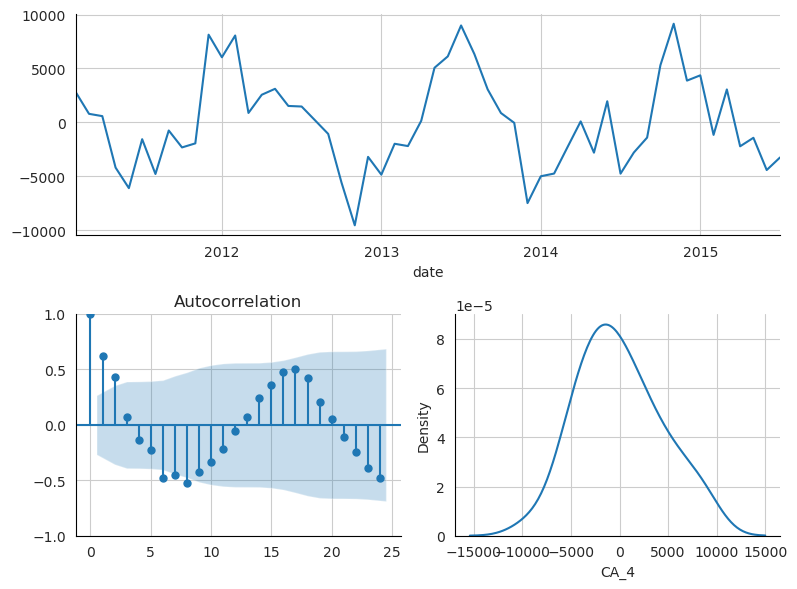

In [122]:
for i in range(len(store_list)):
    print("\n Store Name CA_"+str(i+1))
    residualcheck(resid_prophet_mul["CA_"+str(i+1)],24);
    plt.show()

For all the stores and for both seasonality mode, residuals are corelated, normal and stationary. 

### Summary Best Model

Performance of various models for each stores. We will plot the predicted values of different model and also actual value for different stores.

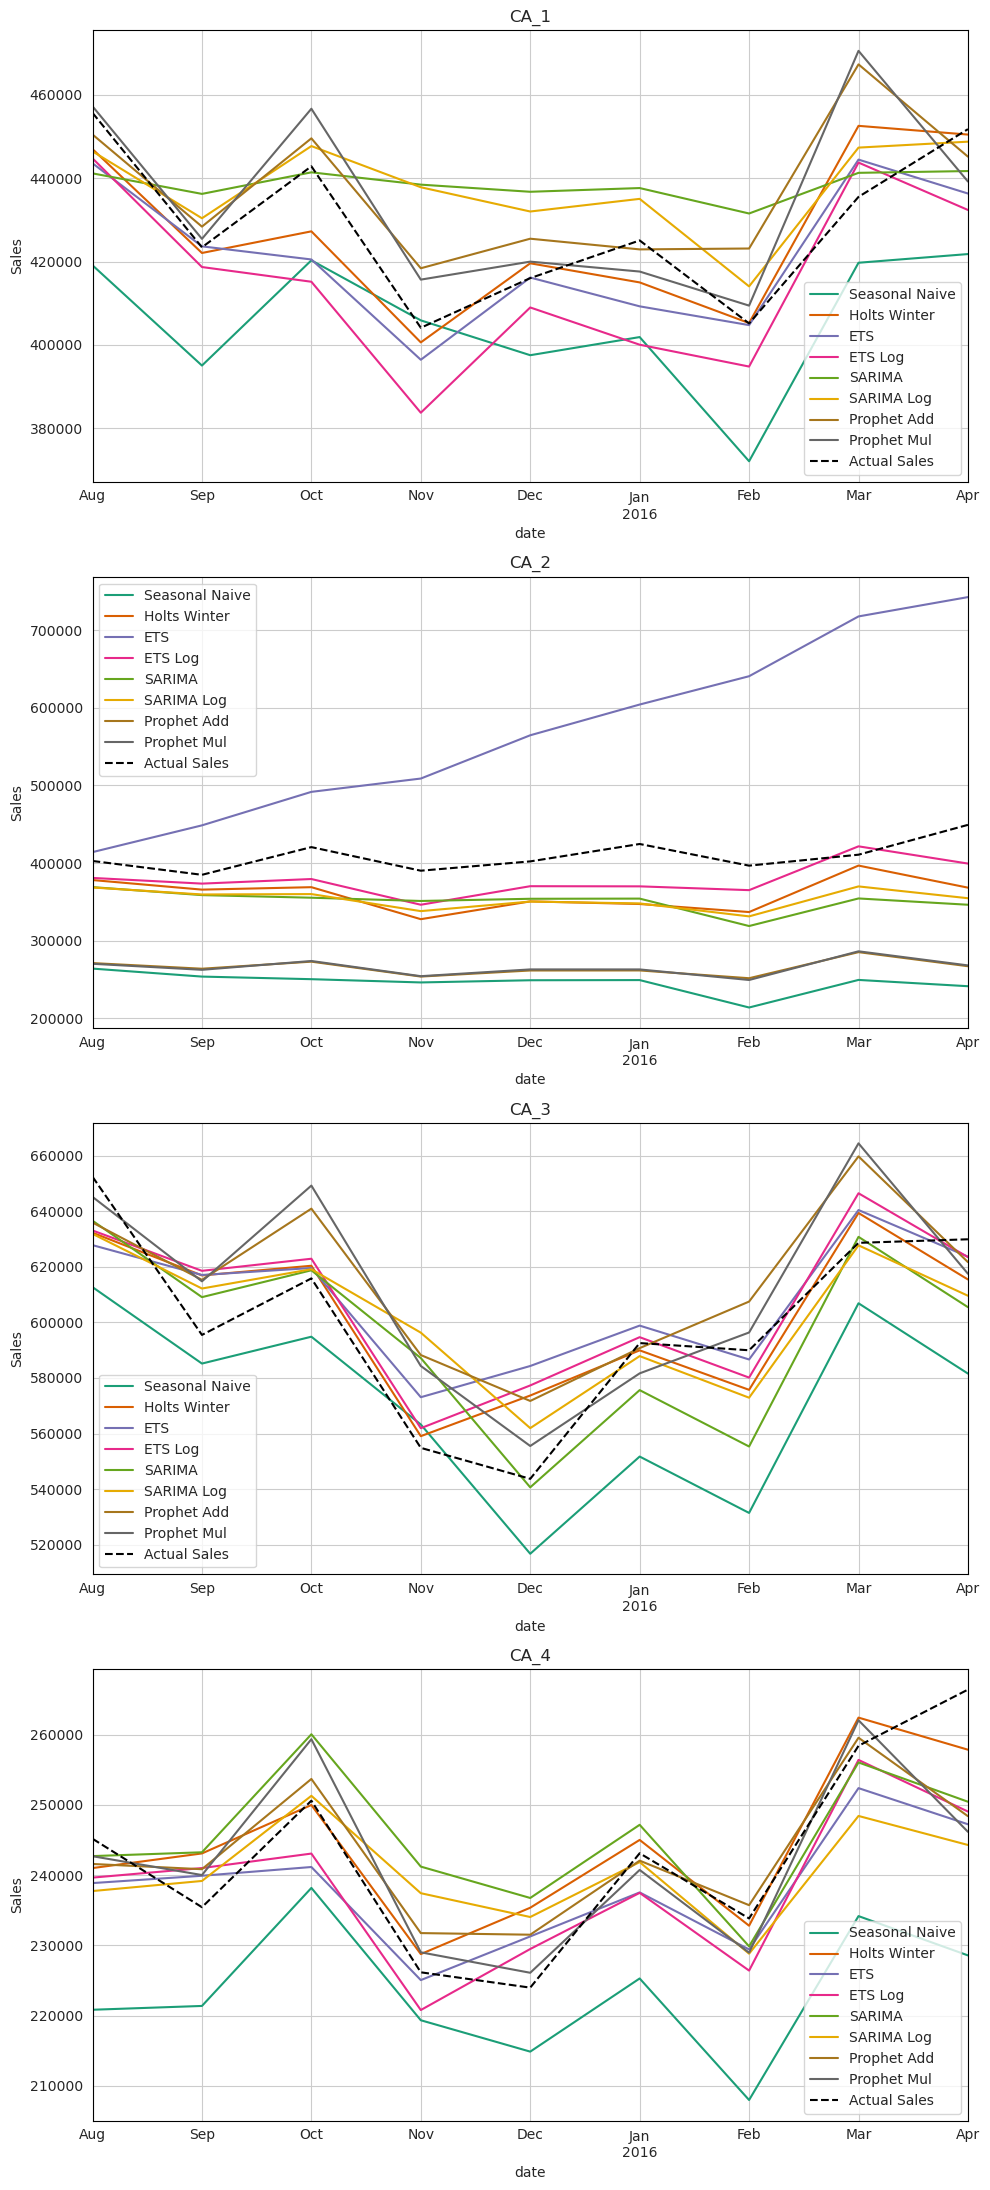

In [123]:
fig,axs=plt.subplots(figsize=(10,22),nrows=4,ncols=1)
for j,i in enumerate(store_list):   
    axs[j].set_prop_cycle(cycler('color', plt.cm.Dark2.colors))
    predicted_naive[i].plot(legend=True, label="Seasonal Naive",ax=axs[j]).set_title(i)
    predicted_HW[i].plot(legend=True, label="Holts Winter",ax=axs[j])
    predicted_ETS[i].plot(legend=True, label="ETS",ax=axs[j])
    predicted_ETSL[i].plot(legend=True, label="ETS Log",ax=axs[j])
    predicted_SARIMA[i].plot(legend=True, label="SARIMA",ax=axs[j])
    predicted_SARIMAL[i].plot(legend=True, label="SARIMA Log",ax=axs[j])
    predicted_prophet_add[i].plot(legend=True, label="Prophet Add",ax=axs[j])
    predicted_prophet_mul[i].plot(legend=True, label="Prophet Mul",ax=axs[j])
    Test[i].plot(color="black",label="Actual Sales",style="--",legend=True,ax=axs[j])
    #axs[j].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs[j].set_ylabel("Sales")
    axs[j].grid(which='minor')
fig.tight_layout()


Now we will select the best model for projecting sales at each of our stores in California. We will train the dataset using all the data, and then forecast for 6 months ahead. We will also use simulate the forecast 5000 times and calculate 95% Prediction Interval for our model. 

95% Prediction Interval is the range within which Total Monthly sale would occur. There is 95% probability that sale will occur within this range and there is 5% probability that sale will occur outside this range.

In [124]:
Model_Performance.sort_values(by=["store_id","RMSE","MAPE"],inplace=True)
Model_Performance.set_index("store_id",inplace=True)

1. **CA_1**

In [125]:
Model_Performance.loc["CA_1"]

Forecast Method  MAPE     RMSE
store_id                                       
CA_1            Holts-Winter Log   1.6   9057.5
CA_1                         ETS   2.1  11887.0
CA_1            Prophet Additive   2.6  14021.4
CA_1      Prophet Multiplicative   2.4  14154.9
CA_1                  SARIMA Log   2.8  14430.4
CA_1                     ETS Log   3.5  16821.5
CA_1                      SARIMA   3.7  18163.2
CA_1              Seasonal Naive   5.4  25314.8

Here Holts-Winter log is the best model by a substantial margin. We will select Holts Winter Triple Exponential Smoothing Model.

In [126]:
HW_model_best.loc["CA_1"]

Trend                        mul
Seasonal                     add
Damped                     False
Box_Cox                      log
AICc_Train                -312.1
MAPE_Train                   2.6
RMSE_Train               11757.9
MAPE_Test                    1.6
RMSE_Test                 9057.5
lj_residual         Uncorrelated
jb_norm_residual      Not Normal
resid_mean                -160.9
Name: CA_1, dtype: object

In [127]:
CA1_model=ExponentialSmoothing(np.log(CA_monthly["CA_1"]),
                     trend=HW_model_best.loc["CA_1"].Trend,
                     seasonal=HW_model_best.loc["CA_1"].Seasonal,
                     damped_trend=HW_model_best.loc["CA_1"].Damped,
                     seasonal_periods=12,
                     use_boxcox=False,
                     initialization_method="heuristic",
                     freq='MS').fit()
fit_CA1=np.exp(CA1_model.fittedvalues)
predicted_CA1=np.exp(CA1_model.forecast(6))
sim_frame_CA1=CA1_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [145]:
predicted_CA1

2016-05-01    465136.742649
2016-06-01    467441.235141
2016-07-01    488914.147577
2016-08-01    499735.436204
2016-09-01    470471.197811
2016-10-01    479380.284178
Freq: MS, dtype: float64

In [128]:
percentile_CA1=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA1.columns)
for i in sim_frame_CA1.columns:
    percentile_CA1.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.025).round(1)
    percentile_CA1.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.975).round(1) 

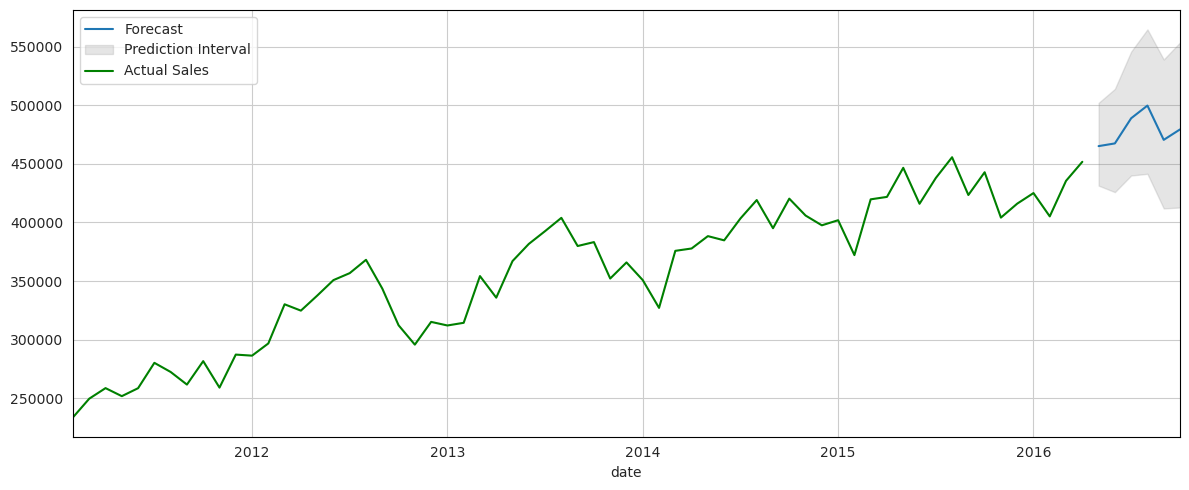

In [129]:
percentile_CA1["97.5th_percentile"]=percentile_CA1["97.5th_percentile"].astype(int)
percentile_CA1["2.5th_percentile"]=percentile_CA1["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA1.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA1.index,y1=percentile_CA1["2.5th_percentile"],y2=percentile_CA1["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["CA_1"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

1. **CA_2**

In [130]:
Model_Performance.loc["CA_2"]

Forecast Method  MAPE      RMSE
store_id                                        
CA_2                     ETS Log   8.0   36222.3
CA_2        Holts-Winter Box-Cox  11.9   54227.2
CA_2                  SARIMA Log  13.5   59230.4
CA_2                      SARIMA  13.9   62055.6
CA_2      Prophet Multiplicative  35.0  144465.9
CA_2            Prophet Additive  35.0  144694.5
CA_2              Seasonal Naive  39.6  164229.7
CA_2                         ETS  39.0  189053.0

In [131]:
CA2_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["CA_2"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA2=np.exp(CA2_model.fittedvalues)
predicted_CA2=np.exp(CA2_model.forecast(6))
sim_frame_CA2=CA2_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [146]:
predicted_CA2

2016-05-01    471748.472590
2016-06-01    501218.265605
2016-07-01    526003.984797
2016-08-01    532109.412883
2016-09-01    523274.064635
2016-10-01    531371.350006
Freq: MS, Name: predicted_mean, dtype: float64

In [132]:
percentile_CA2=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA2.columns)
for i in sim_frame_CA2.columns:
    percentile_CA2.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.025).round(1)
    percentile_CA2.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.975).round(1) 

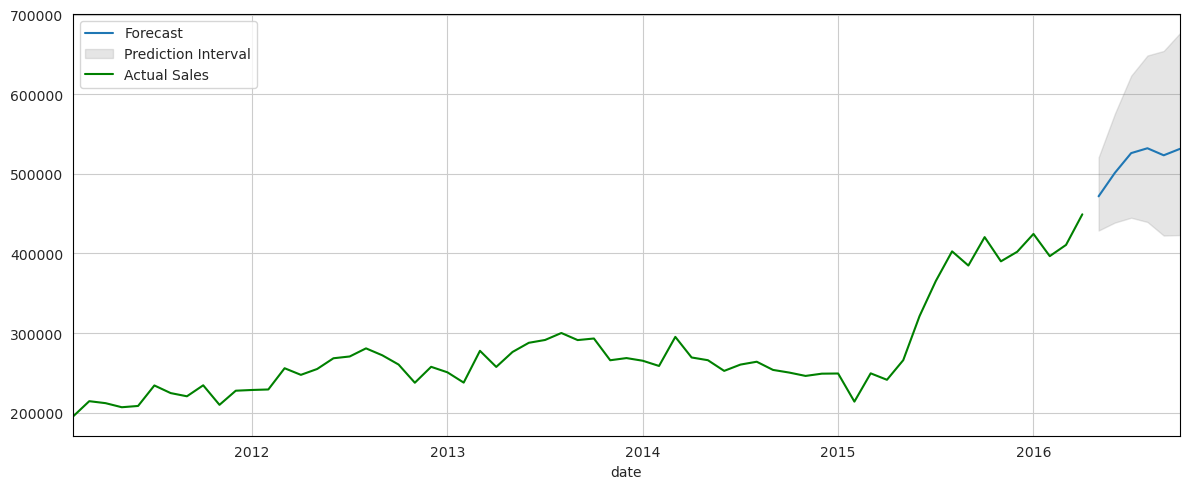

In [133]:
percentile_CA2["97.5th_percentile"]=percentile_CA2["97.5th_percentile"].astype(int)
percentile_CA2["2.5th_percentile"]=percentile_CA2["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["CA_2"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

In [134]:
t1=CA2_model.get_forecast(6)
t2=t1.summary_frame(alpha=0.05).apply(np.exp)[["mean","mean_ci_lower","mean_ci_upper"]]

statsmodel.tsa.statespace.ExponentialSmoothing model also provides prediction interval when making forecast using get_forecast method. This is approximately the same as prediction interval calculated after simulating the forecast mutliple times.

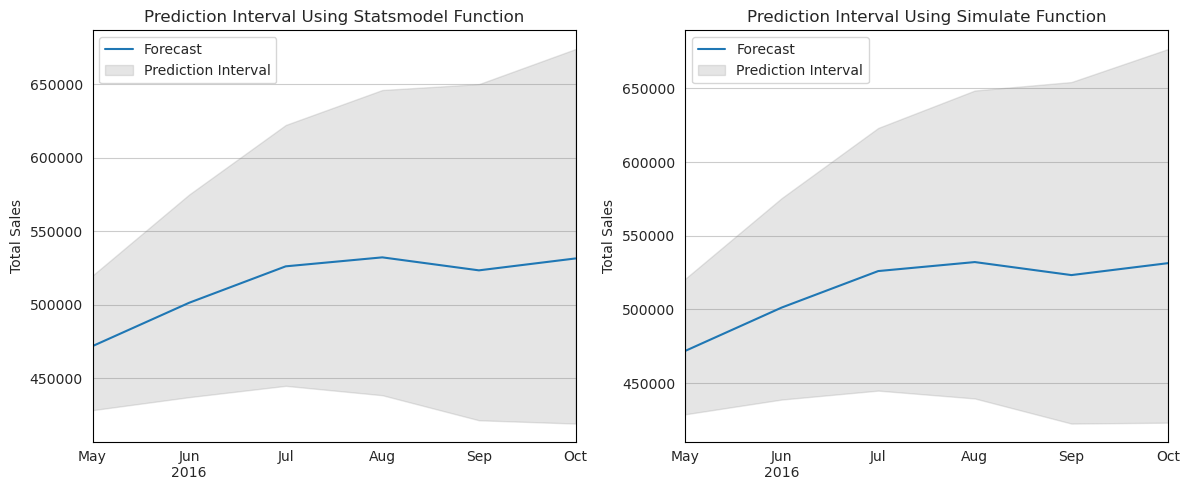

In [135]:
fig, (ax,ax2) = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=t2.mean_ci_lower,y2=t2.mean_ci_upper,label="Prediction Interval", alpha=0.2,color='gray')
ax.legend(loc="upper left")
ax.set_title("Prediction Interval Using Statsmodel Function")
ax.set_ylabel("Total Sales")
predicted_CA2.plot(ax=ax2, legend=True, label="Forecast" )
ax2.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
ax2.legend(loc="upper left")
ax2.set_title("Prediction Interval Using Simulate Function")
ax2.set_ylabel("Total Sales")
fig.tight_layout()

1. **CA_3**

In [136]:
Model_Performance.loc["CA_3"]

Forecast Method  MAPE     RMSE
store_id                                       
CA_3                Holts-Winter   2.3  16106.3
CA_3                     ETS Log   2.4  16981.6
CA_3                         ETS   2.6  19131.5
CA_3                  SARIMA Log   2.7  19692.5
CA_3                      SARIMA   2.7  19955.4
CA_3      Prophet Multiplicative   3.1  21454.0
CA_3            Prophet Additive   3.4  22460.5
CA_3              Seasonal Naive   5.1  34676.5

In [137]:
print("Holts Winter AICc:",HW_model_best.loc["CA_3"].AICc_Train,"\nETS Log AICc:",ETSL_models[2].aicc)

Holts Winter AICc: 1115.4 
ETS Log AICc: -183.71370444565144


We will be selecting ETS Log method here as the AICc fot ETS log is considerably smaller, while accuracy is almost the same as Holts Winter Method.

In [138]:
CA3_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["CA_3"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA3=np.exp(CA3_model.fittedvalues)
predicted_CA3=np.exp(CA3_model.forecast(6))
sim_frame_CA3=CA3_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [147]:
predicted_CA3

2016-05-01    645478.469641
2016-06-01    657287.651416
2016-07-01    683404.485287
2016-08-01    700867.111105
2016-09-01    681281.944799
2016-10-01    688449.889599
Freq: MS, Name: predicted_mean, dtype: float64

In [139]:
percentile_CA3=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA3.columns)
for i in sim_frame_CA3.columns:
    percentile_CA3.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.025).round(1)
    percentile_CA3.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.975).round(1) 

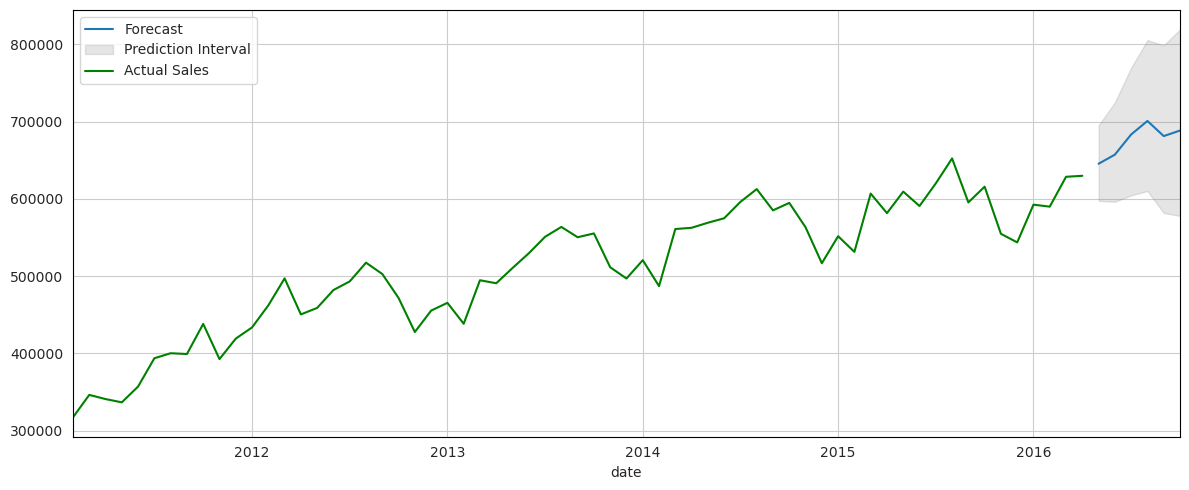

In [140]:
percentile_CA3["97.5th_percentile"]=percentile_CA3["97.5th_percentile"].astype(int)
percentile_CA3["2.5th_percentile"]=percentile_CA3["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA3.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA3.index,y1=percentile_CA3["2.5th_percentile"],y2=percentile_CA3["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["CA_3"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

1. **CA_4**

In [141]:
Model_Performance.loc["CA_4"]

Forecast Method  MAPE     RMSE
store_id                                       
CA_4            Holts-Winter Log   1.9   5833.4
CA_4            Prophet Additive   2.1   7227.0
CA_4      Prophet Multiplicative   2.3   7947.3
CA_4                     ETS Log   2.8   7953.6
CA_4                         ETS   2.9   8546.3
CA_4                      SARIMA   3.4   9649.6
CA_4                  SARIMA Log   3.2  10071.4
CA_4              Seasonal Naive   7.8  21282.6

In [142]:
CA4_model=ExponentialSmoothing(np.log(CA_monthly["CA_4"]),
                     trend=HW_model_best.loc["CA_4"].Trend,
                     seasonal=HW_model_best.loc["CA_4"].Seasonal,
                     damped_trend=HW_model_best.loc["CA_4"].Damped,
                     seasonal_periods=12,
                     use_boxcox=False,
                     initialization_method="heuristic",
                     freq='MS').fit()
fit_CA4=np.exp(CA4_model.fittedvalues)
predicted_CA4=np.exp(CA4_model.forecast(6))
sim_frame_CA4=CA4_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [148]:
predicted_CA4

2016-05-01    274448.917827
2016-06-01    272083.241267
2016-07-01    279628.568563
2016-08-01    286228.562220
2016-09-01    285916.159074
2016-10-01    296035.040924
Freq: MS, dtype: float64

In [143]:
percentile_CA4=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA4.columns)
for i in sim_frame_CA4.columns:
    percentile_CA4.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA4[i],0.025).round(1)
    percentile_CA4.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA4[i],0.975).round(1) 

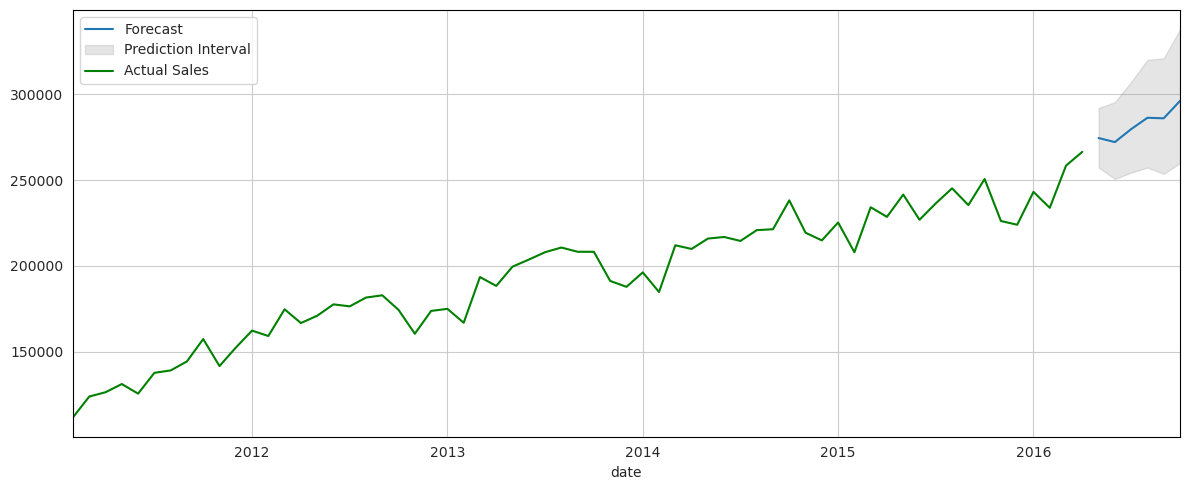

In [144]:
percentile_CA4["97.5th_percentile"]=percentile_CA4["97.5th_percentile"].astype(int)
percentile_CA4["2.5th_percentile"]=percentile_CA4["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA4.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA4.index,y1=percentile_CA4["2.5th_percentile"],y2=percentile_CA4["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["CA_4"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()